# Cell proportions along the disease stages

Now I want to evaluate how the cell sub-populations change between the healthy and disease BM. Since the cell labels are numrous (44), to made it more readable I decided to convert the cell types in more general annotations (NK, B, T monocytes and Erythrocytes).
The labels will be changes using this conversion:

In [3]:
# prepare environmnet
%matplotlib inline
import scanpy as sc 
import pandas as pd
import numpy as np
import scipy.stats as ss ## stat functions from scipy
#import scikit_posthocs as sp  ## stat functions from scikit
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator ## add nice annotation ans statistical testing on plot
import statannotations as sta
from IPython.display import display ## display figure in order
import warnings ## ignore warnings
warnings.filterwarnings('ignore')
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(10, 10))

In [11]:
labels = pd.read_csv("general_labels.csv", header=None) #read csv used to convert cell labels
labels.columns = ["Cell type", "Major type"] # rename columns
list_cells = labels["Major type"].sort_values().unique().tolist() #save unique major types for next steps
labels.sort_values("Major type") # sort by second column

,Cell type,Major type
10,Class switched memory B cells,B cell
24,Mature naive B cells,B cell
30,Nonswitched memory B cells,B cell
20,Immature B cells,B cell
25,Megakaryocyte progenitors,Megakaryocytes
29,Non-classical monocytes,Monocyte
11,Classical Monocytes,Monocyte
26,Myelocytes,Myelocytes
3,CD56brightCD16- NK cells,NK cell
4,CD56dimCD16+ NK cells,NK cell


In [12]:
adata = sc.read("Data/MM_atlas_umap.h5ad") # load MM dataset
healthy = sc.read("Data/Healthy_raw_labelled.h5ad") # load healthy dataset

In [14]:
healthy.obs.label.value_counts()

CD4+ memory T cells                          18075
CD8+ naive T cells                           13874
Aberrant erythroid                           12879
Late erythroid progenitor                    12031
CD4+ naive T cells                           10769
Classical Monocytes                           9941
CD8+ effector memory T cells                  7548
CD56dimCD16+ NK cells                         7170
Mature naive B cells                          5284
Myelocytes                                    4822
Nonswitched memory B cells                    4507
CD8+ central memory T cells                   3840
CD8+CD103+ tissue resident memory T cells     3657
Lymphomyeloid prog                            2434
GammaDelta T cells                            2093
HSCs & MPPs                                   1992
Early promyelocytes                           1903
Late promyelocytes                            1736
Non-classical monocytes                       1678
Pro-B cells                    

In [15]:
celltypes = adata.obs.label # extract cell types from MM dataset
labels = pd.read_csv("general_labels.csv", header=None, index_col=0, squeeze=True).to_dict() # load the previous table as dictionary
celltypes = celltypes.replace(labels) # use the dictionary to replace the cell typ labels
adata.obs["major_type"] = celltypes # save a new variable with the major types
adata.obs.major_type.value_counts()

Plasma cell       146674
T cell             41676
B cell             30615
Monocyte           25753
NK cell            14620
Progenitors        13667
Myelocytes         10374
Pre B cell          3744
promyelocytes       3150
cDC                 3024
pDC                 1974
erythrocyte         1503
Megakaryocytes      1034
Name: major_type, dtype: int64

In [16]:
adata.write("MM_atlas_major_types.h5ad") # save the dataset with major types

In [17]:
# repeat for healthy samples
celltypes = healthy.obs.label
celltypes = celltypes.replace(labels)
healthy.obs["major_type"] = celltypes
healthy.write("Healthy_major_types.h5ad")
healthy.obs.major_type.value_counts()

T cell            60003
Progenitors       18093
erythrocyte       12879
B cell            11961
Monocyte          11619
NK cell            7761
Myelocytes         4822
promyelocytes      3902
Pre B cell         2857
cDC                1877
pDC                1334
Plasma cell         763
Megakaryocytes      595
Name: major_type, dtype: int64

Since the MM dataset contains samples from different sources (whole BM, sorted plasma/B/NK cells), I have to consider only the cells that derive from unsorted samples

In [18]:
batches = pd.DataFrame(adata.obs.batch.unique()) # get list of batches
bm = batches[batches[0].str.contains("BM")] # filter considering only batches that contain "BM" (unsorted bone marrow)
bm = bm[0].values.tolist() # convert to list
adata_bm = adata[adata.obs["batch"].isin(bm)] # create anndata object with only bm samples
print("Number of samples of total samples: %d \nNumber of samples of unsorted BM: %d \nNumber of cells: %s" % (len(batches),len(bm),adata_bm.n_obs))

Number of samples of total samples: 55 
Number of samples of unsorted BM: 24 
Number of cells: 84551


Now for each sample in each condition I will compute the proportions of cell types (major)

In [19]:
def proportions(adata, batches): # create dataframe with cell types proportion for the given batches
    df = pd.DataFrame() # create empty dataframe
    for b in batches: #iterate along all the batches desired
        temp = adata[adata.obs.batch == b] # create temporary file with cell from desired batch
        cells = temp.obs.major_type.value_counts() # get counts
        total_cells = cells.sum() # sum cells
        proportions = (cells/total_cells)*100 # get percentage 
        df = df.append(proportions) # append the cell proortions of the give batches to the df (as rows)
    df.index = batches # rownames as batches
    return df

def celltype(label,condition,table): # create tidy (long) dataframe of the cell proportion for the given cell type
    cell_type = {} # create empty dictionary
    for i in range(0,len(condition)): # iterate along the conditions
        cell_type[condition[i]] = table[i][label].values.tolist() #extract the proportion of the desired cell type
    cell_type = pd.DataFrame.from_dict(cell_type, orient="index").transpose() # convert to pandas dataframe
    cell_type["cell"] = label # add column with cell type
    cell_type_long = pd.melt(cell_type, id_vars="cell", value_vars=condition) # pivot longer
    return cell_type, cell_type_long

In [20]:
# Start with healthy
batches = healthy.obs.batch.unique().tolist() # healthy batches
health = proportions(healthy, batches) # get proportions

# SMM
batches = adata_bm.obs.batch.unique().tolist() # get batches from MM dataset (BM)
batches = [x for x in batches if 'SMM' in x] # keep only those who contains SMM
SMM = proportions(adata,batches) # get proportions

# PMM
batches = adata_bm.obs.batch.unique().tolist()
batches = [x for x in batches if 'PMM' in x]
PMM = proportions(adata,batches)

# RRMM
batches = adata_bm.obs.batch.unique().tolist()
batches = [x for x in batches if 'RRMM' in x]
RRMM = proportions(adata,batches)

In [21]:
conditions = ["health", "SMM", "PMM", "RRMM"] # list conditions as string
tables = [health, SMM, PMM, RRMM] # list of conditions dataframes


cell_proportions = {} #create new empty dictionary to iterate all the cell types
cell_proportions_long = {}

for c in list_cells:
    cell_proportions[c], cell_proportions_long[c] = celltype(c, conditions, tables)

cells = pd.concat(cell_proportions_long,ignore_index=True) # concatenate the cells
cells.columns = ["cell", "condition", "proportions"]
cells.to_csv("cell_proportions_tidy.csv",index=False)

In [22]:
# let's do some statistics:
def statistics():
    significant = []
    for cell in list_cells:
        
        title = cell       
        fig = plt.figure()
        ax = sns.boxplot(data=cell_proportions_long[cell], x = "variable", y= "value",showfliers = False)
        ax = sns.stripplot(data=cell_proportions_long[cell], x="variable", y="value", alpha=0.7, color="black")
        fig = plt.xlabel("Condition")
        fig = plt.ylabel("Proportion(%)")
        fig = plt.title(title)
        

        pairs=[("health", "SMM"),("health", "PMM"),("health", "RRMM"),("SMM", "PMM"),("SMM", "RRMM"),("PMM","RRMM")]
        pvalues = []
        for a,b in pairs:
            test = ss.mannwhitneyu(x=cell_proportions[cell][a], y=cell_proportions[cell][b], nan_policy="omit").pvalue
            pvalues.append(test)

        pair_2=[]
        good_pv=[]
        formatted_pvalues = ["" if p == np.nan else p for p in pvalues]
        for index, value in enumerate(pvalues):
            if value <0.05:
                pair_2.append(pairs[index])
                good_pv.append(value)
 
        if len(pair_2)<1:
            #print(f"There are no significant thingis for {cell} :C")
            display(fig)

            plt.show()
            print("\n\n\n\n\n")
        else:
            annotator = Annotator(ax=ax,pairs=pair_2, data=cell_proportions_long[cell], x="variable", y="value", order = conditions)
            #annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
            #annotator.apply_and_annotate()
            annotator.set_pvalues(good_pv)
            annotator.annotate()
            display(fig)

            plt.show()
            print("\n\n\n\n\n")
        
    
    return significant




Text(0.5, 1.0, 'B cell')

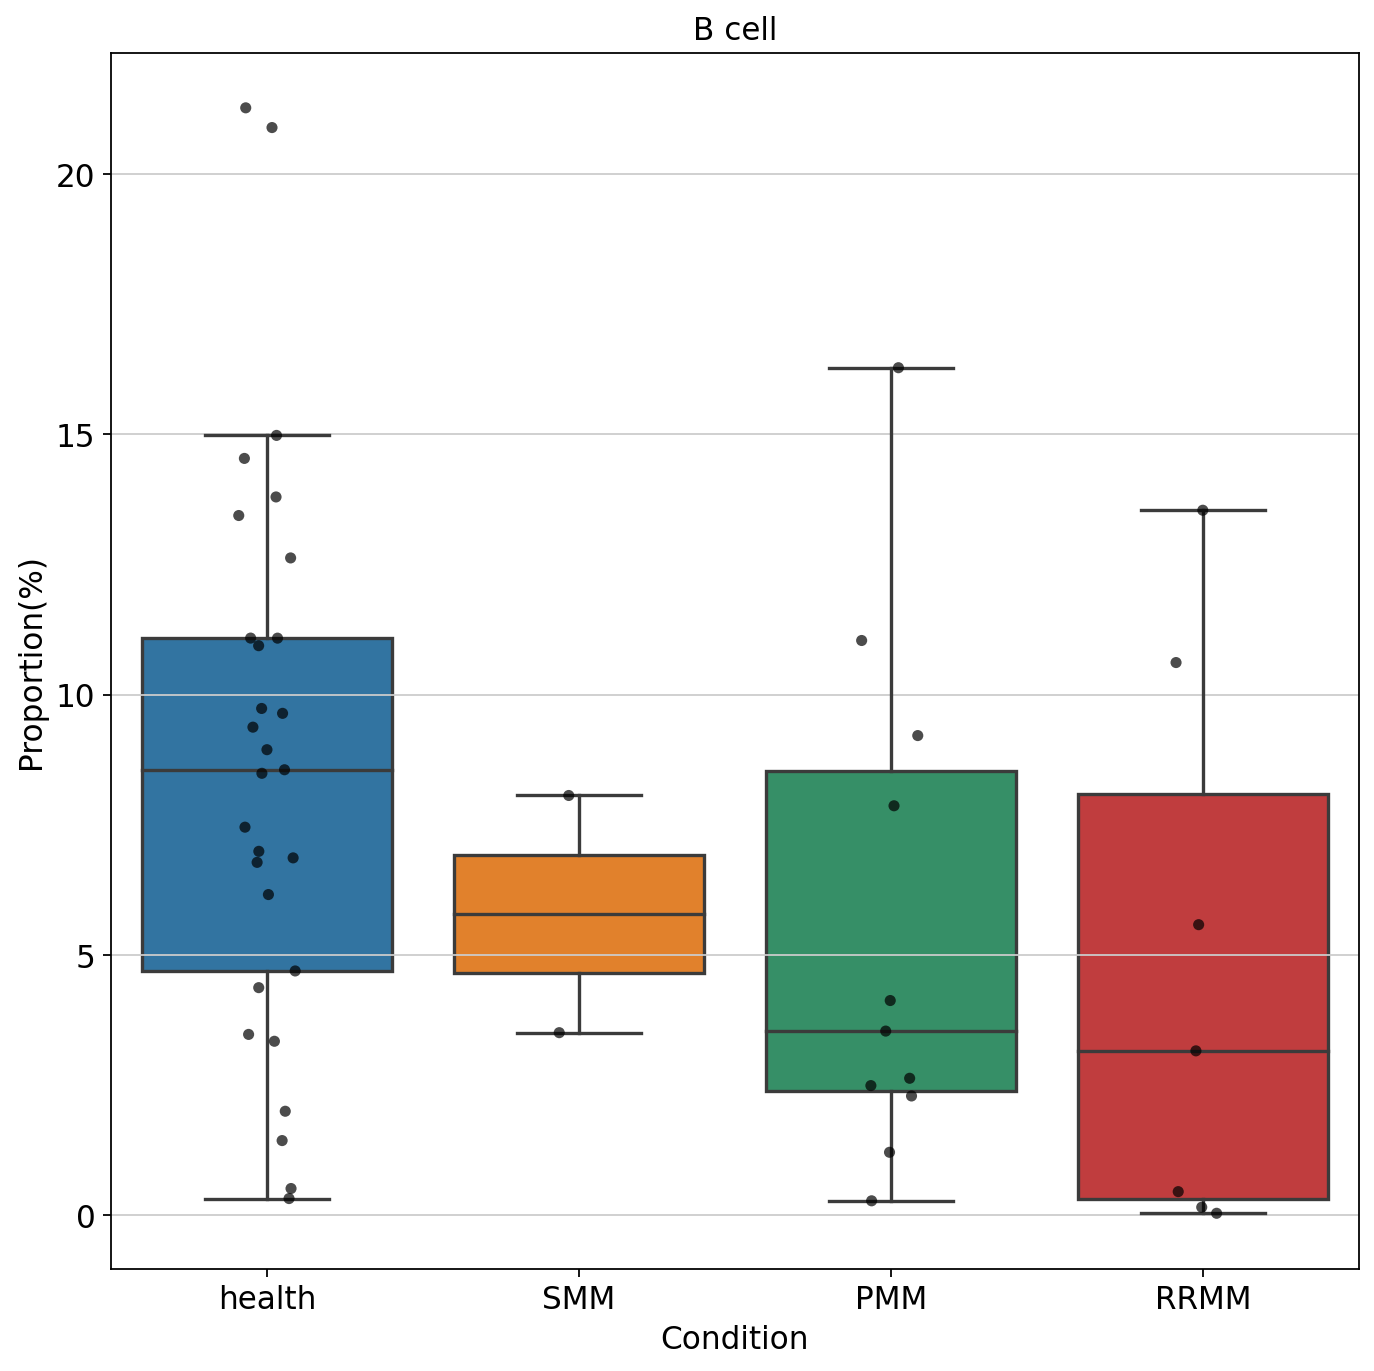

Text(0.5, 1.0, 'Megakaryocytes')

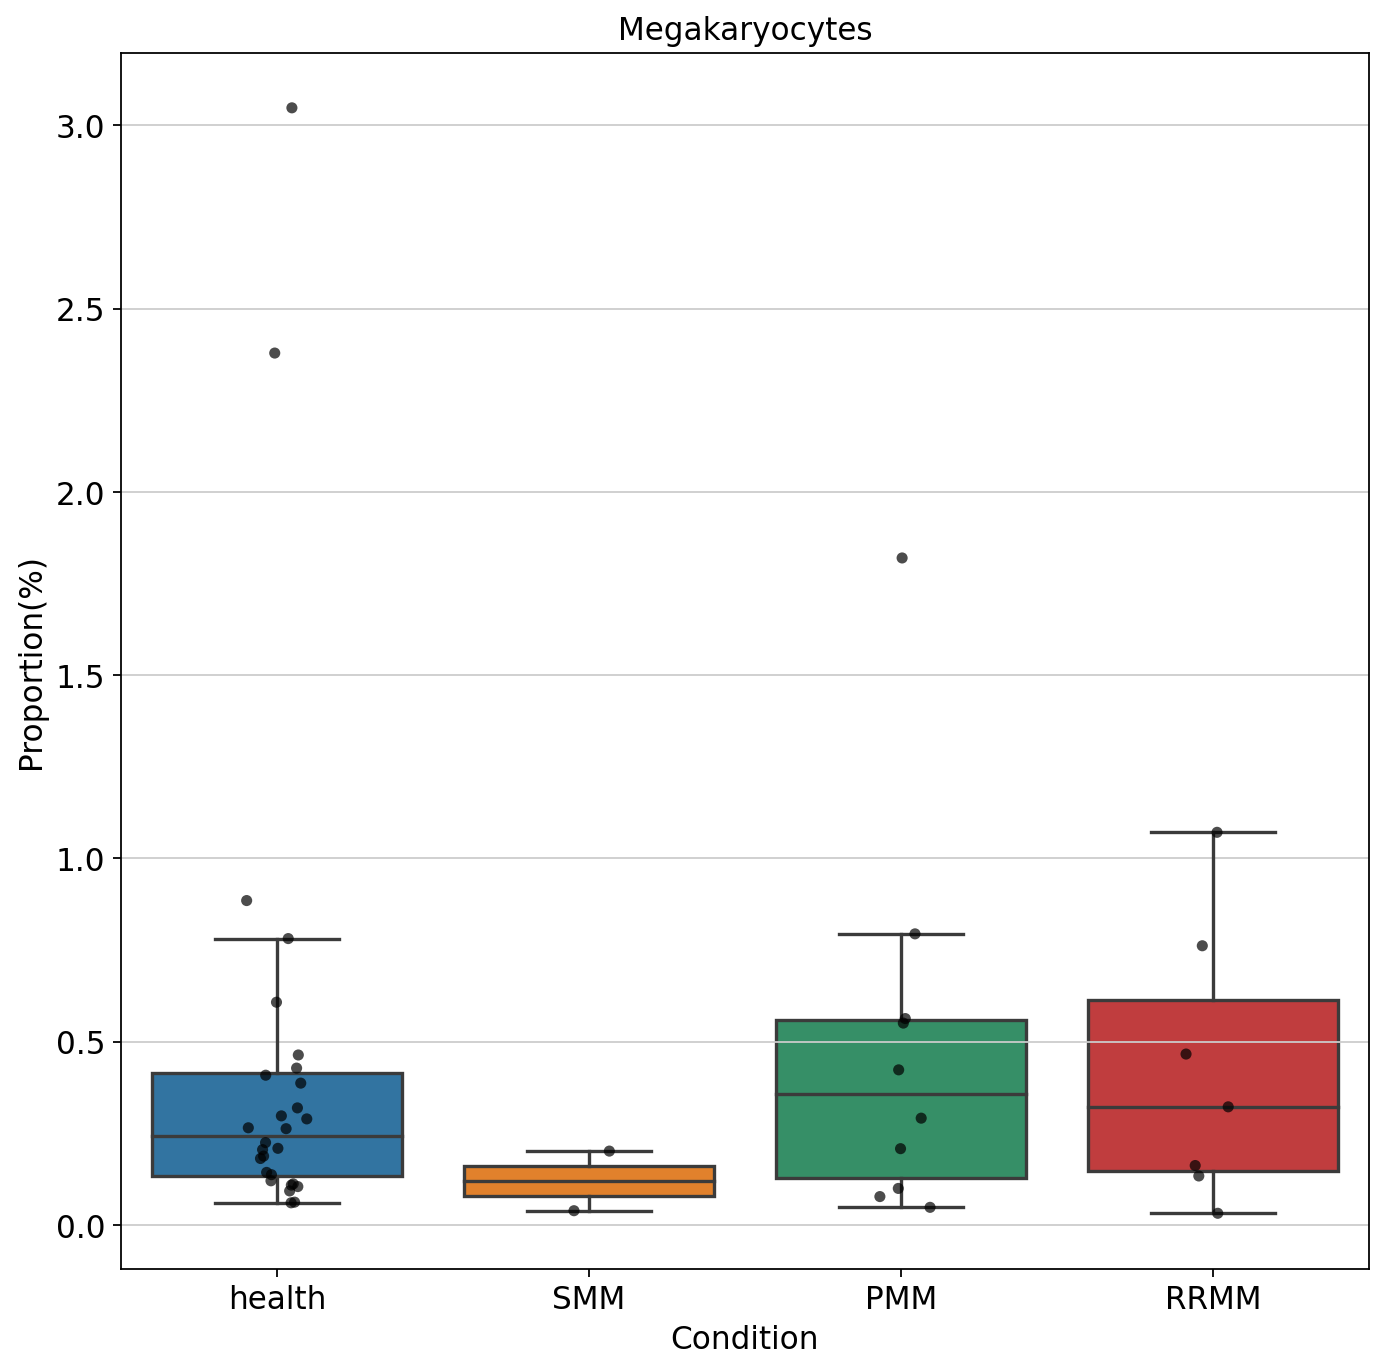







p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

health vs. PMM: Custom statistical test, P_val:4.750e-02


Text(0.5, 1.0, 'Monocyte')

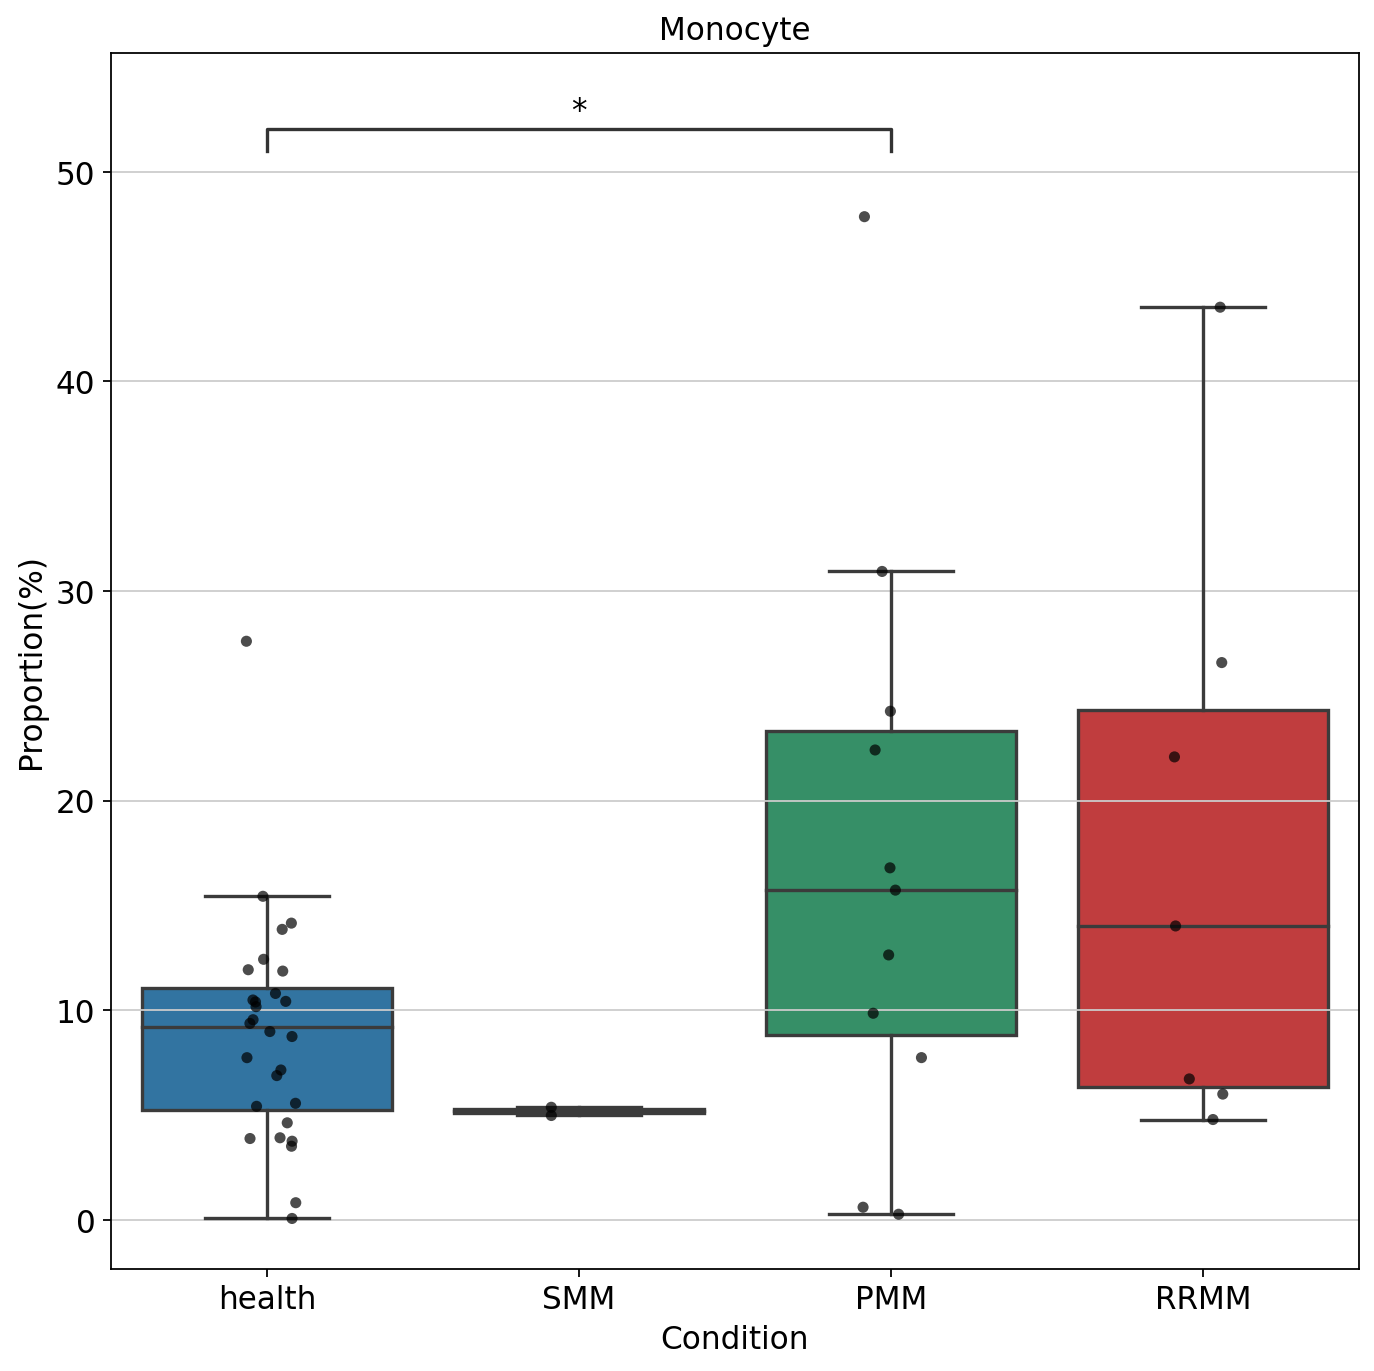

Text(0.5, 1.0, 'Myelocytes')

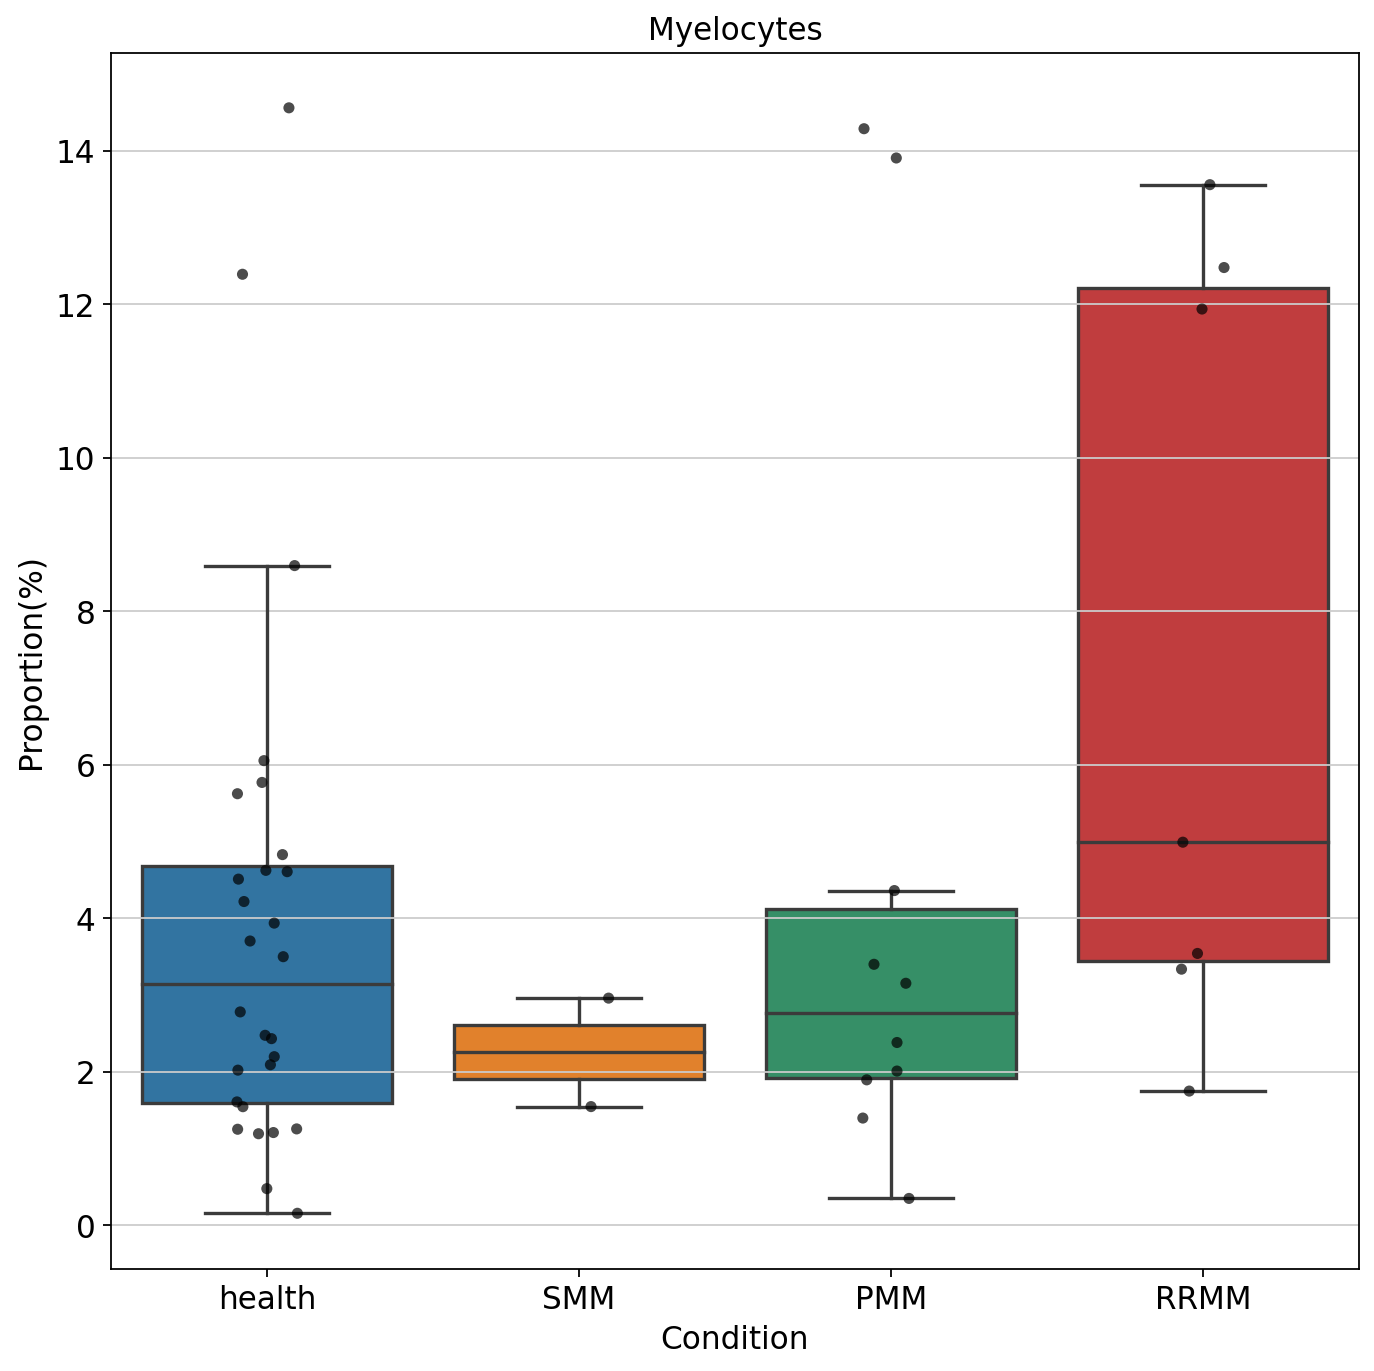

Text(0.5, 1.0, 'NK cell')

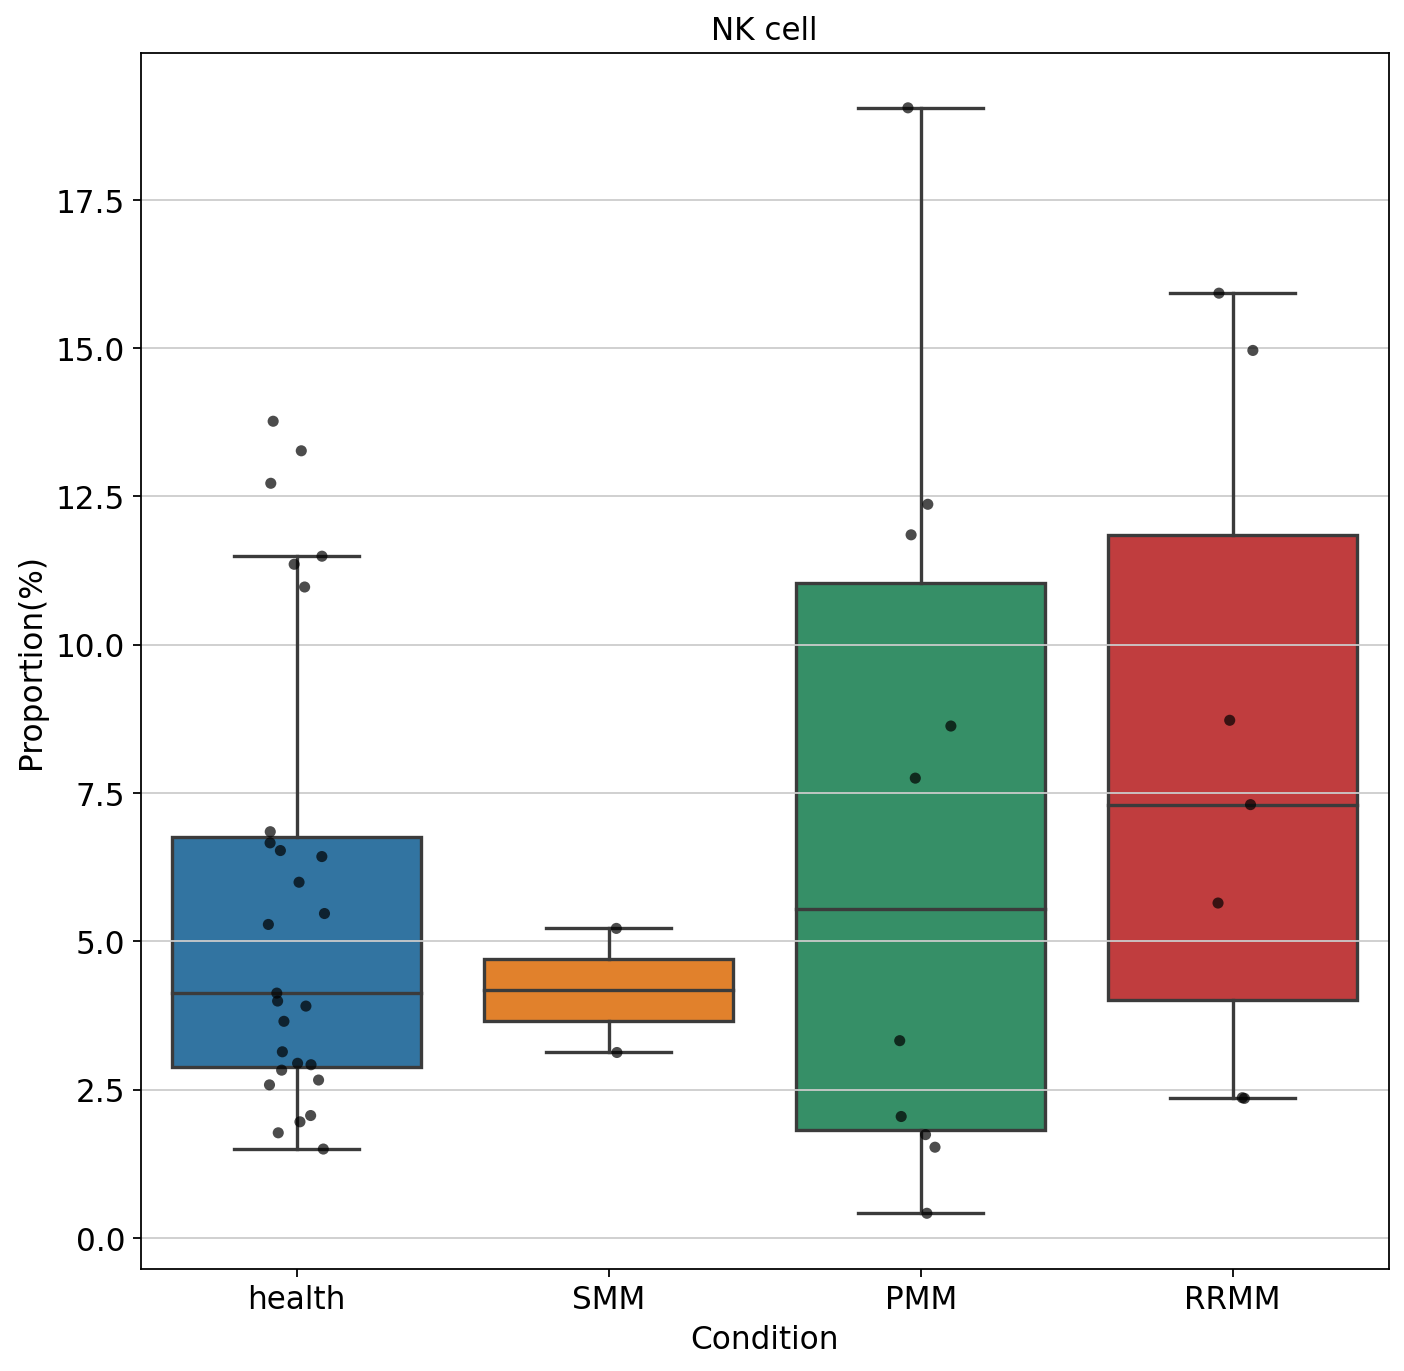







p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

health vs. SMM: Custom statistical test, P_val:5.291e-03
health vs. PMM: Custom statistical test, P_val:2.114e-04
health vs. RRMM: Custom statistical test, P_val:4.744e-03


Text(0.5, 1.0, 'Plasma cell')

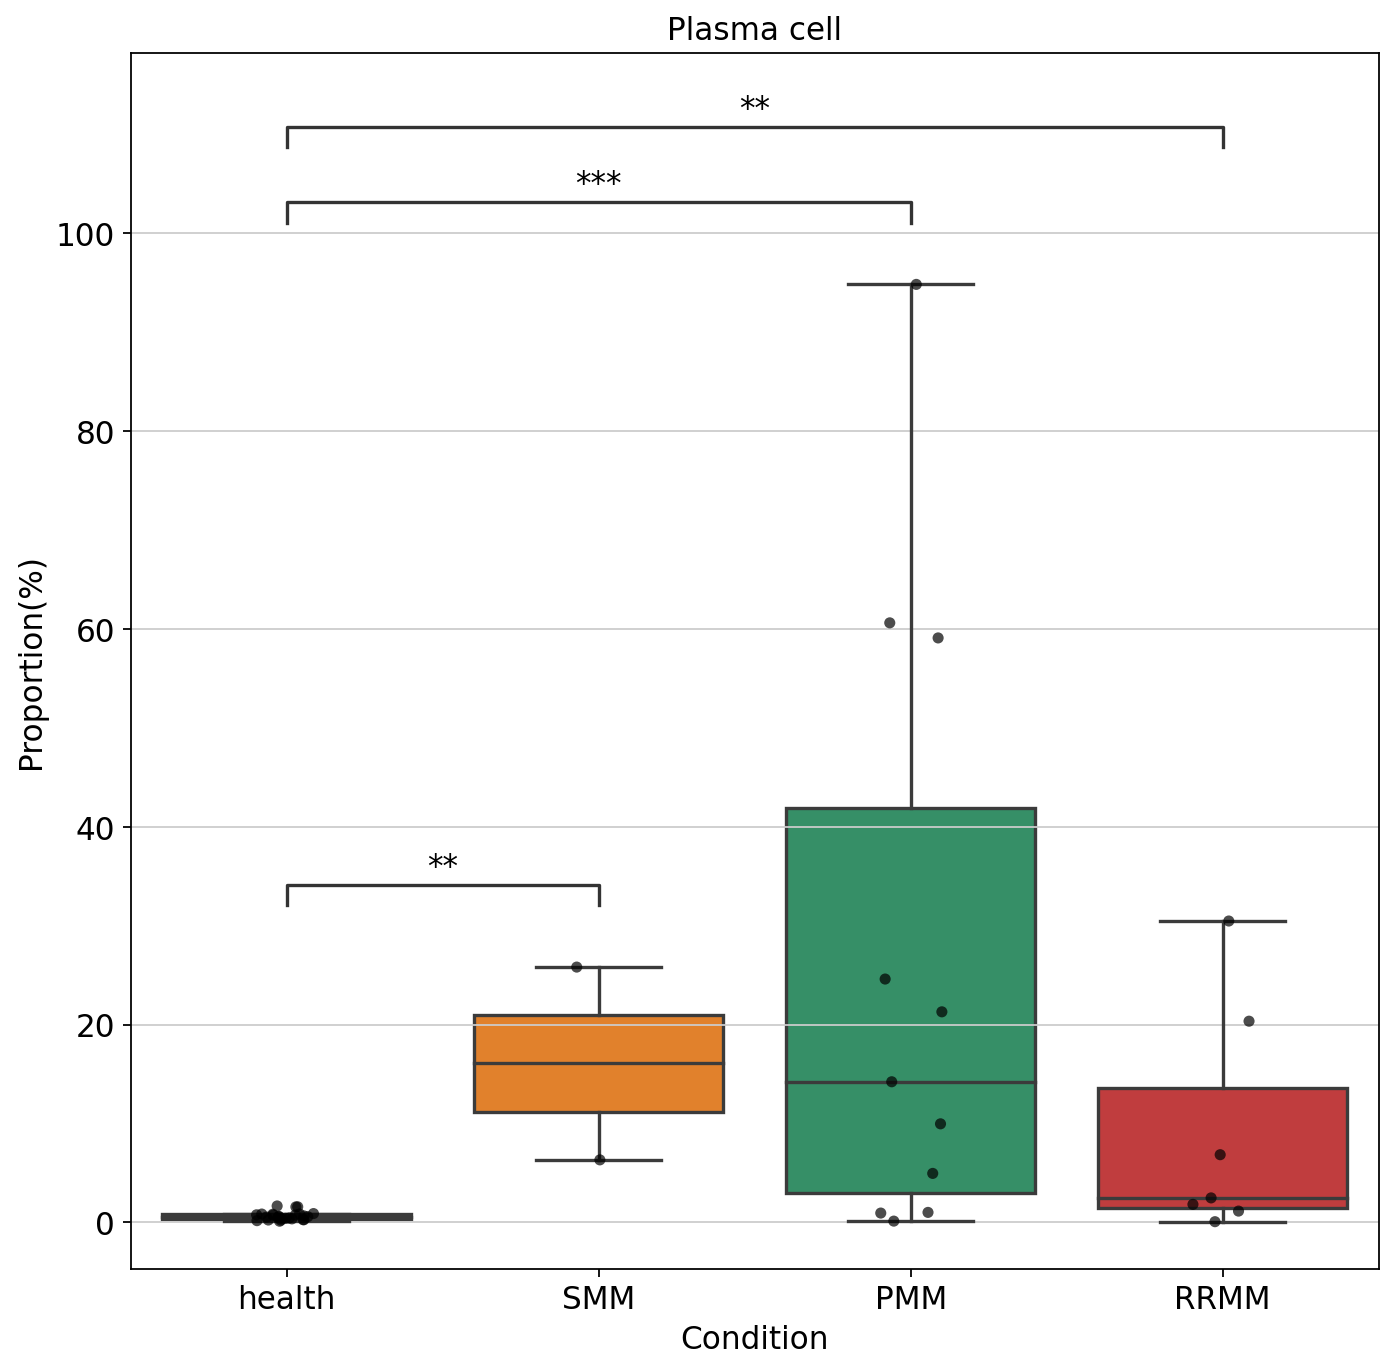







p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

health vs. PMM: Custom statistical test, P_val:3.953e-02
health vs. RRMM: Custom statistical test, P_val:2.252e-05


Text(0.5, 1.0, 'Pre B cell')

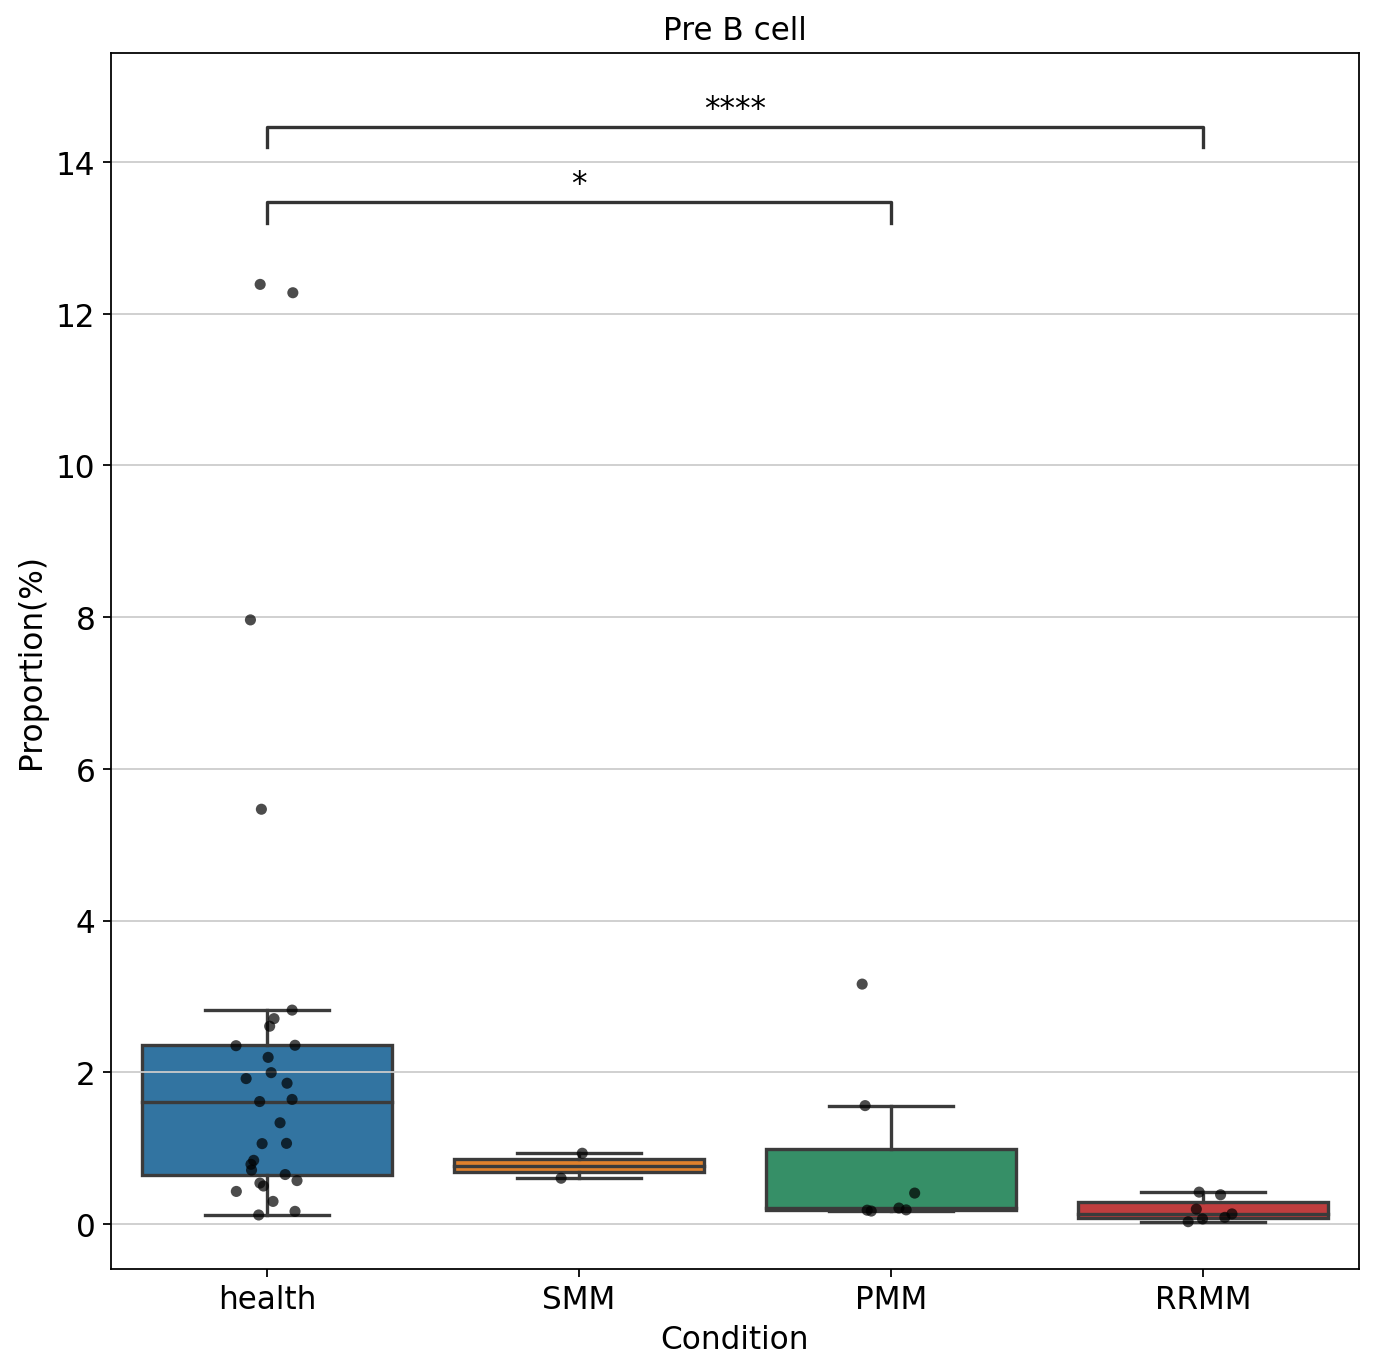







p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

health vs. PMM: Custom statistical test, P_val:1.415e-02
health vs. RRMM: Custom statistical test, P_val:1.396e-02


Text(0.5, 1.0, 'Progenitors')

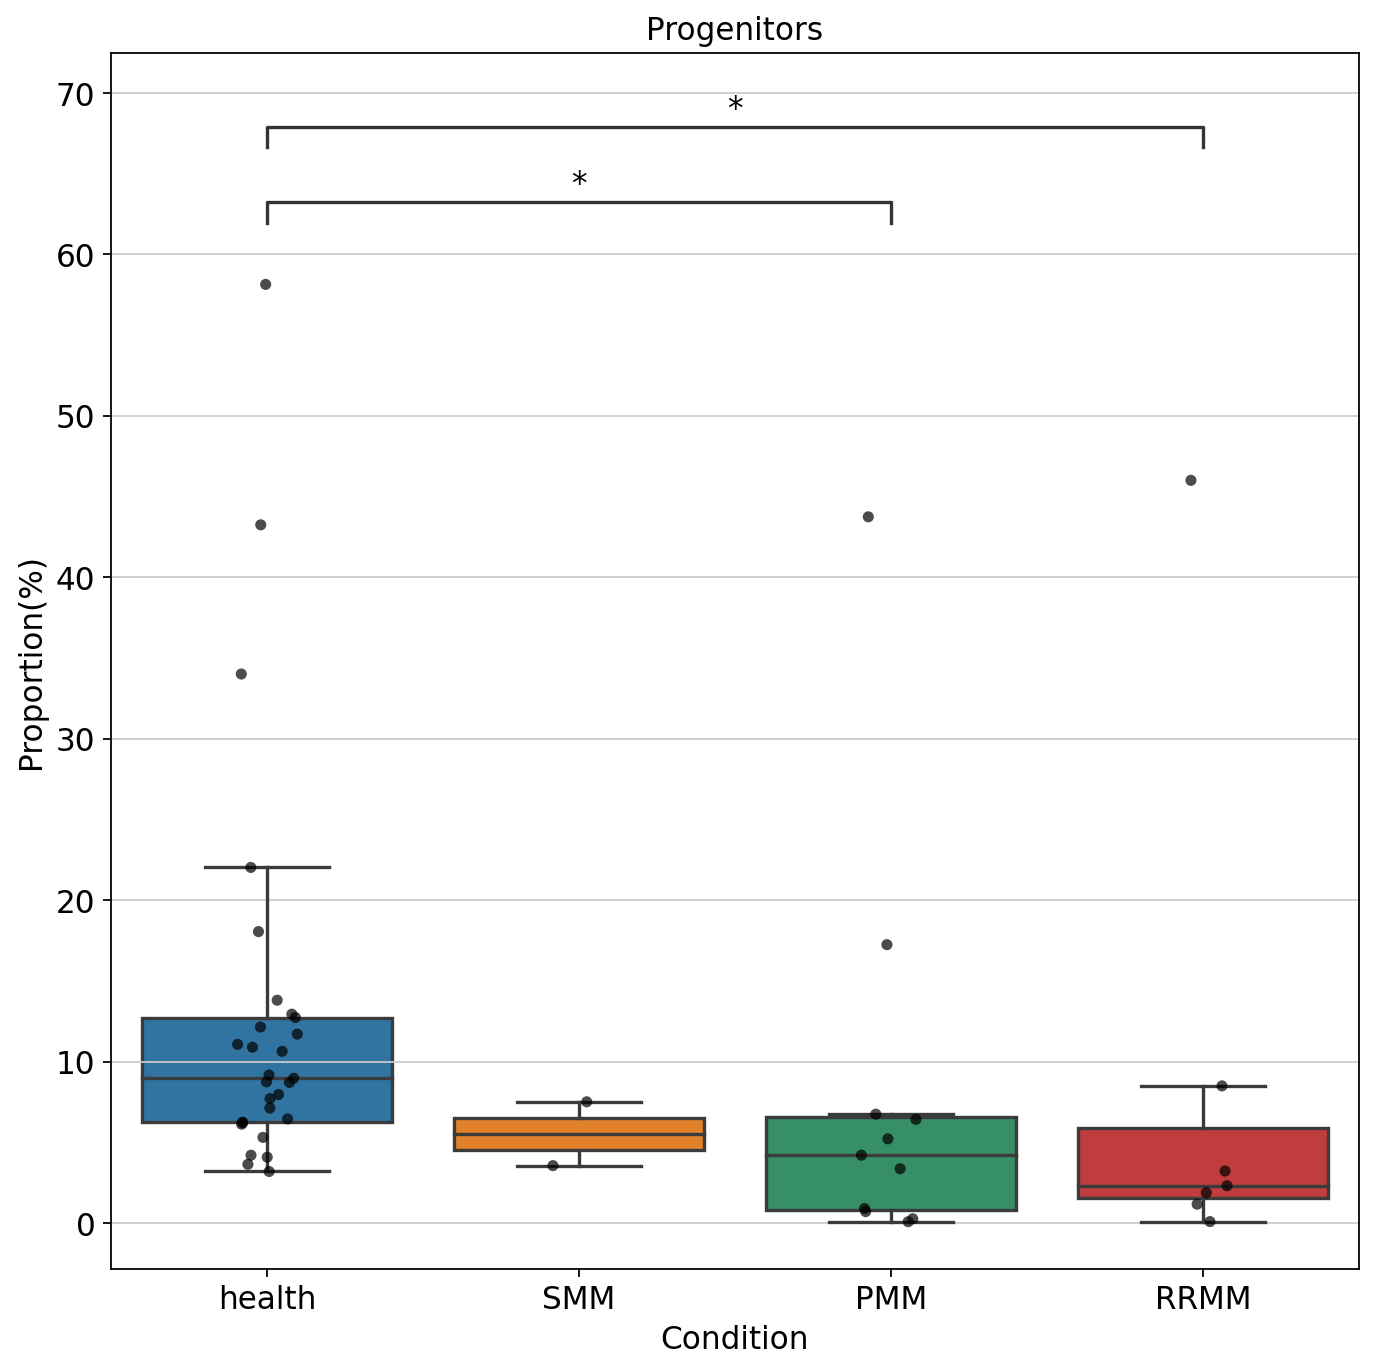







p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

health vs. PMM: Custom statistical test, P_val:1.193e-02


Text(0.5, 1.0, 'T cell')

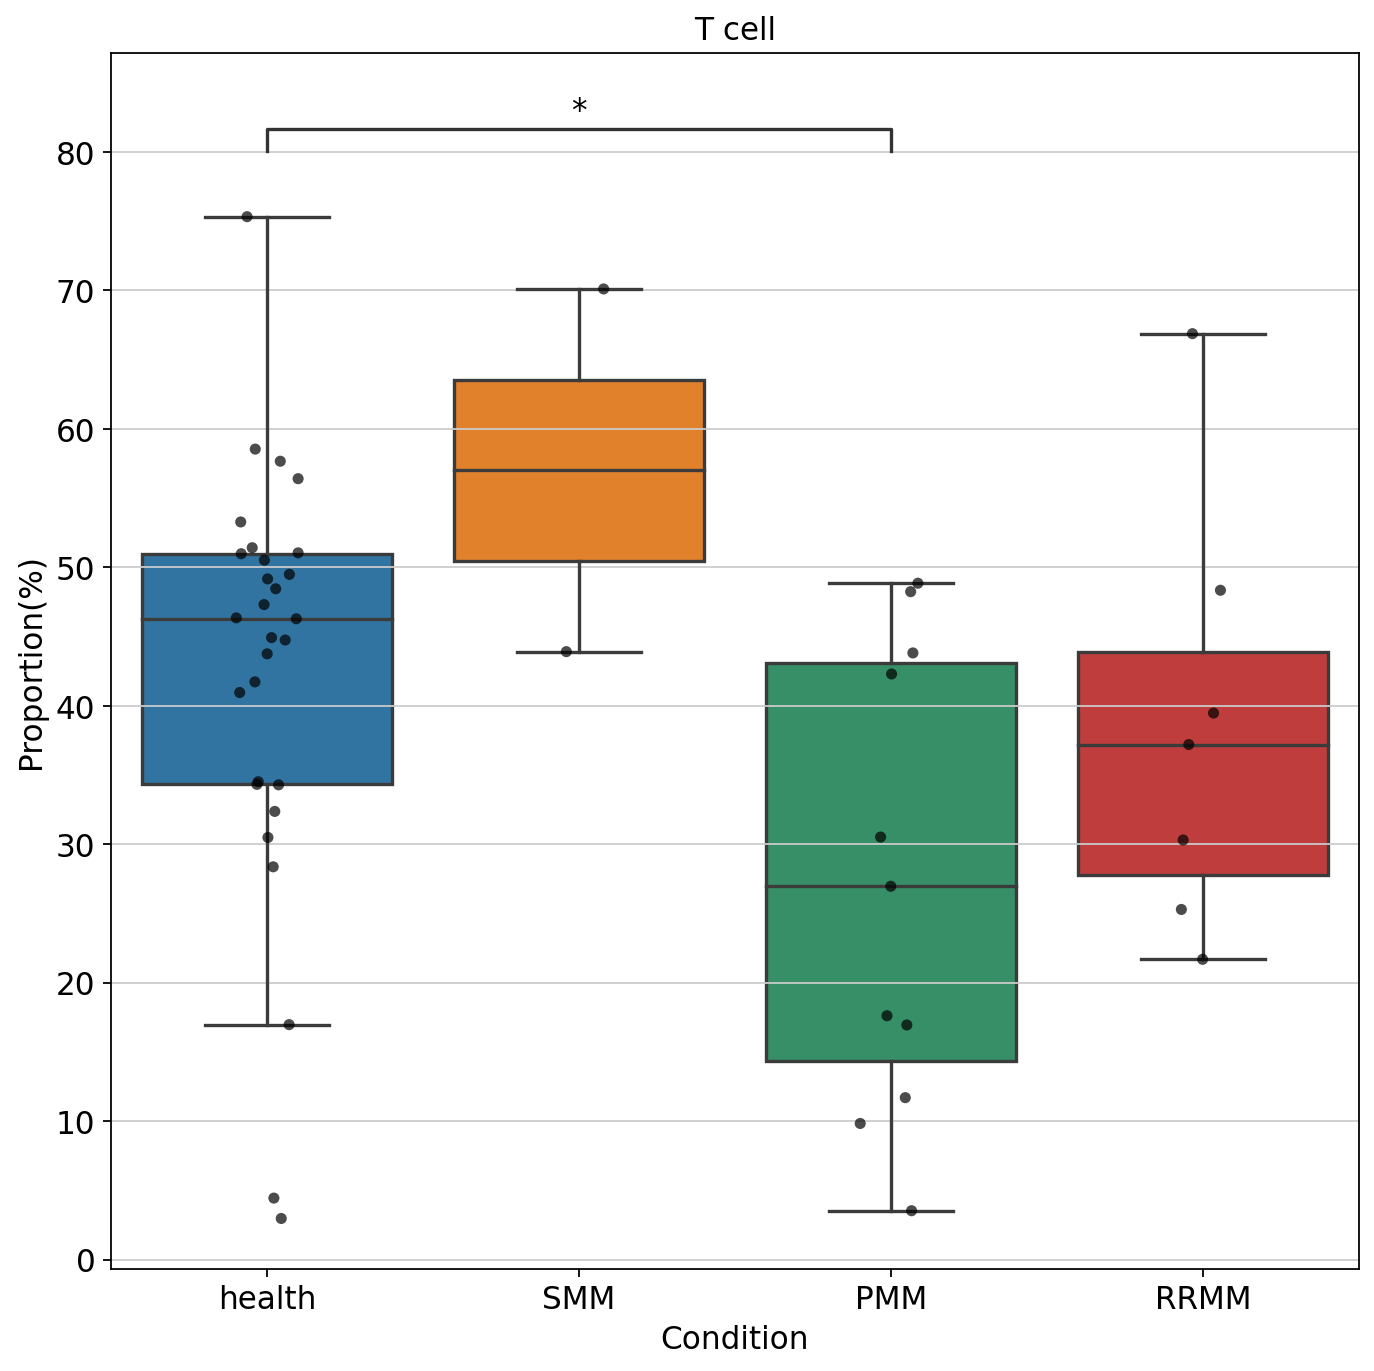

Text(0.5, 1.0, 'cDC')

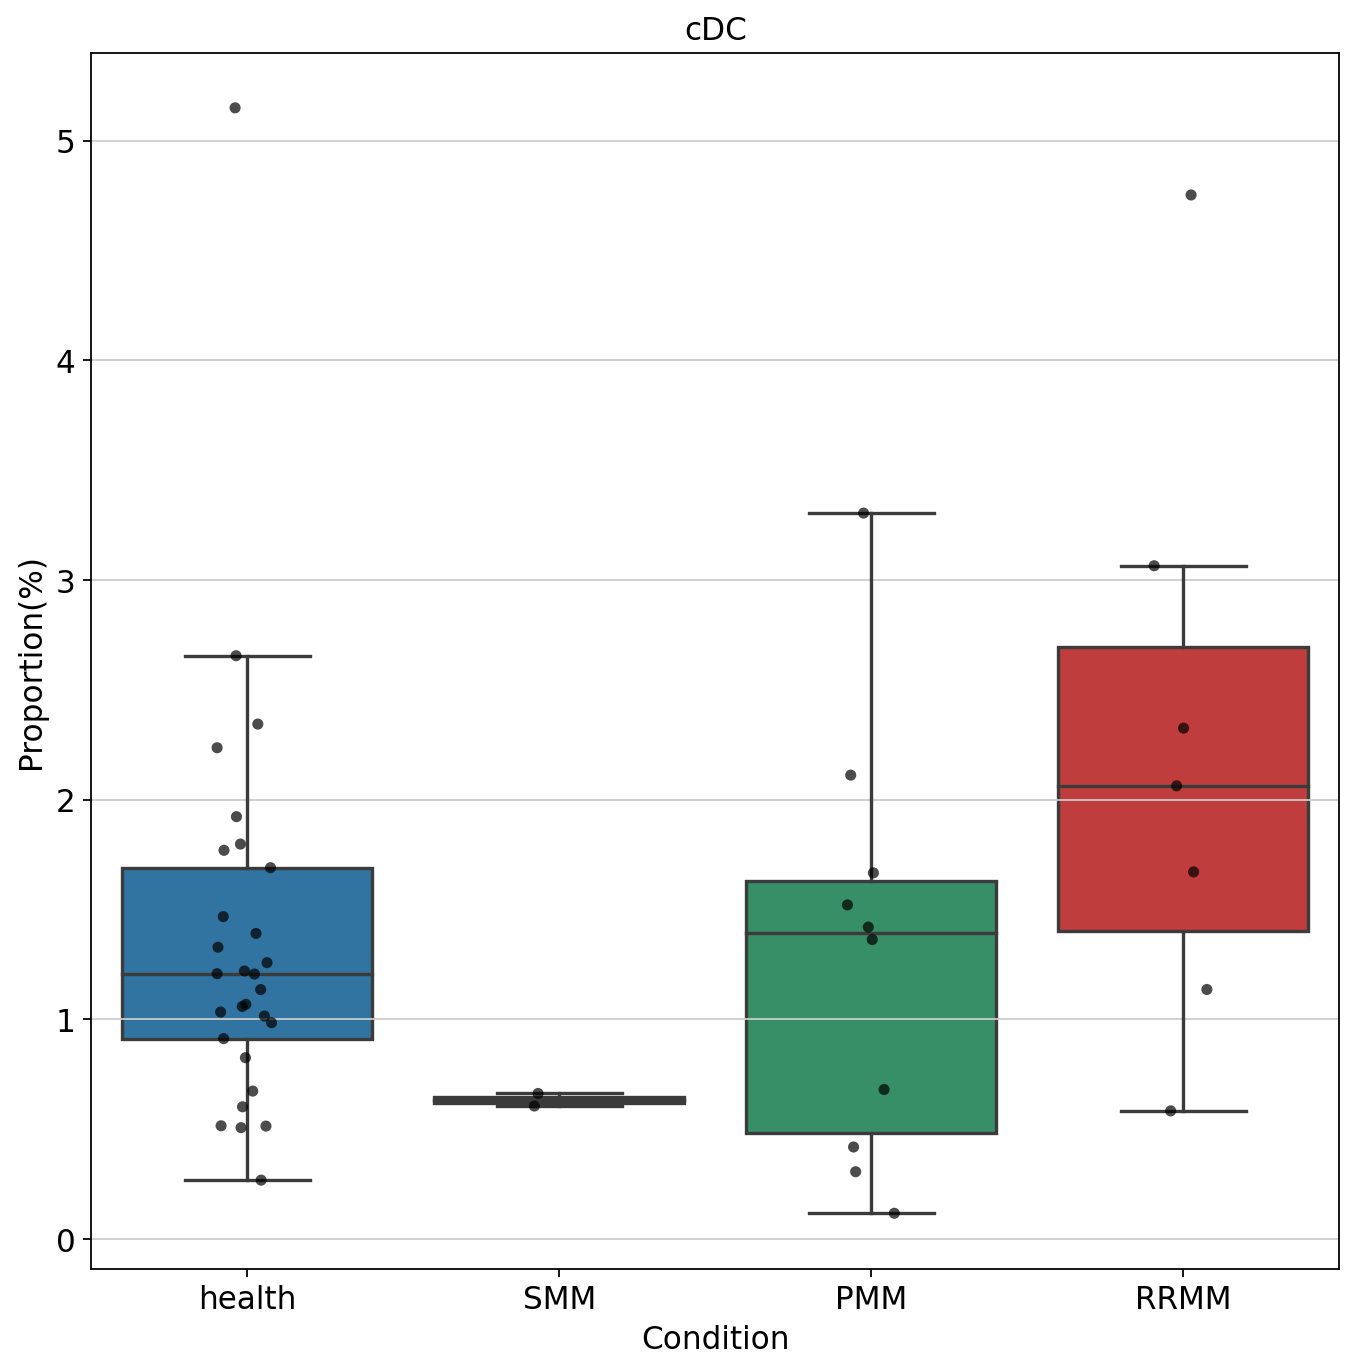







p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

health vs. PMM: Custom statistical test, P_val:1.009e-03
health vs. RRMM: Custom statistical test, P_val:2.238e-03


Text(0.5, 1.0, 'erythrocyte')

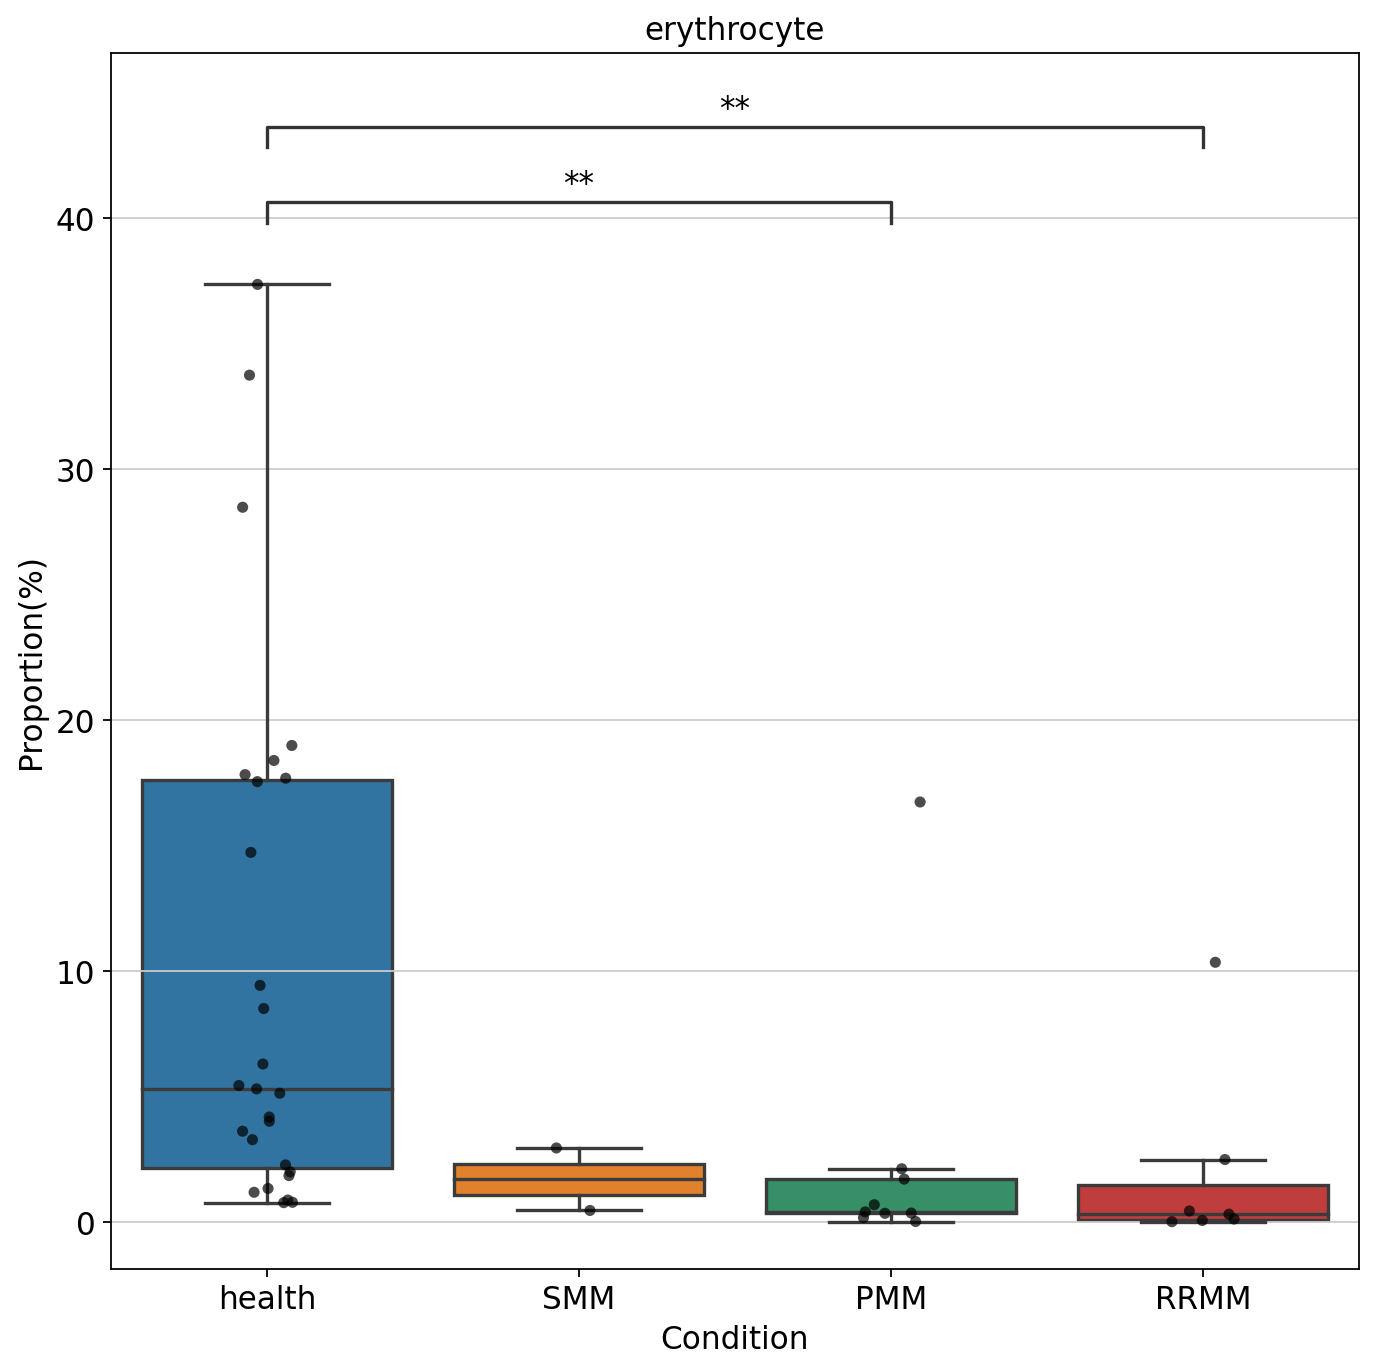

Text(0.5, 1.0, 'pDC')

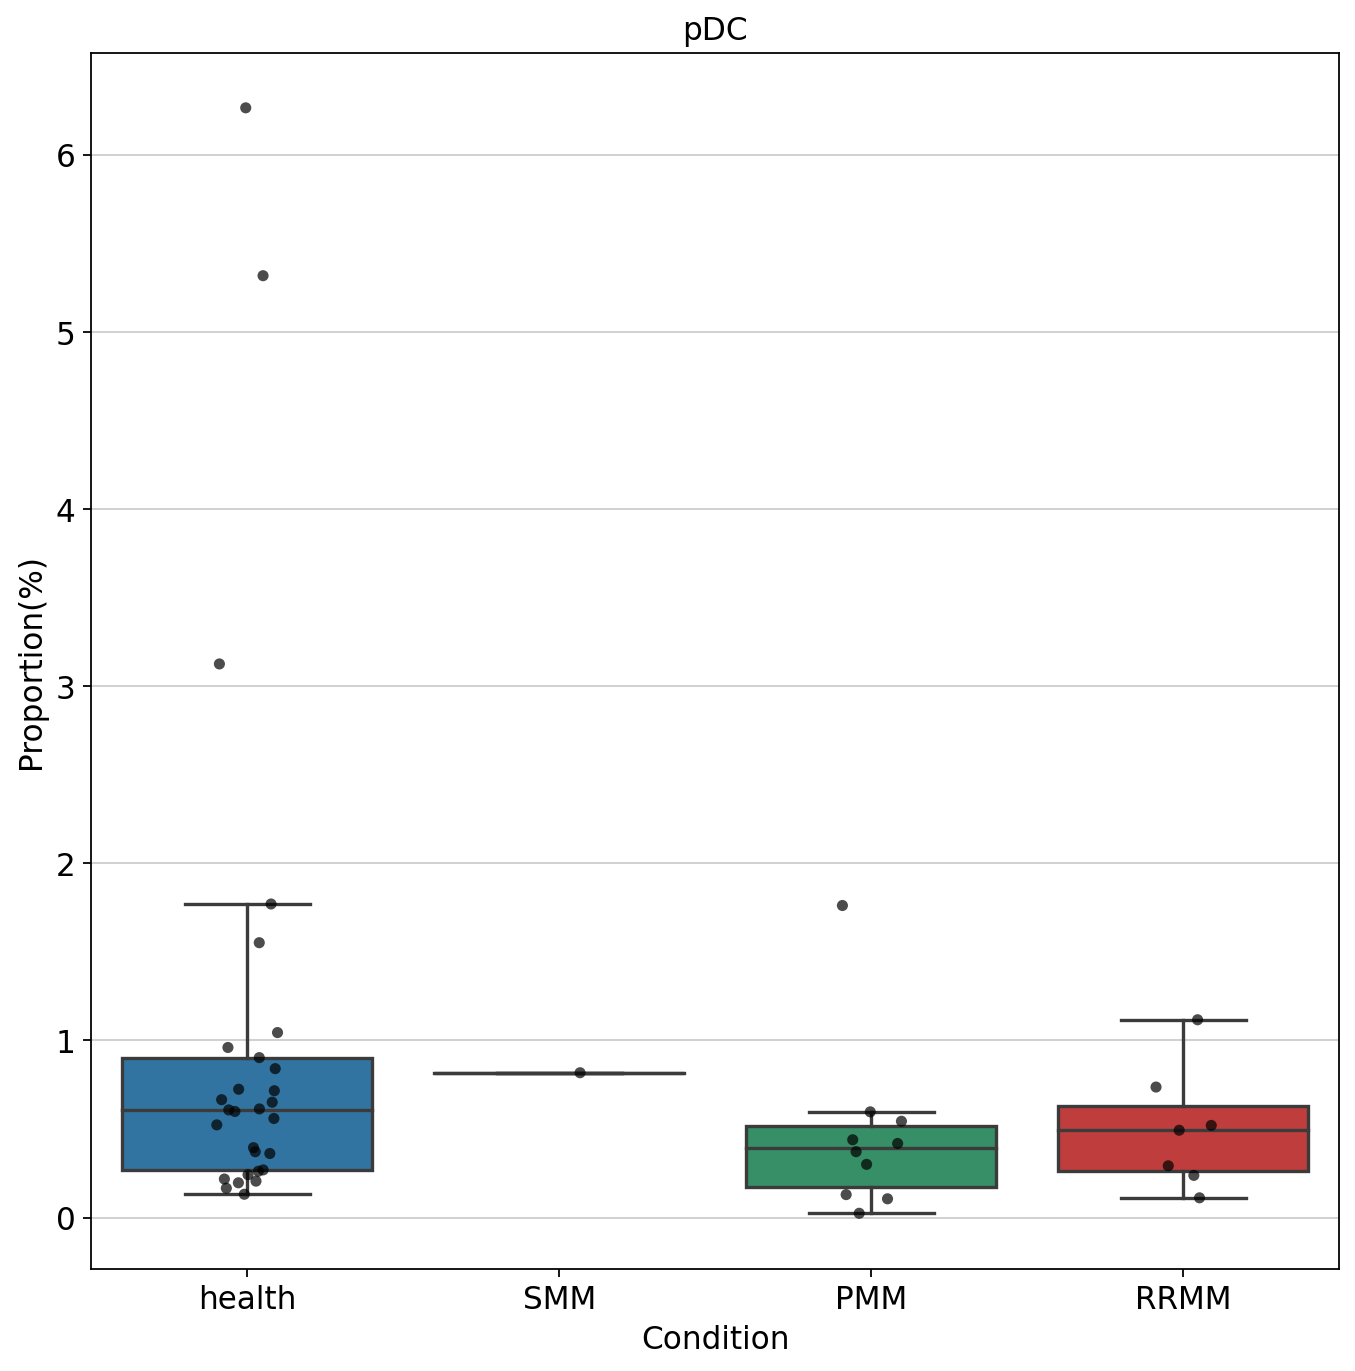







p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

health vs. PMM: Custom statistical test, P_val:1.387e-04
health vs. RRMM: Custom statistical test, P_val:1.338e-04


Text(0.5, 1.0, 'promyelocytes')

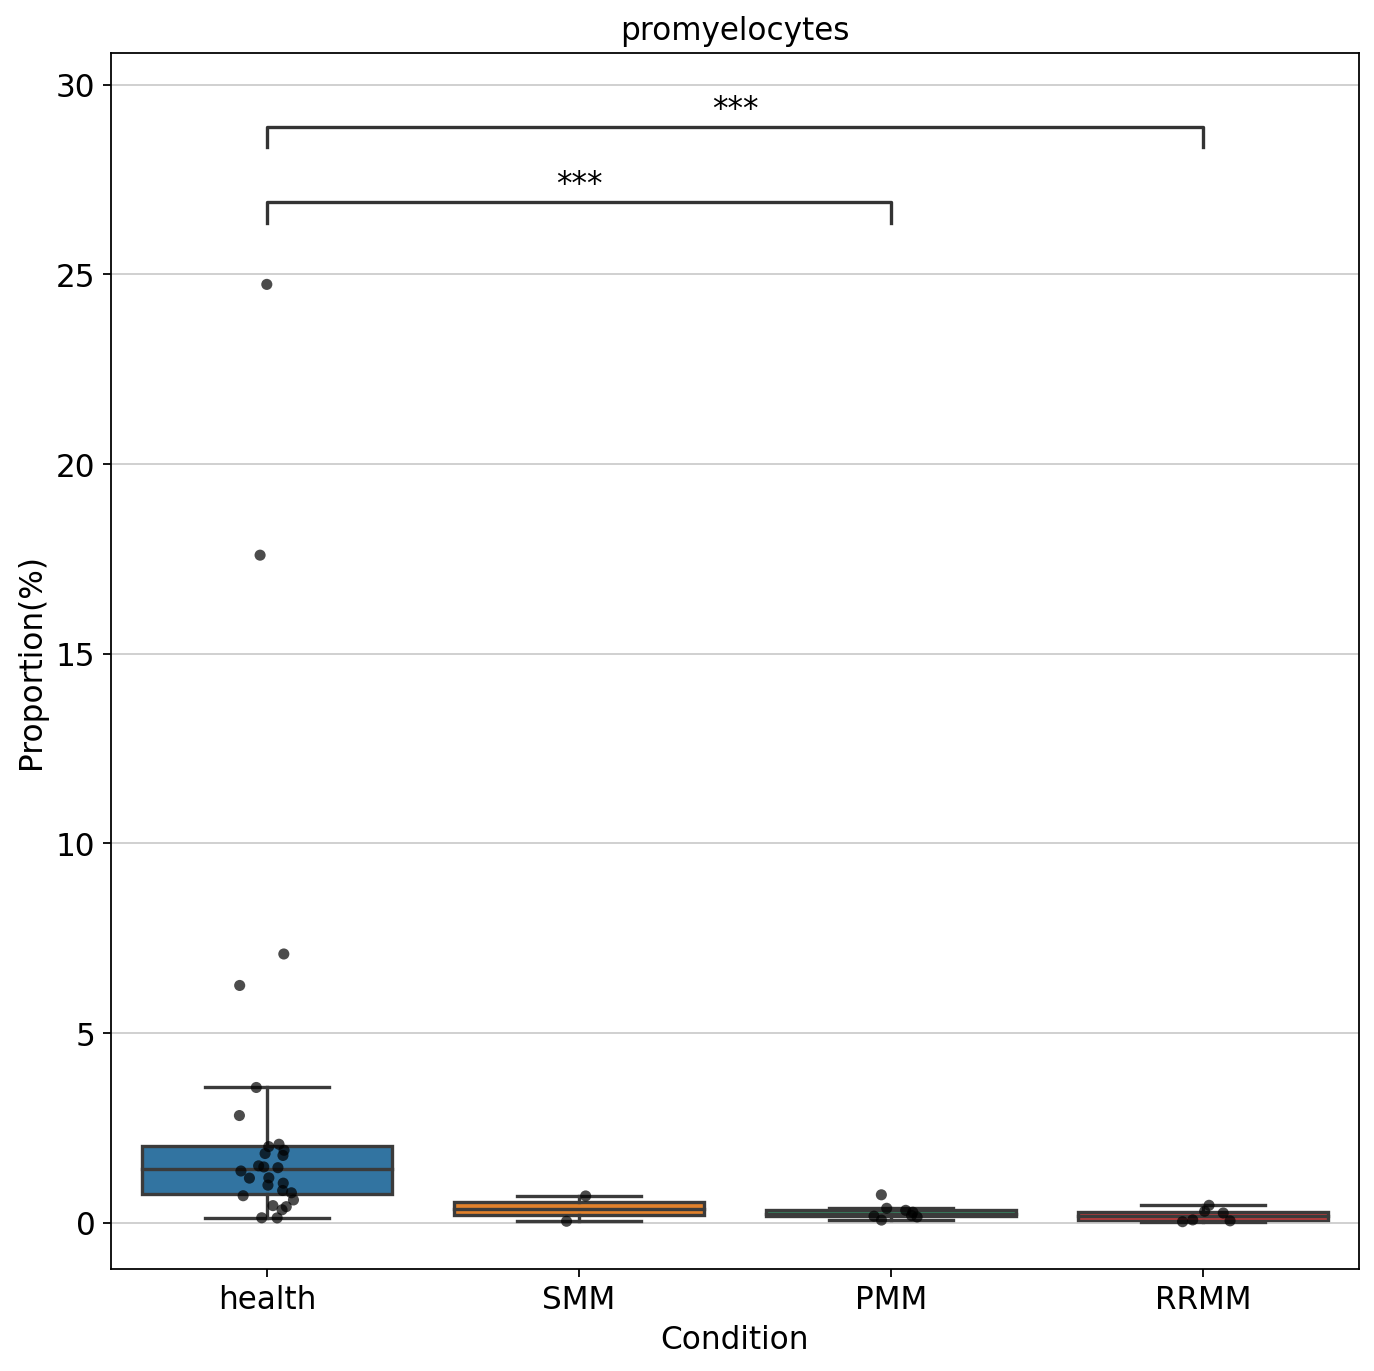

In [23]:
significant = statistics()

# Discussion

Looking at the proportions of cell along the disease stages and comparing them with the heakthy control is possile to draw some conclusions:
- Some (half) of the BM cells sub populations significantly change during the disease progression
- Cells from the same linneage but in different stages can show or not show significant differences (e.g promyelocytes vs myelocytes, Pre B vs B vs Plasma cells)
- Immune cells (innate and adaptive) can change or not, suggesting that the immune suppression doesn't derive from a reduced number of immune cell. Instead, it could derive from the exhaustion/inhibition of these cells against cancer cell.
- B linneage:
    - Pre B cells looks significantly reduced in the disease stages
    - B cells doesn't show diffeences among the conditions
    - Plasma cells are increased in the disease conditions
- T cells show high variance in the healthy control and fluctuations during the disease


# Conclusions

Althoug some cell types directly involved in MM (Plasma cells) show significant differences in the disease stages, with increased numbers in the symptomatic stages. Other cell types, even in the same linneage), doesn't show significant differences. The incapacity of the immune system to overcome the cancer cells doesn't derive from reduced numbers of them but, probably, from a reduction of their activity. In some cases (e.g. NK cells) could be interesting to observe if the sub-types changes during the disease progression. Considering the results, the next steps will be to trace the differentiation trajectories between disease and healthy samples, from the obtained categories DGE and Pathways analysis will help to find those cells are active or exhausted and the key events that drives the immune suppression.

# Supplementary

a glimpse at the single cell types

In [24]:
def proportions(adata, batches): # create dataframe with cell types proportion for the given batches
    df = pd.DataFrame() # create empty dataframe
    for b in batches: #iterate along all the batches desired
        temp = adata[adata.obs.batch == b] # create temporary file with cell from desired batch
        cells = temp.obs.label.value_counts() # get counts
        total_cells = cells.sum() # sum cells
        proportions = (cells/total_cells)*100 # get percentage 
        df = df.append(proportions) # append the cell proortions of the give batches to the df (as rows)
    df.index = batches # rownames as batches
    return df

def celltype(label,condition,table): # create tidy (long) dataframe of the cell proportion for the given cell type
    cell_type = {} # create empty dictionary
    for i in range(0,len(condition)): # iterate along the conditions
        cell_type[condition[i]] = table[i][label].values.tolist() #extract the proportion of the desired cell type
    cell_type = pd.DataFrame.from_dict(cell_type, orient="index").transpose() # convert to pandas dataframe
    cell_type["cell"] = label # add column with cell type
    cell_type_long = pd.melt(cell_type, id_vars="cell", value_vars=condition) # pivot longer
    return cell_type, cell_type_long

# let's do some statistics:
#def statistics():
#    for cell in list_cells:
#        array = []
#        for con in conditions:
#            array.append(cell_proportions[cell][con].tolist()) # create array with values for each condition
#        H, p = ss.kruskal(array[0],array[1],array[2],array[3], nan_policy="omit") # Kruskal-Wallis non-parametric test (variances are different between groups) and differs in number of observations
#        if p >= 0.05:
#            print("%s not showed statistically significant differences among the conditions: %f!\n" % (cell,p))
#        else:
#            posthoc = sp.posthoc_wilcoxon(cell_proportions_long[cell], val_col="value", group_col="variable", p_adjust="fdr_bh") # non normally distributed
#            print("%s showed statistically significant differences among the conditions:\np-value: %f\nPost hoc test (wilcoxon), adj-pvalue(BH):" %(cell,p))
#            print(posthoc, "\n")



            
labels = pd.read_csv("general_labels.csv", header=None) #read csv used to convert cell labels
labels.columns = ["Cell type", "Major type"] # rename columns
list_cells = labels["Cell type"].sort_values().unique().tolist() #save unique major types for next steps

In [25]:
#Start with healthy
batches = healthy.obs.batch.unique().tolist() # healthy batches
health = proportions(healthy, batches) # get proportions

# SMM
batches = adata_bm.obs.batch.unique().tolist() # get batches from MM dataset (BM)
batches = [x for x in batches if 'SMM' in x] # keep only those who contains SMM
SMM = proportions(adata,batches) # get proportions

# PMM
batches = adata_bm.obs.batch.unique().tolist()
batches = [x for x in batches if 'PMM' in x]
PMM = proportions(adata,batches)

# RRMM
batches = adata_bm.obs.batch.unique().tolist()
batches = [x for x in batches if 'RRMM' in x]
RRMM = proportions(adata,batches)

conditions = ["health", "SMM", "PMM", "RRMM"] # list conditions as string
tables = [health, SMM, PMM, RRMM] # list of conditions dataframes


cell_proportions = {} #create new empty dictionary to iterate all the cell types
cell_proportions_long = {}

for c in list_cells:
    cell_proportions[c], cell_proportions_long[c] = celltype(c, conditions, tables)

cells = pd.concat(cell_proportions_long,ignore_index=True) # concatenate the cells
cells.columns = ["cell", "condition", "proportions"]


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

health vs. PMM: Custom statistical test, P_val:1.009e-03
health vs. RRMM: Custom statistical test, P_val:2.238e-03


Text(0.5, 1.0, 'Aberrant erythroid')

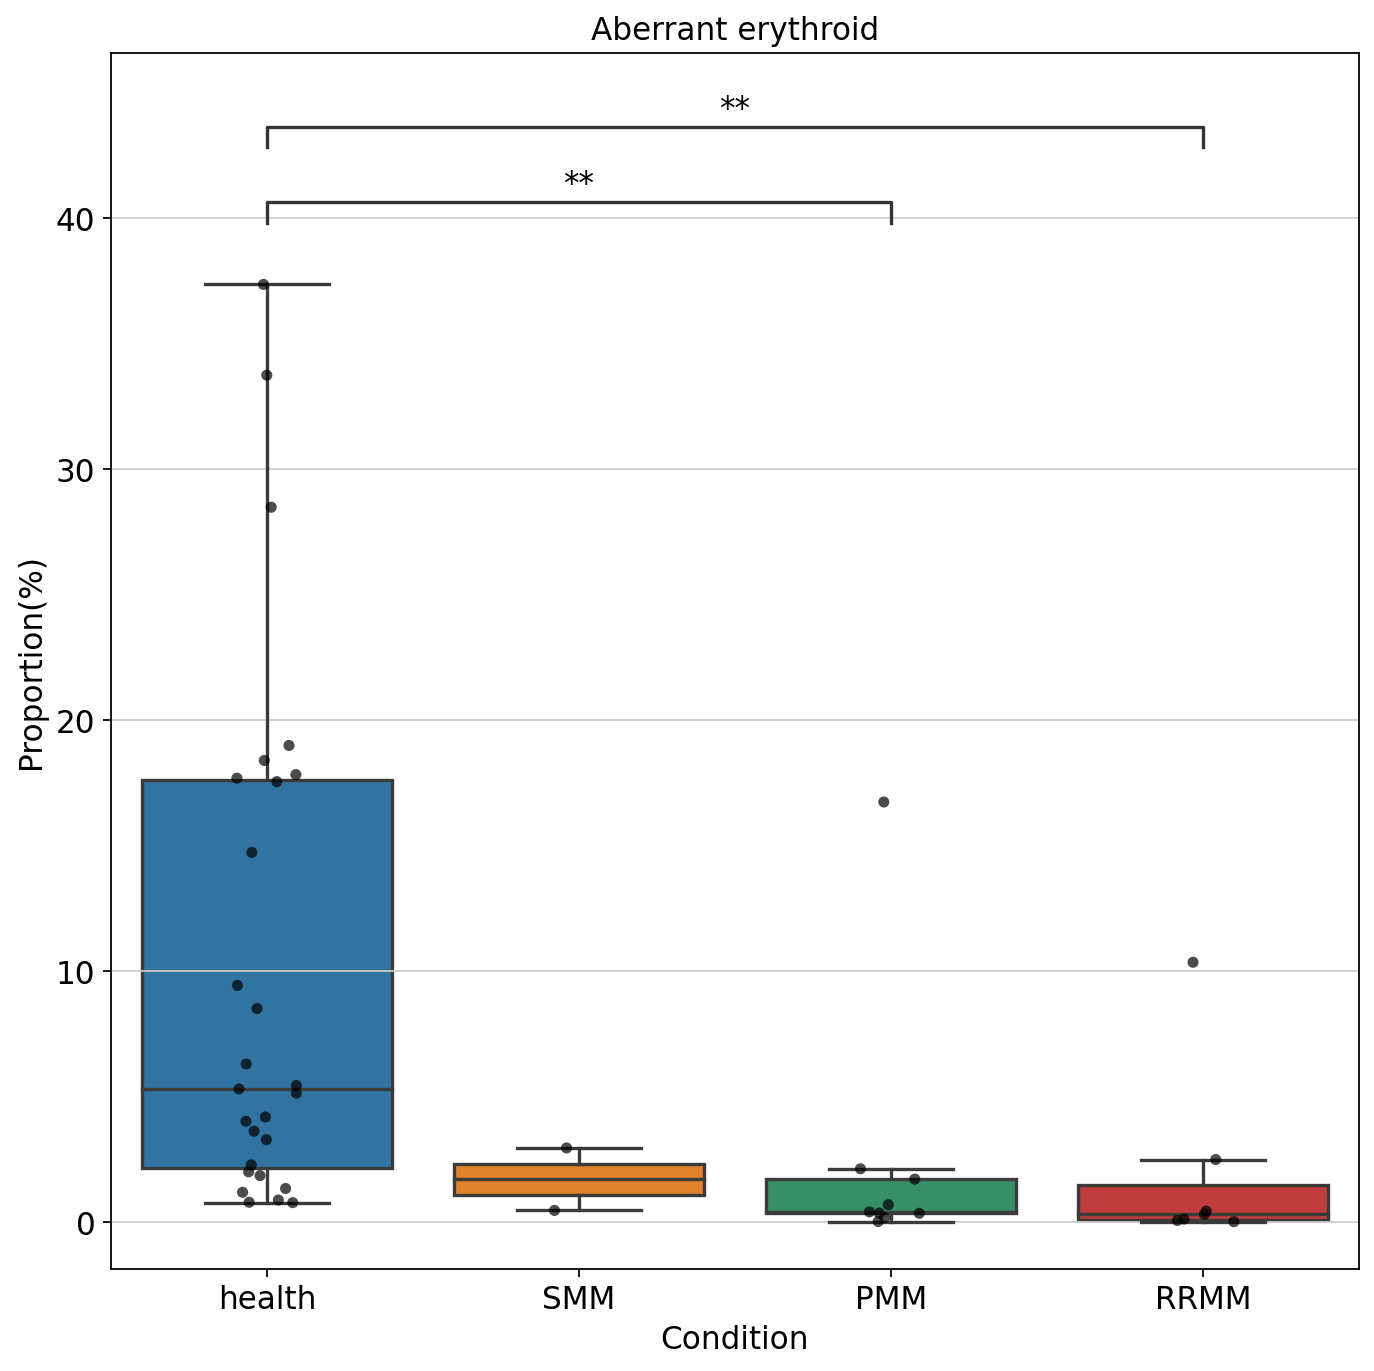







p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

health vs. PMM: Custom statistical test, P_val:3.185e-03


Text(0.5, 1.0, 'CD4+ memory T cells')

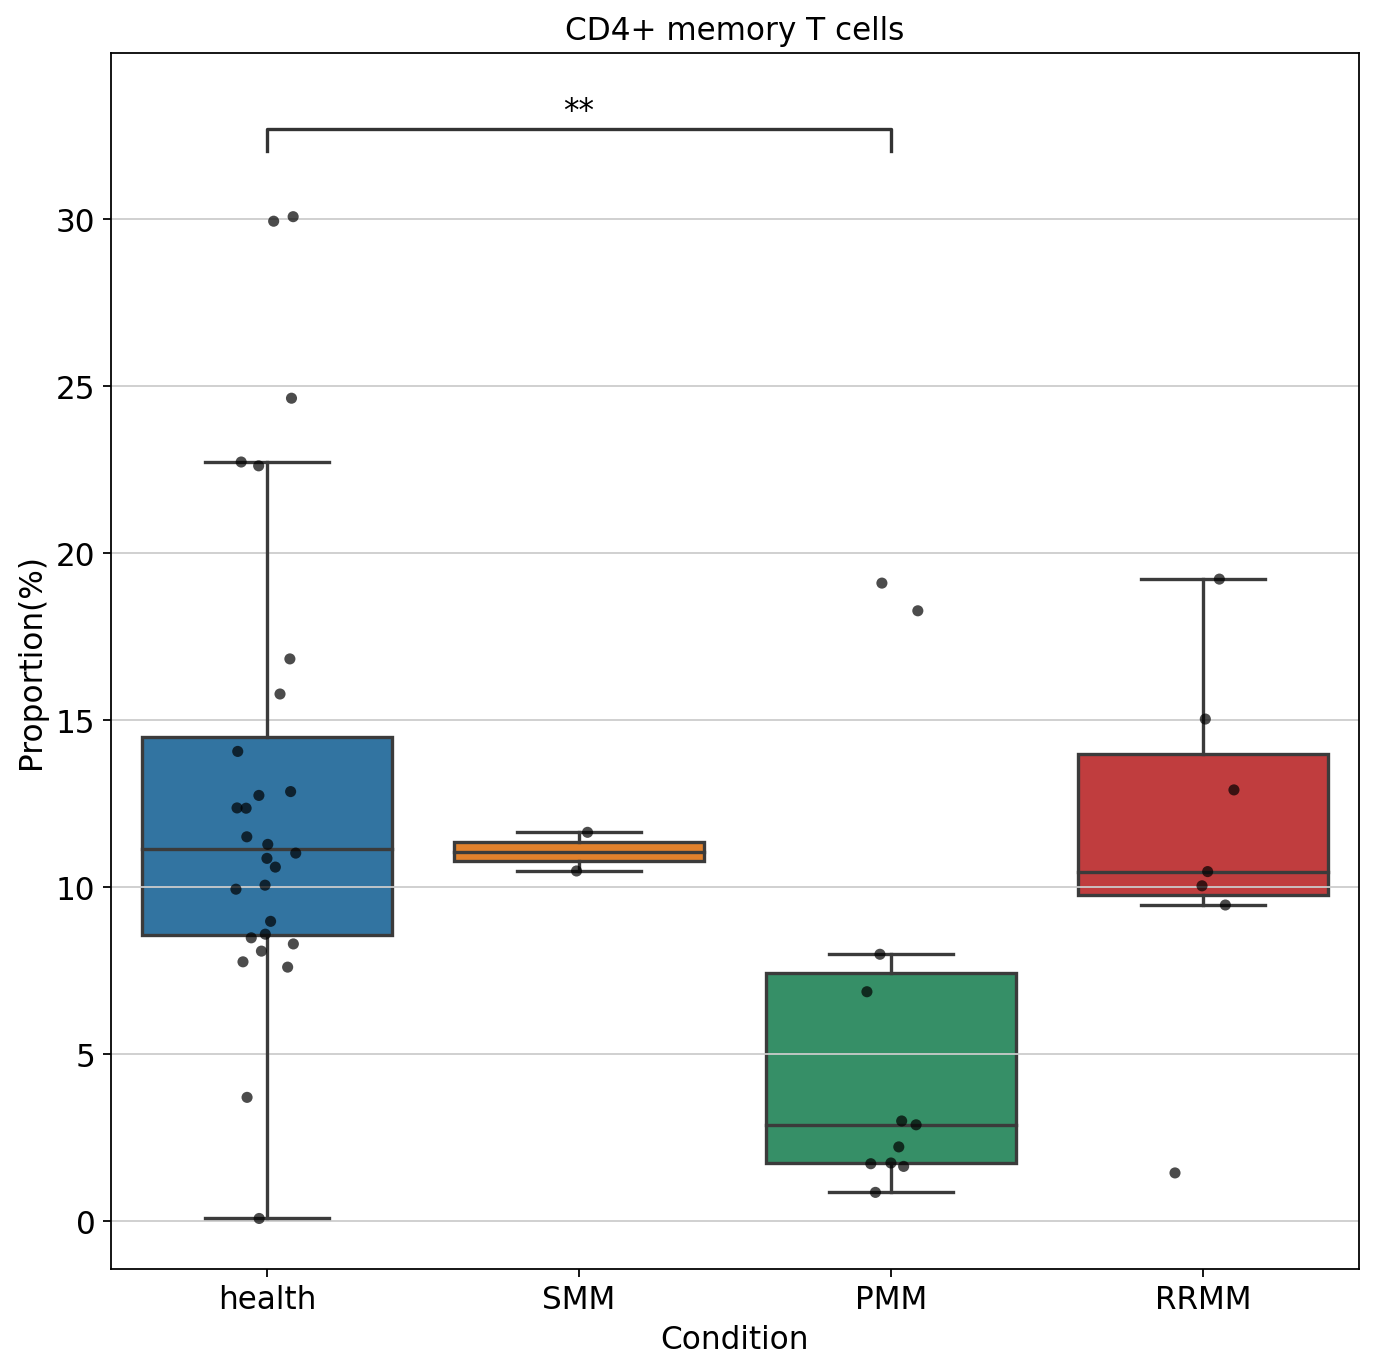

Text(0.5, 1.0, 'CD4+ naive T cells')

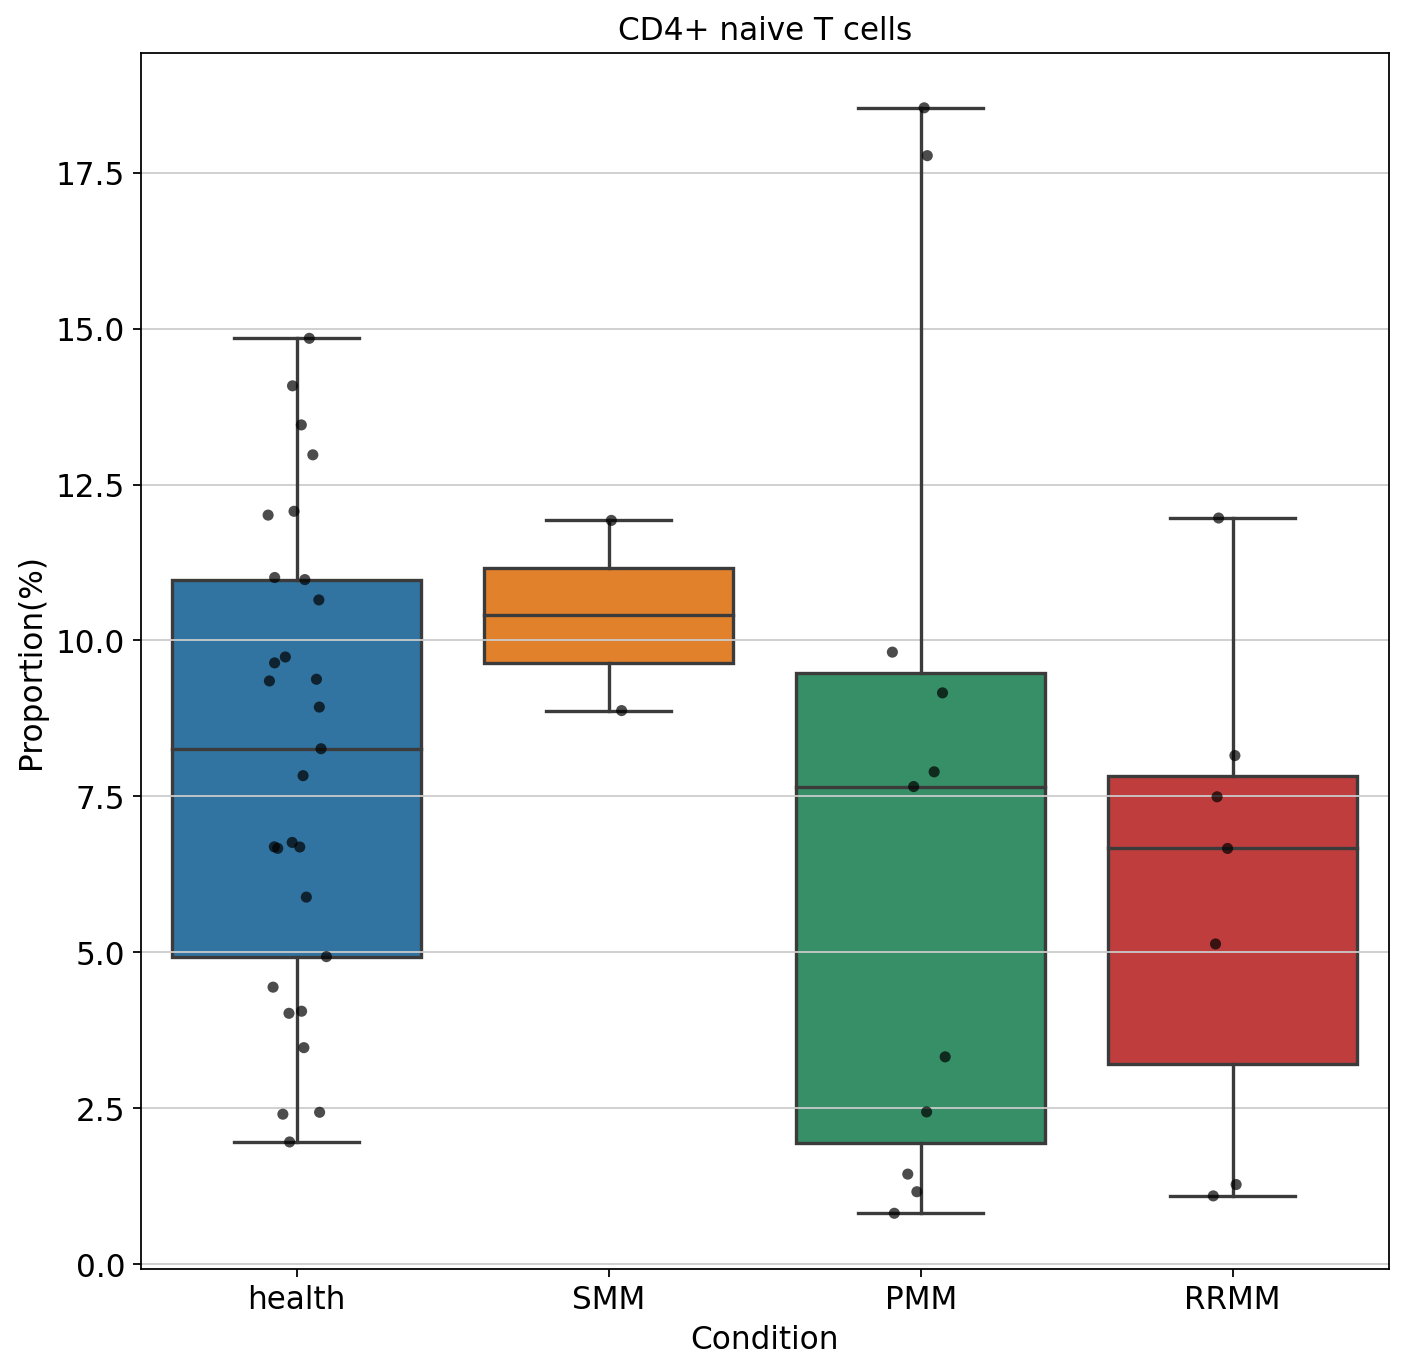







p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

health vs. RRMM: Custom statistical test, P_val:3.092e-02


Text(0.5, 1.0, 'CD56brightCD16- NK cells')

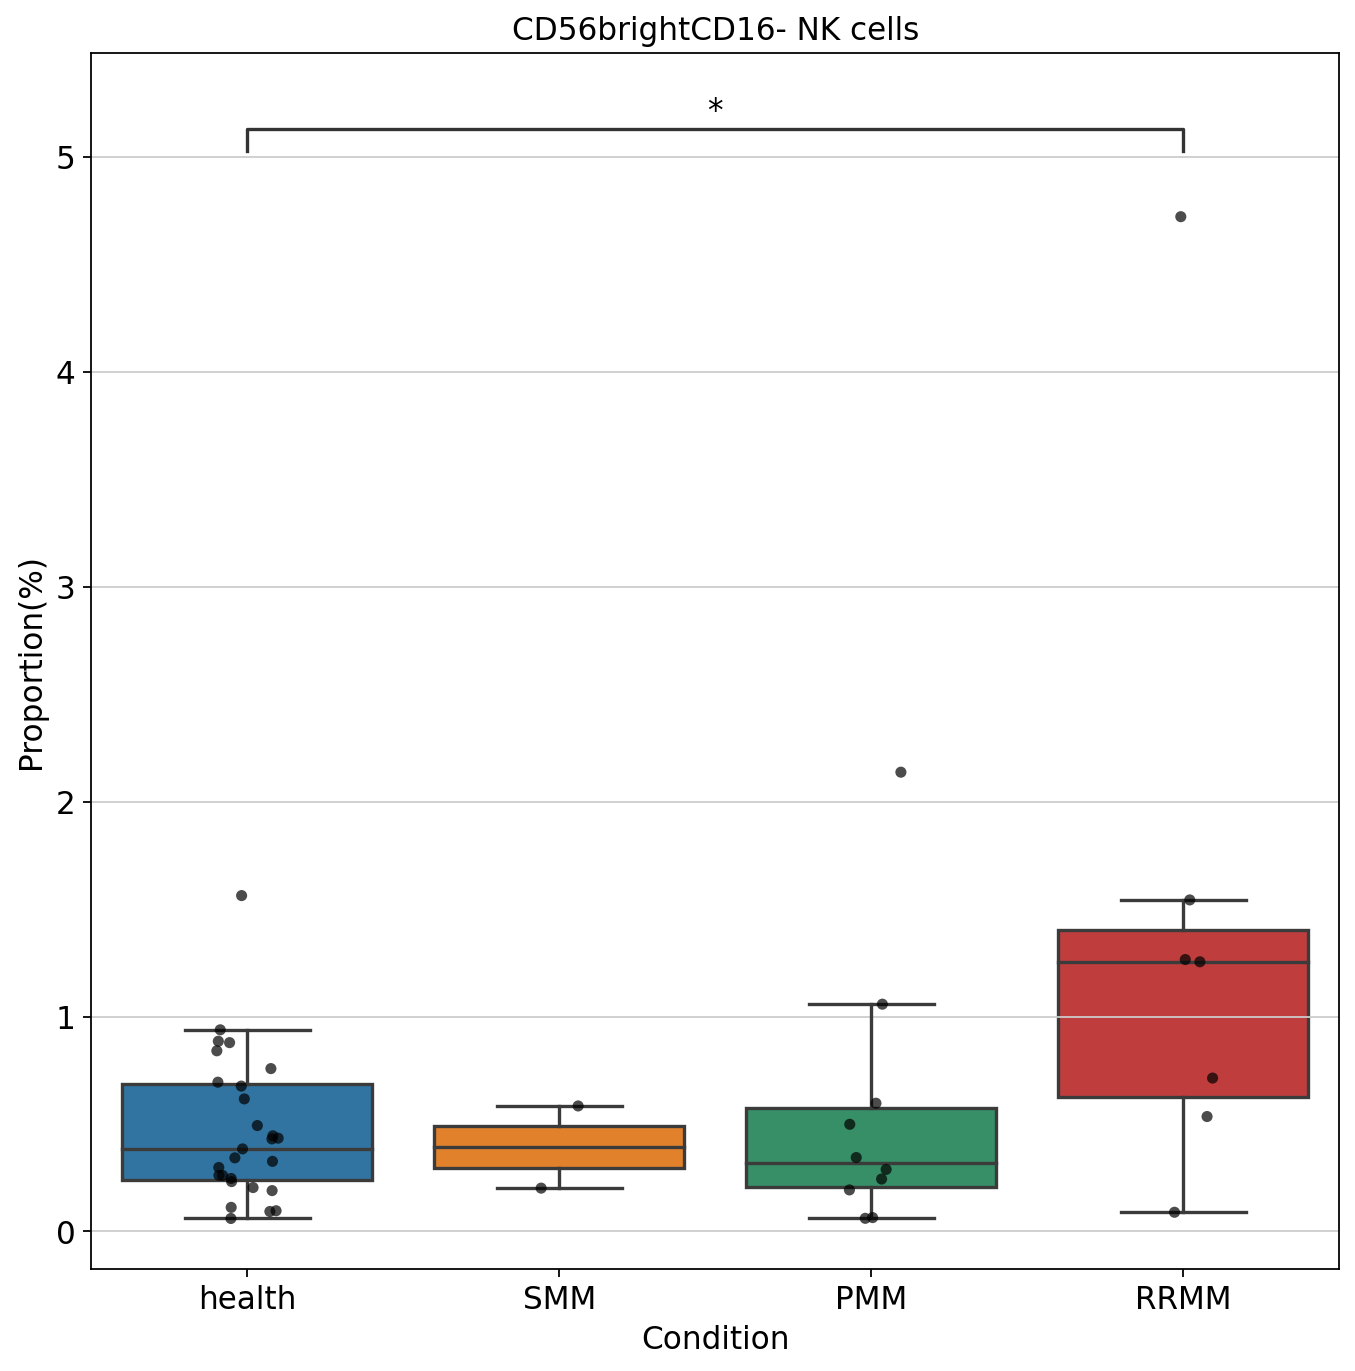

Text(0.5, 1.0, 'CD56dimCD16+ NK cells')

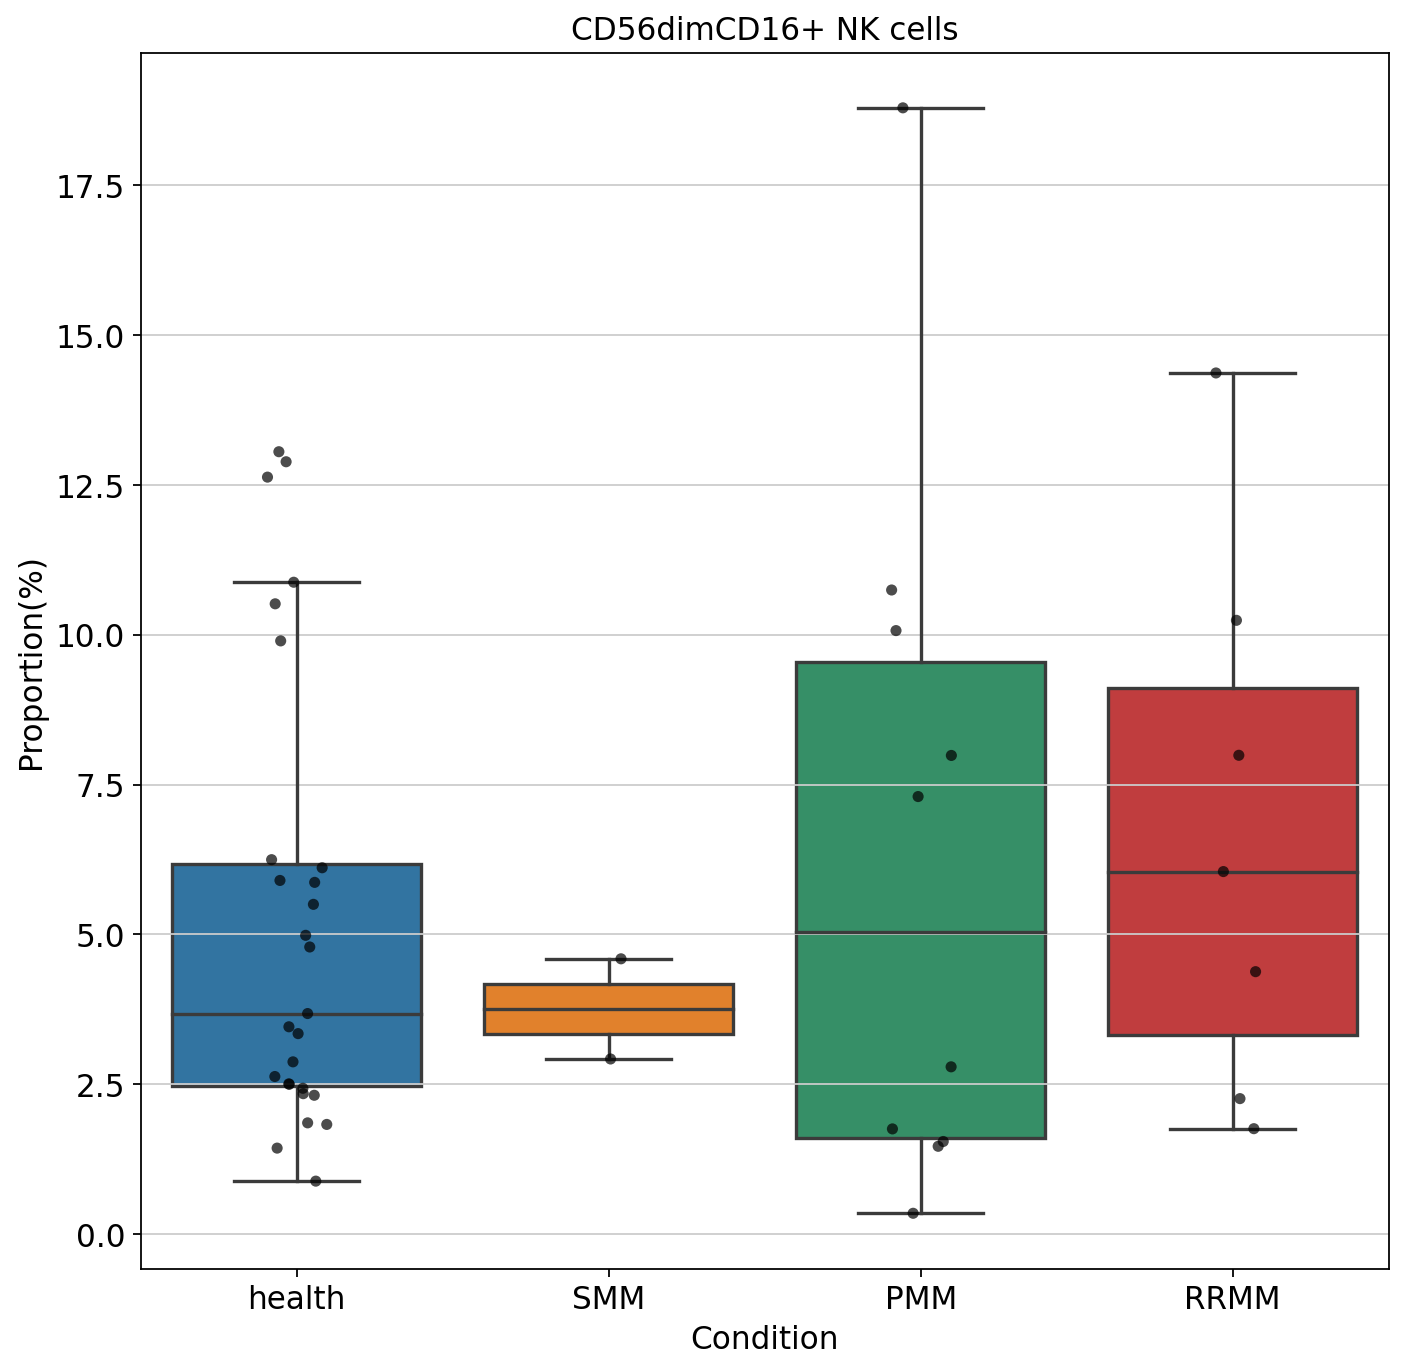

Text(0.5, 1.0, 'CD69+PD-1+ memory CD4+ T cells')

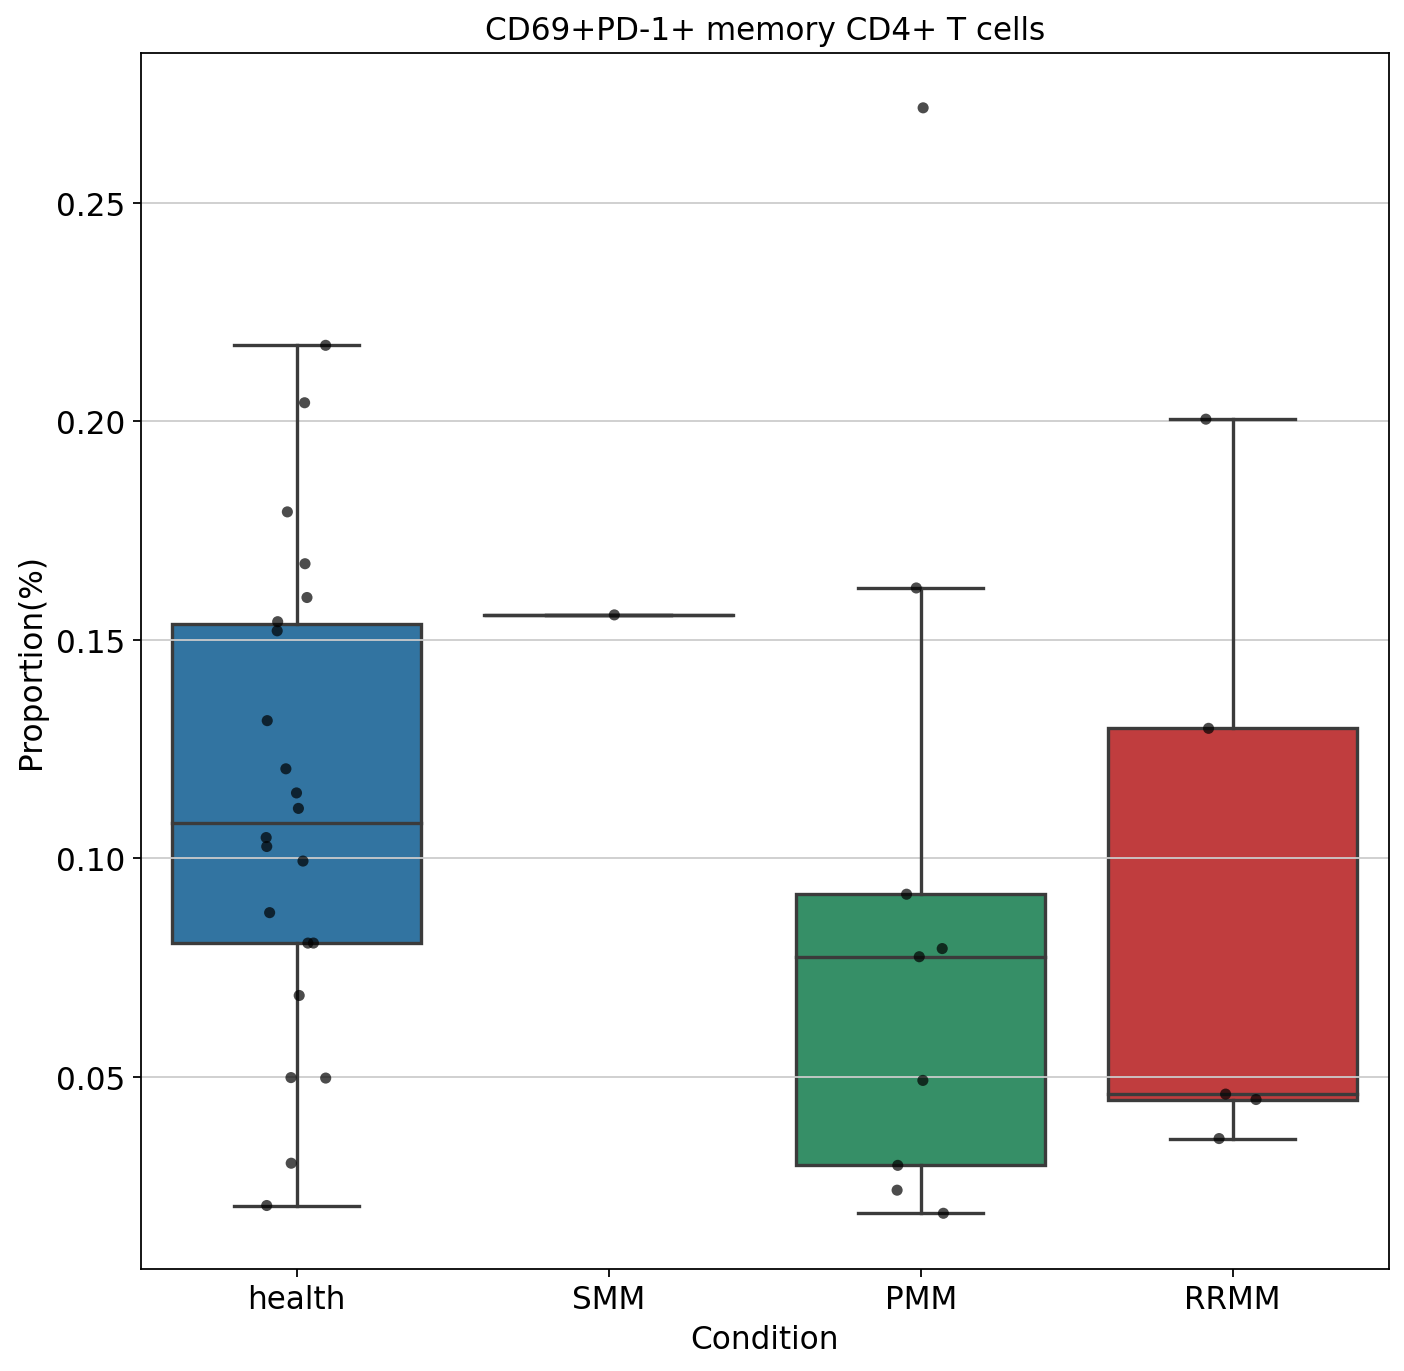

Text(0.5, 1.0, 'CD8+ central memory T cells')

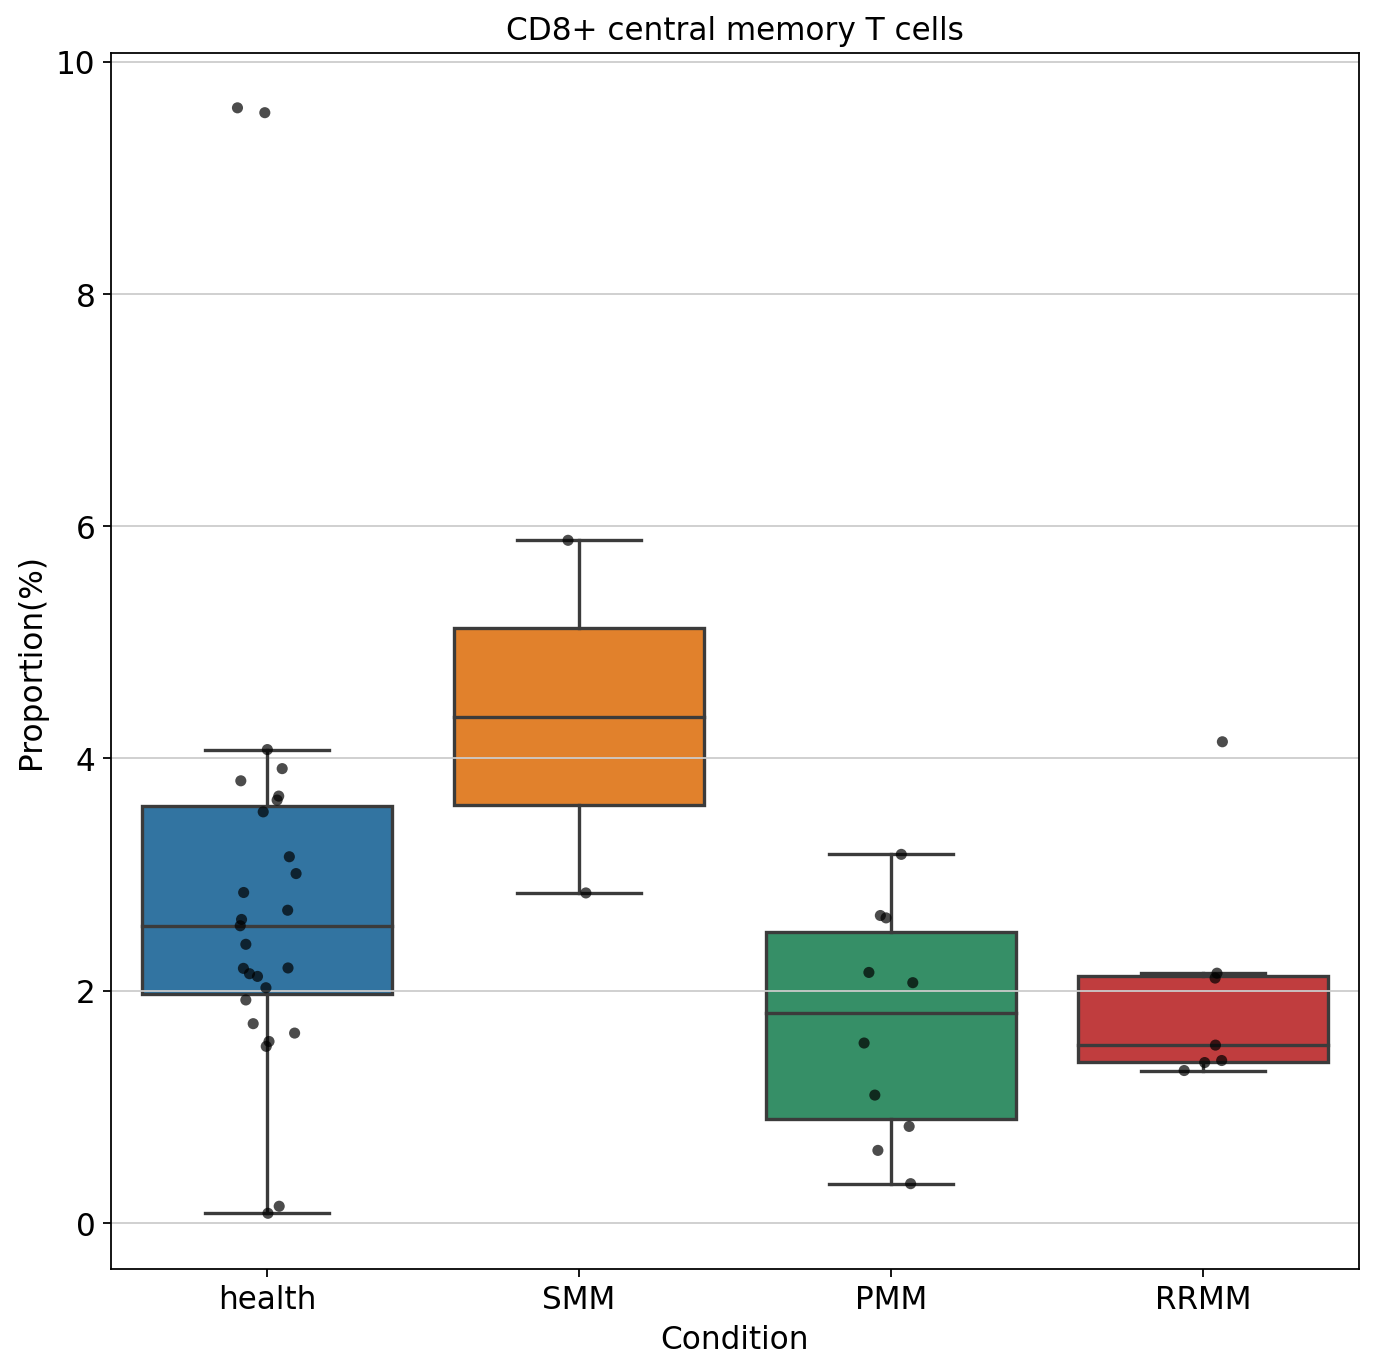

Text(0.5, 1.0, 'CD8+ effector memory T cells')

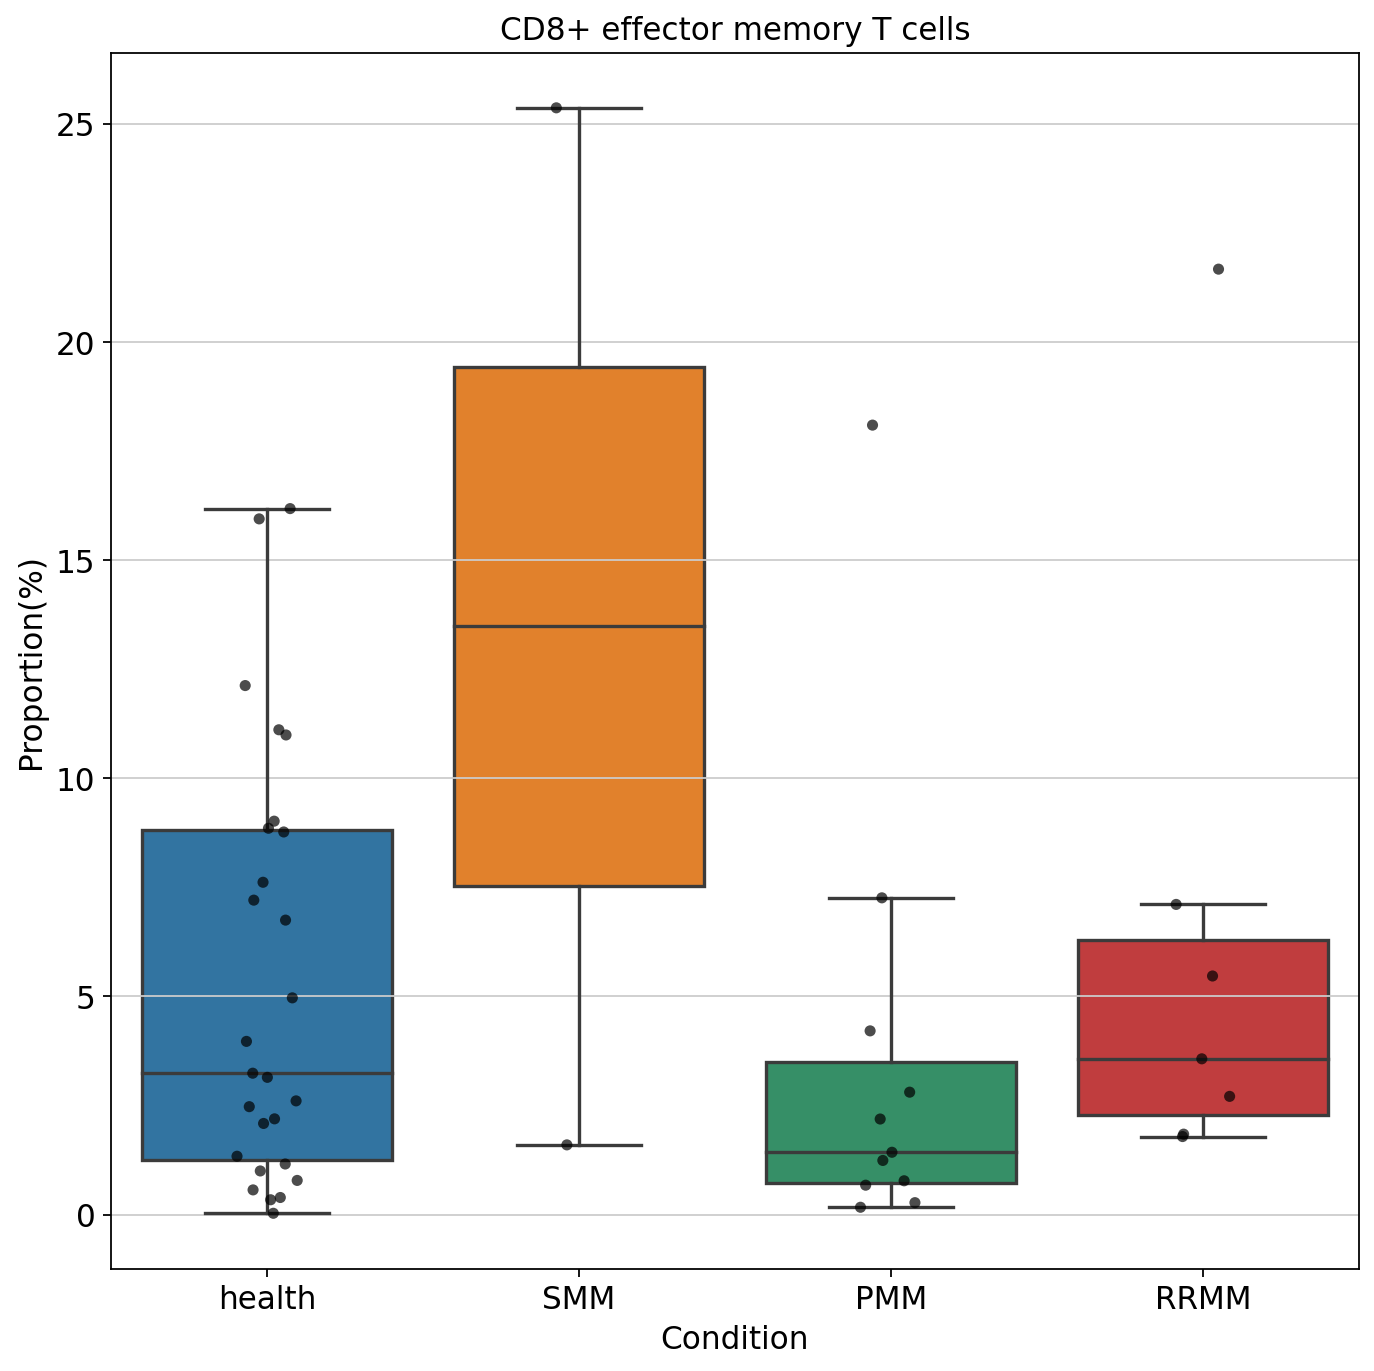

Text(0.5, 1.0, 'CD8+ naive T cells')

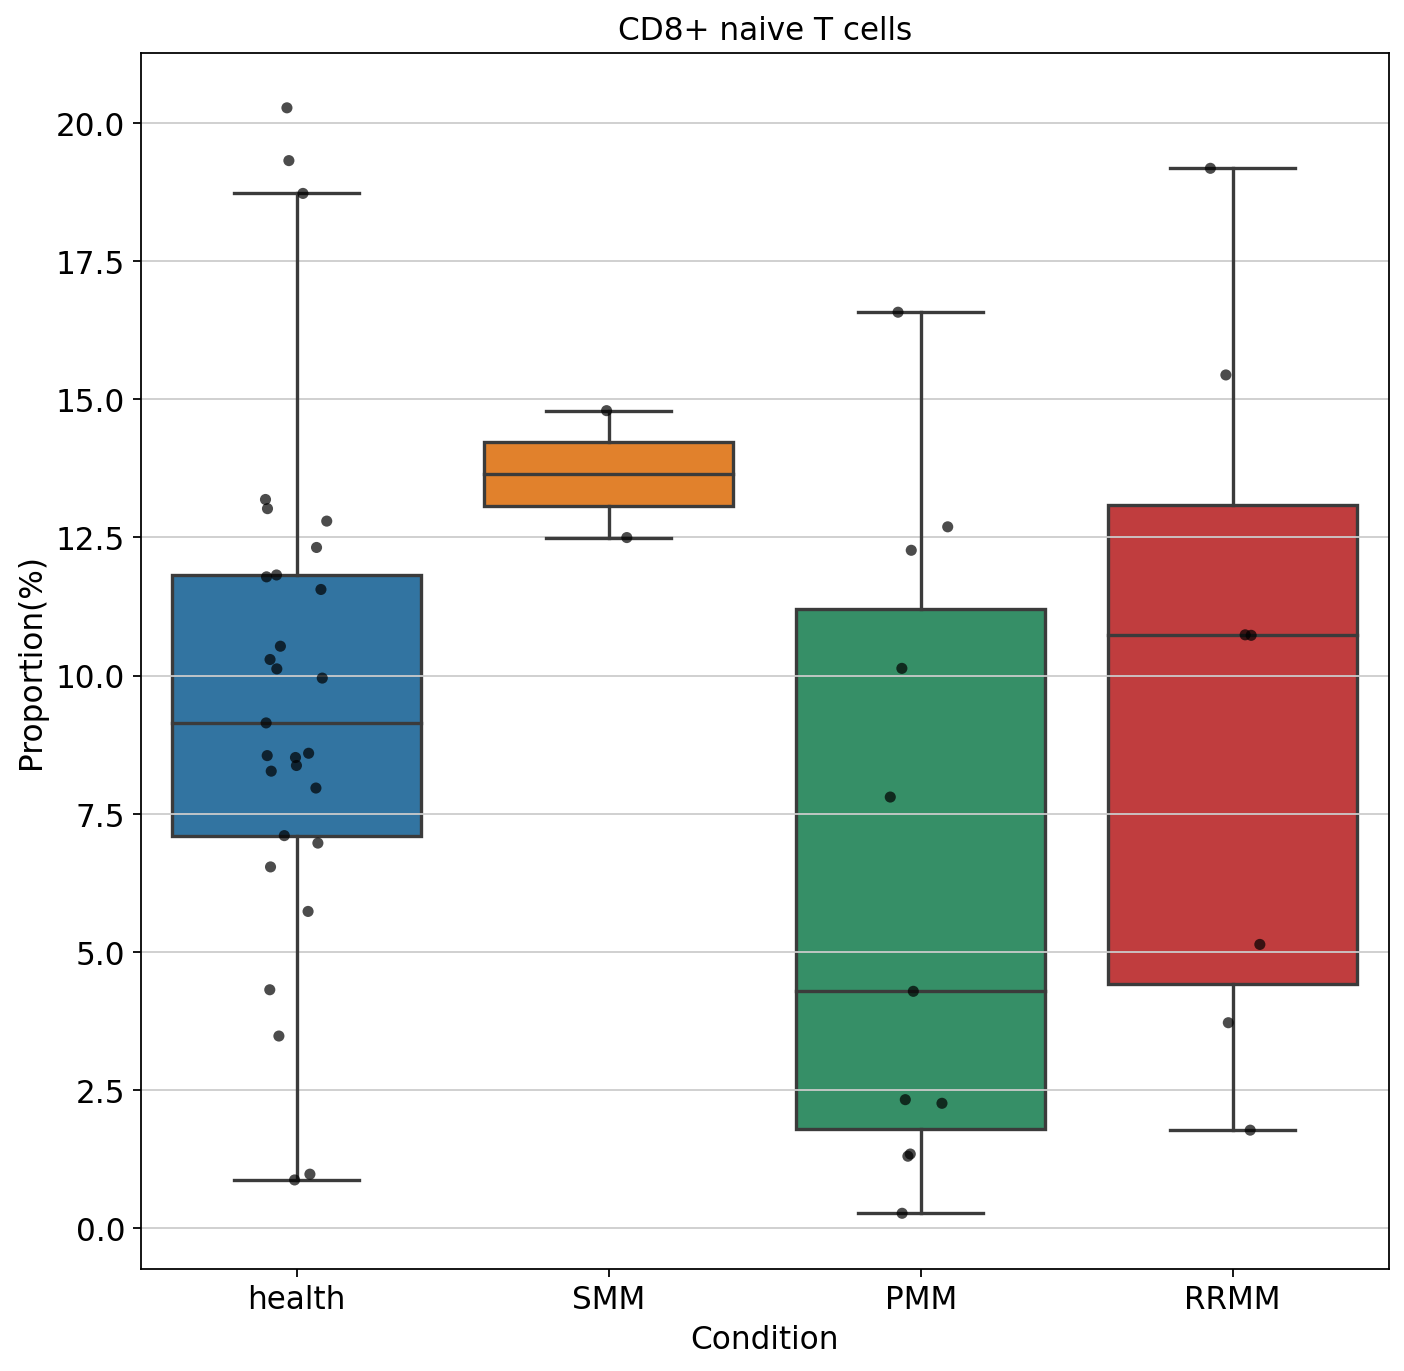







p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

health vs. PMM: Custom statistical test, P_val:1.448e-02


Text(0.5, 1.0, 'CD8+CD103+ tissue resident memory T cells')

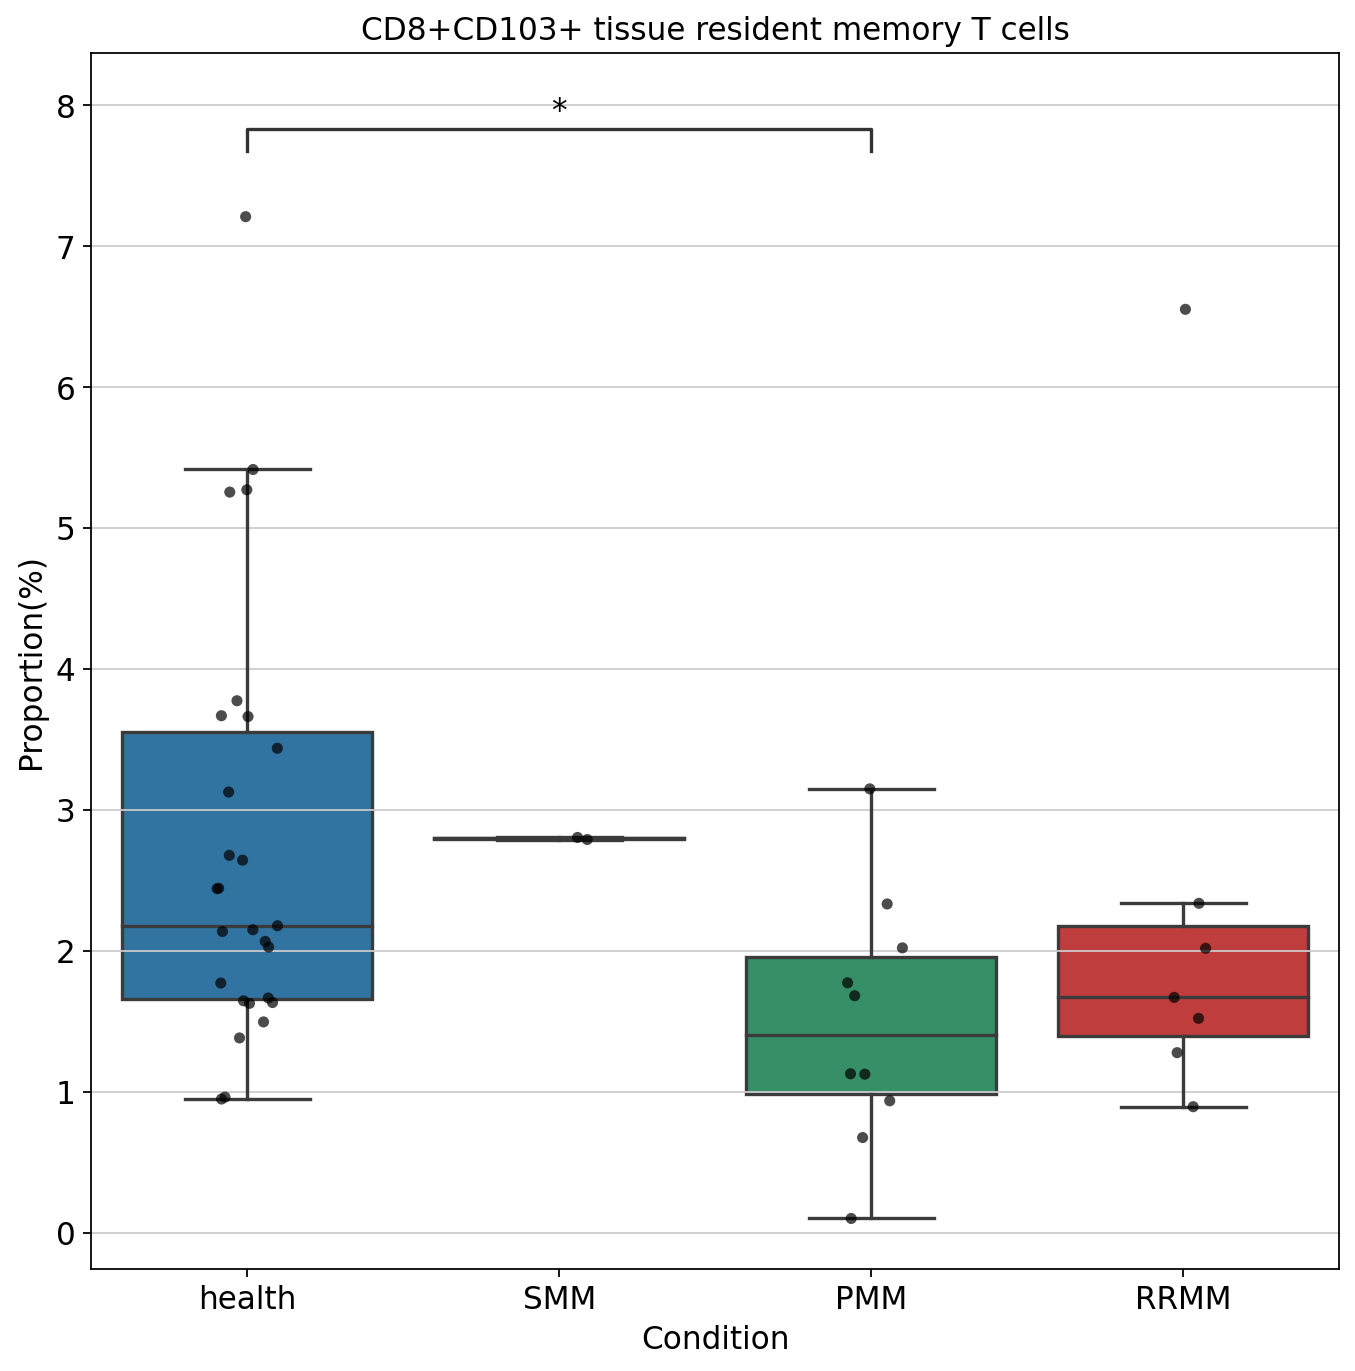

Text(0.5, 1.0, 'Class switched memory B cells')

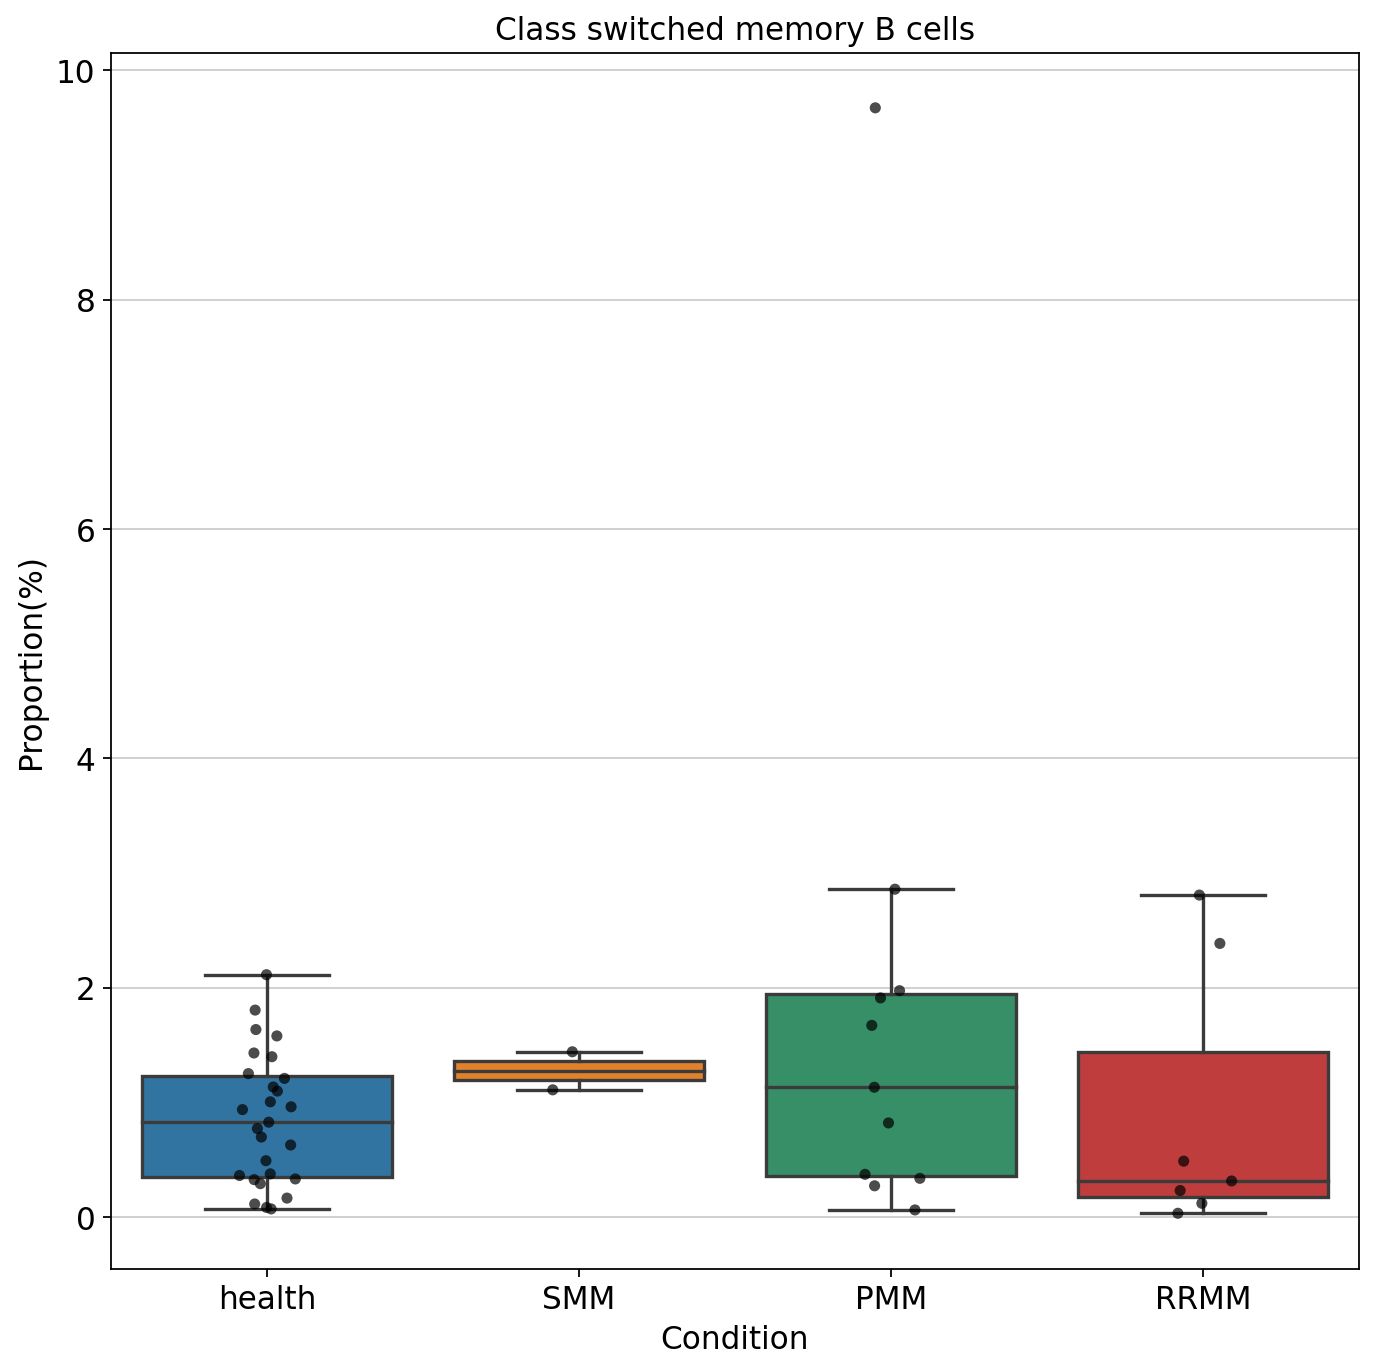

Text(0.5, 1.0, 'Classical Monocytes')

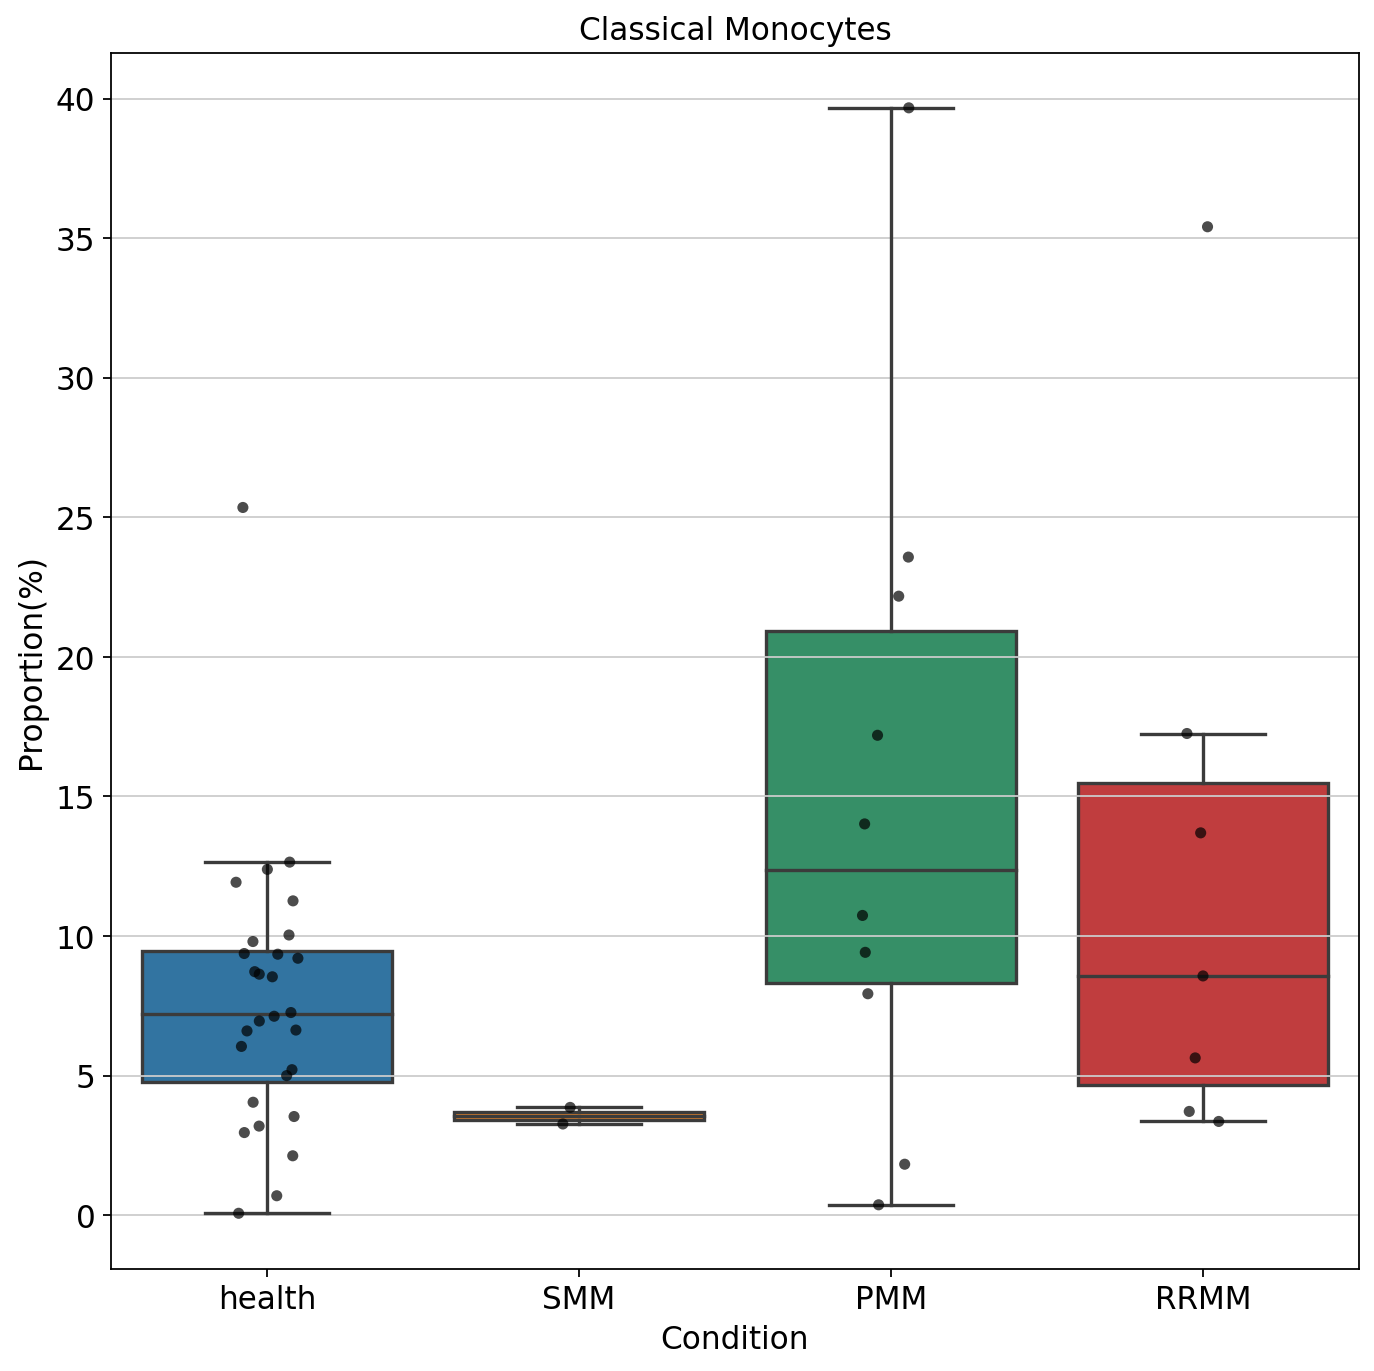

Text(0.5, 1.0, 'Conventional dendritic cell 1')

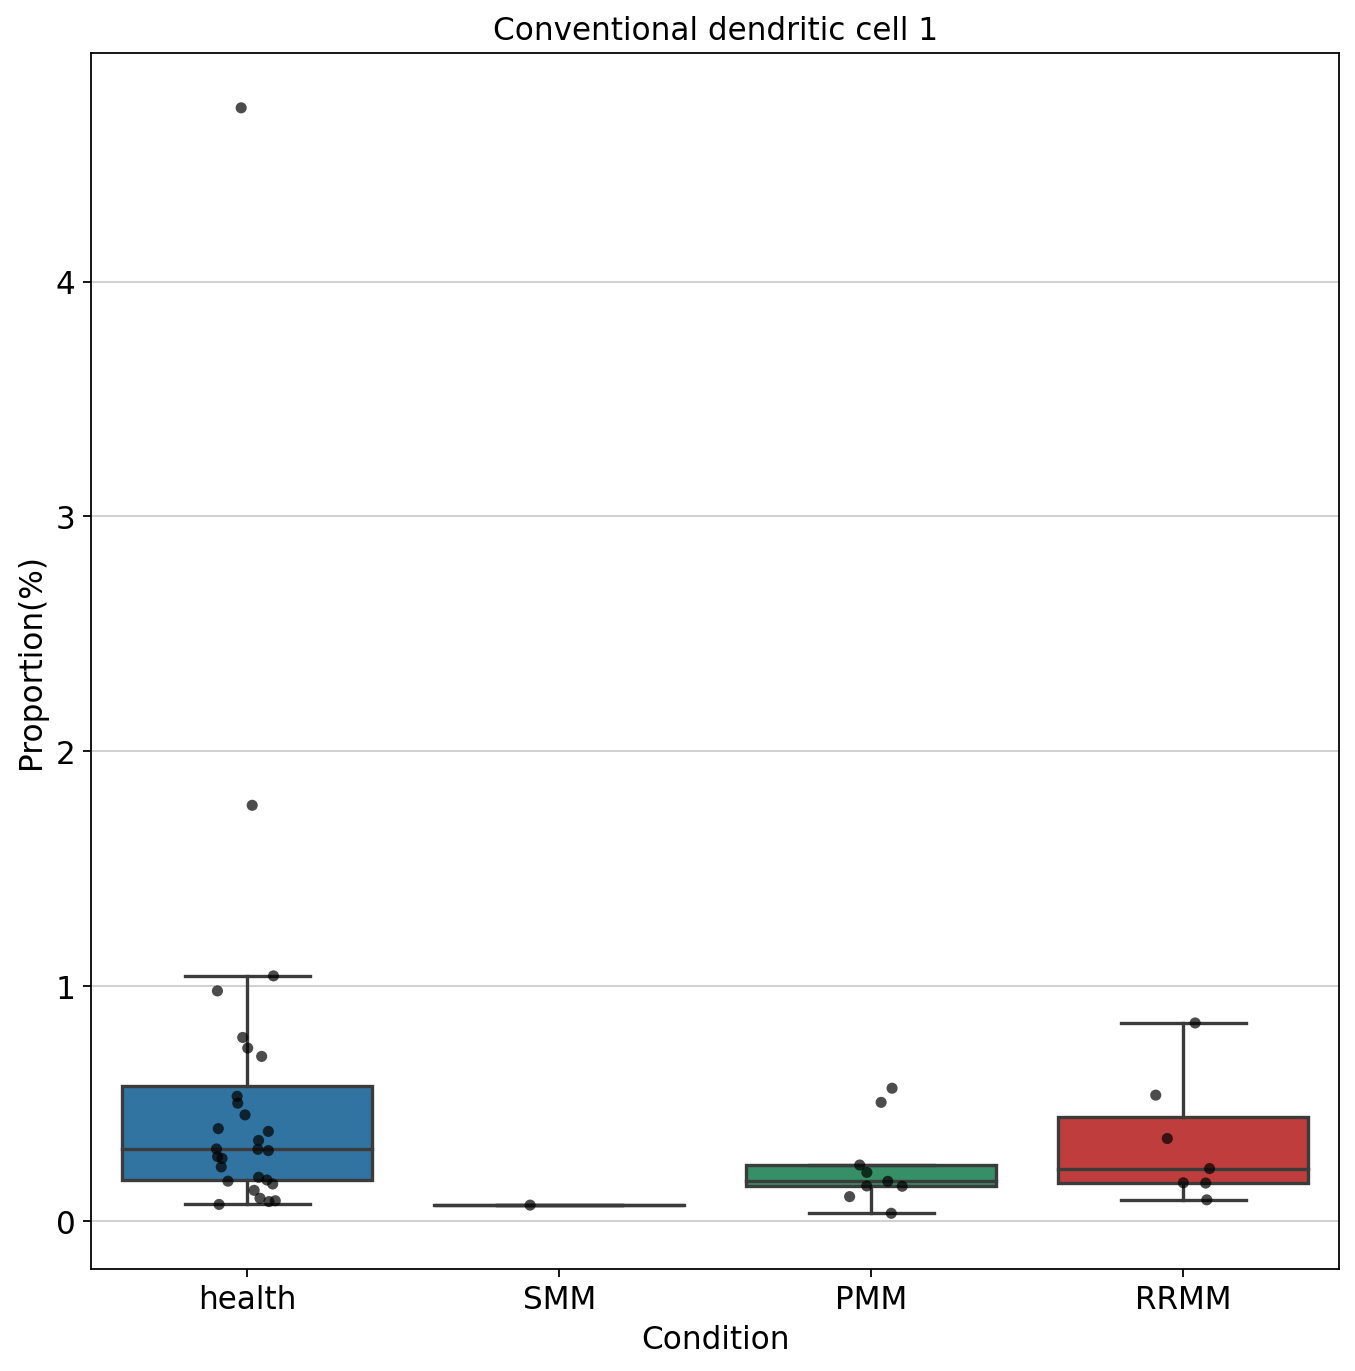







p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

health vs. RRMM: Custom statistical test, P_val:1.077e-02


Text(0.5, 1.0, 'Conventional dendritic cell 2')

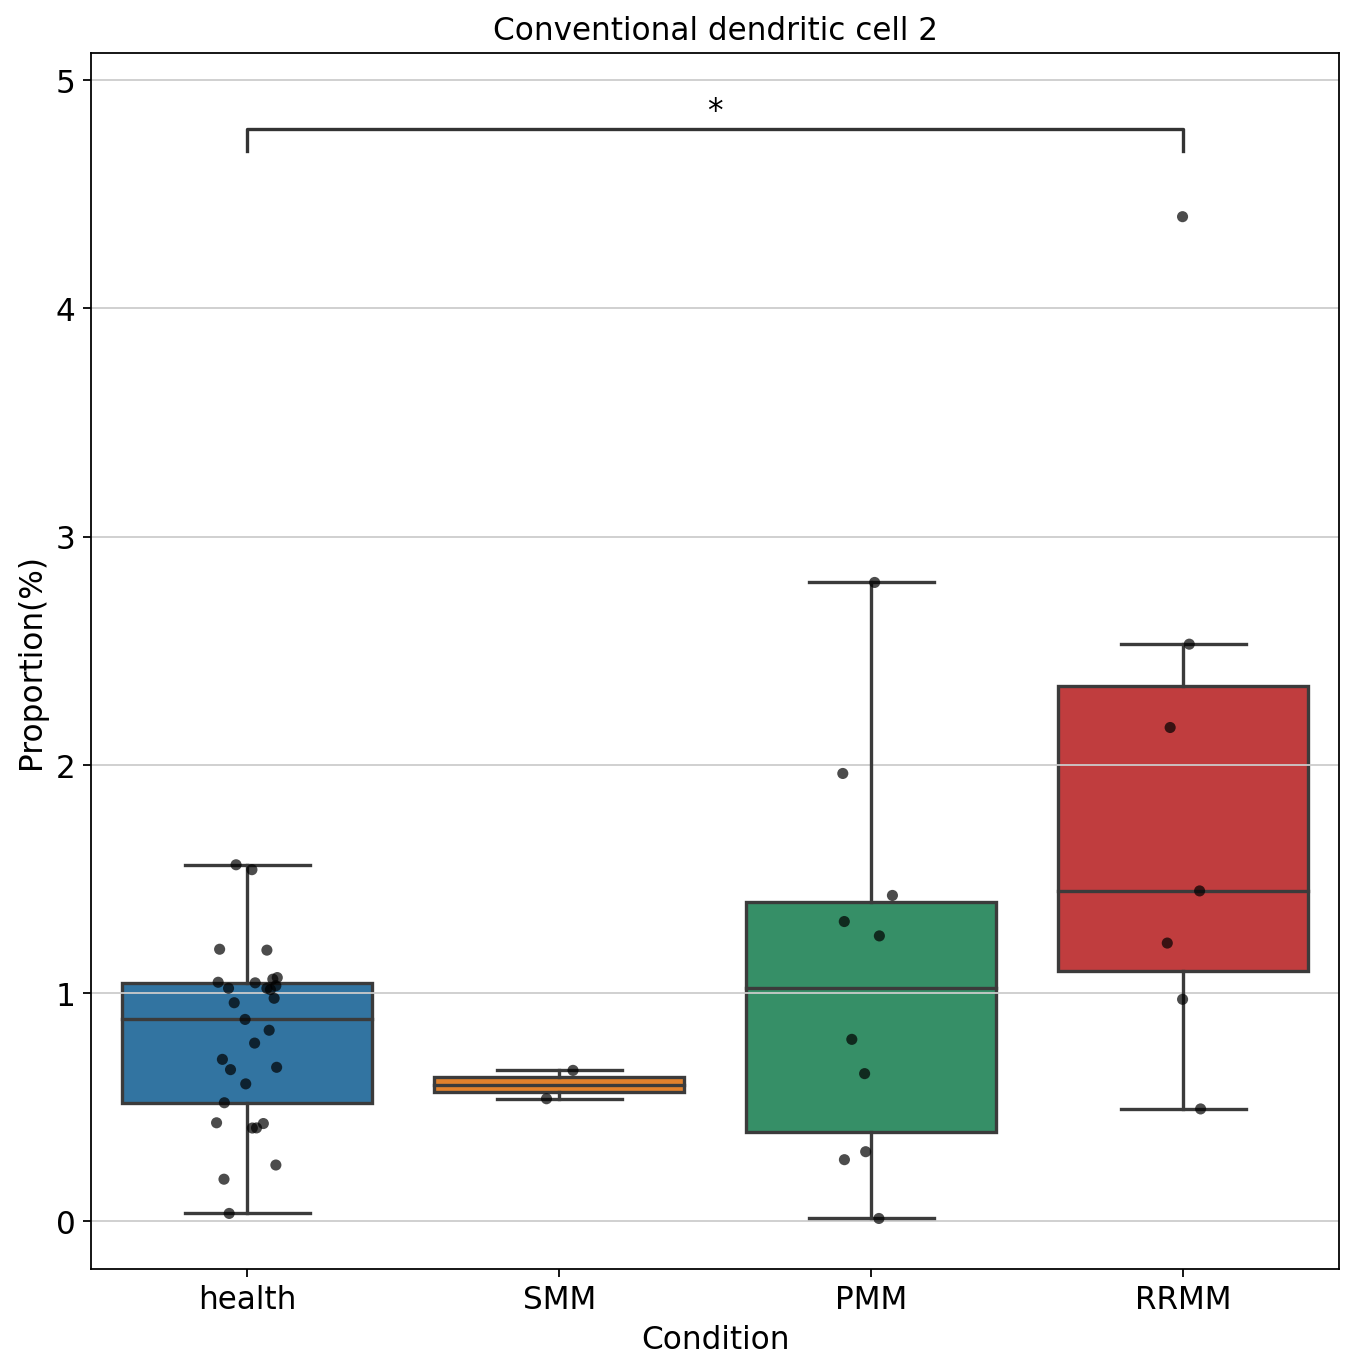







p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

health vs. RRMM: Custom statistical test, P_val:9.266e-03


Text(0.5, 1.0, 'Early erythroid progenitor')

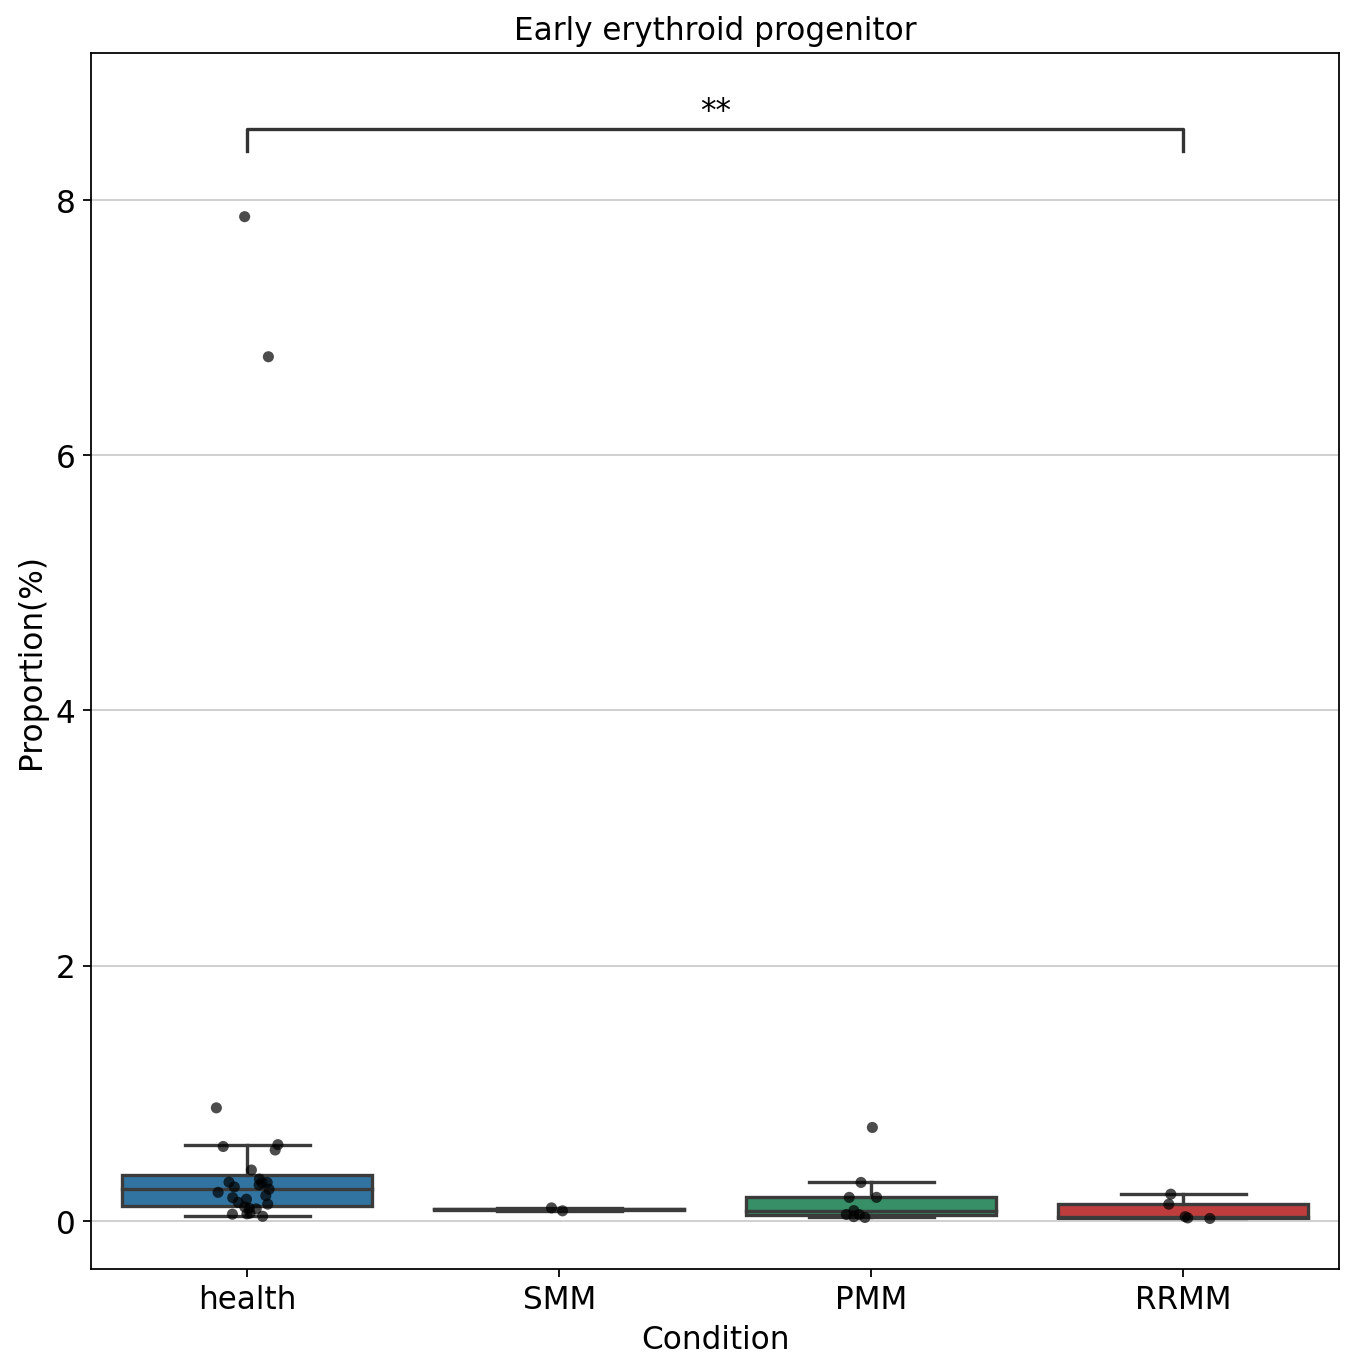







p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

health vs. PMM: Custom statistical test, P_val:3.104e-03


Text(0.5, 1.0, 'Early promyelocytes')

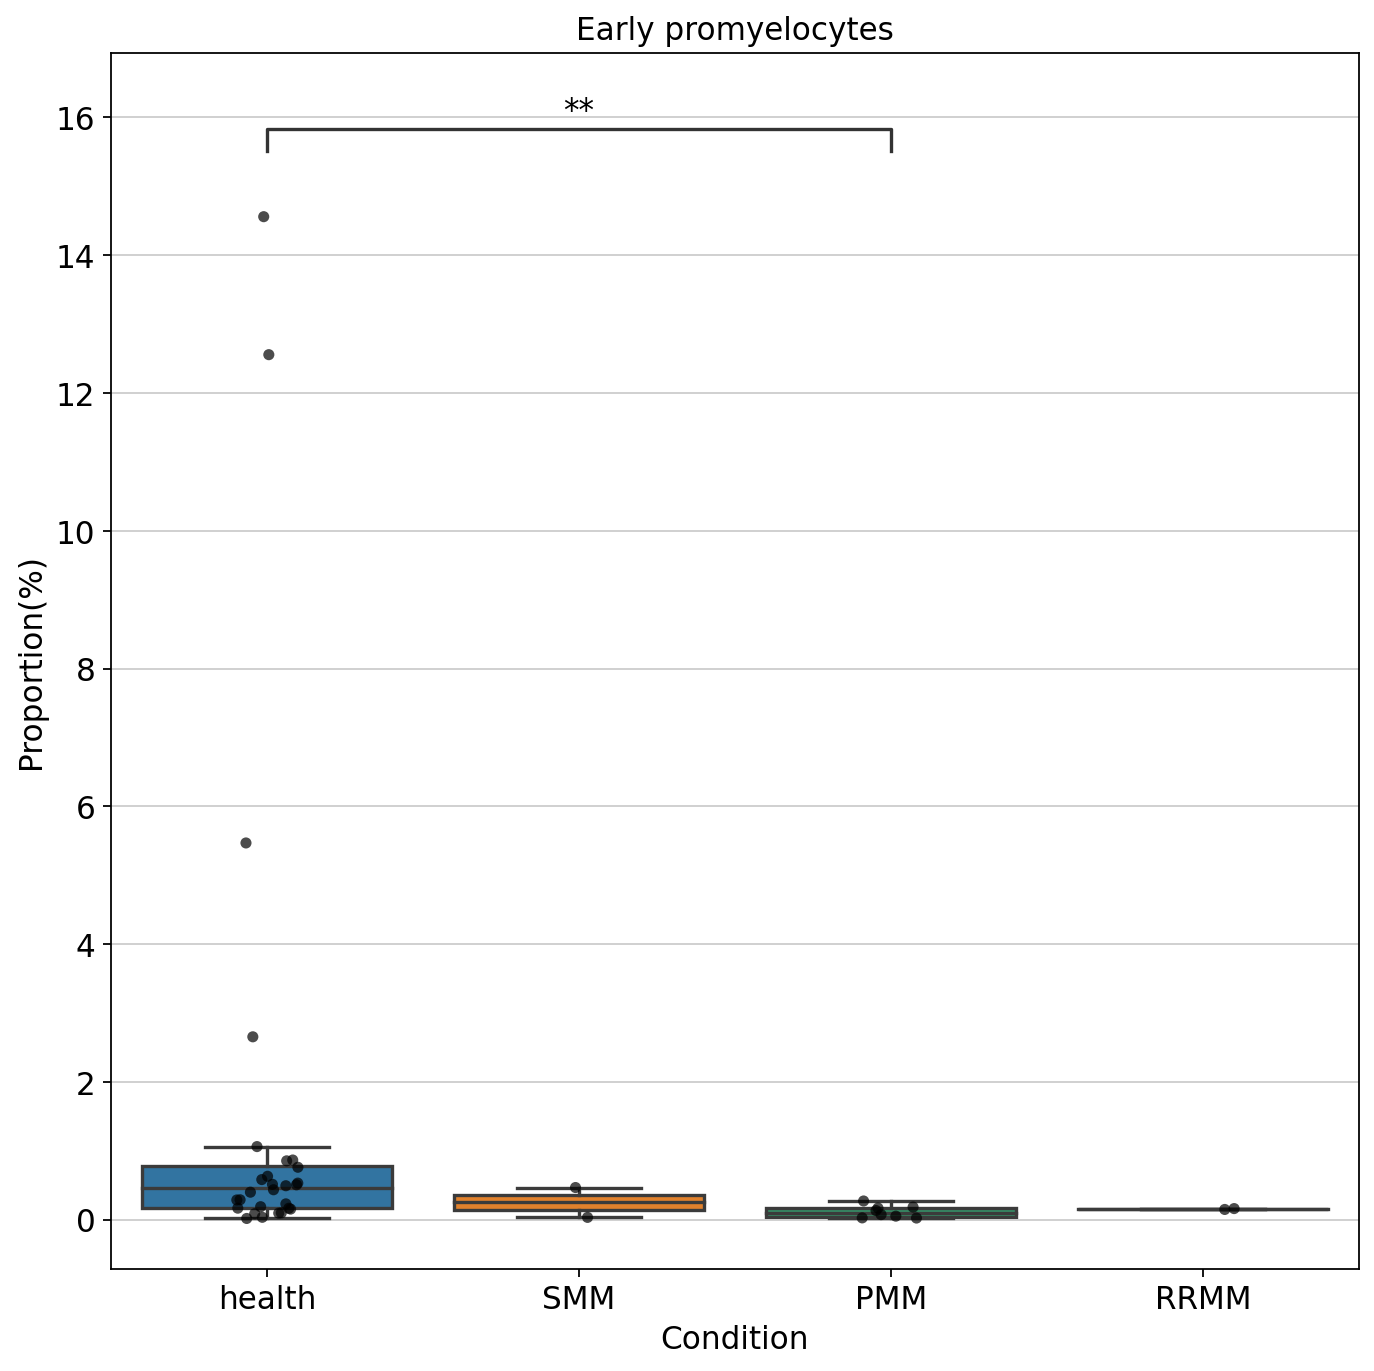

Text(0.5, 1.0, 'Eosinophil-basophil-mast cell progenitors')

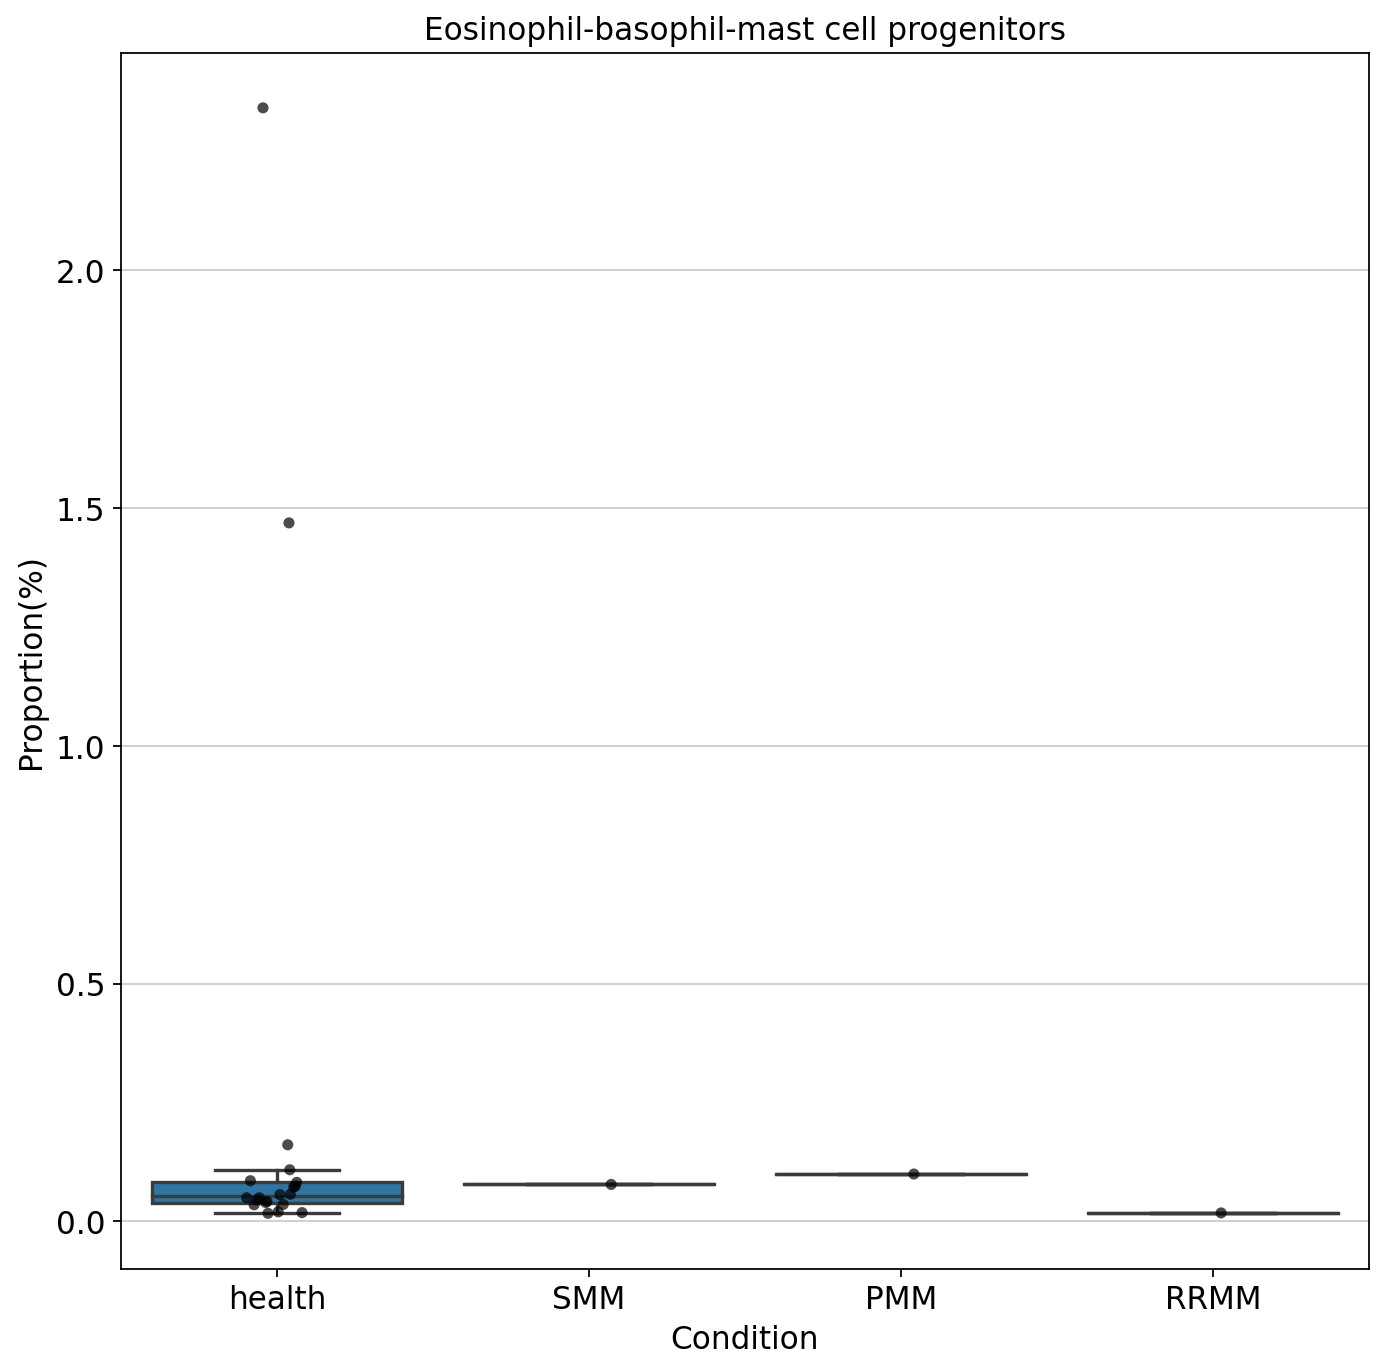

Text(0.5, 1.0, 'Erythro-myeloid progenitors')

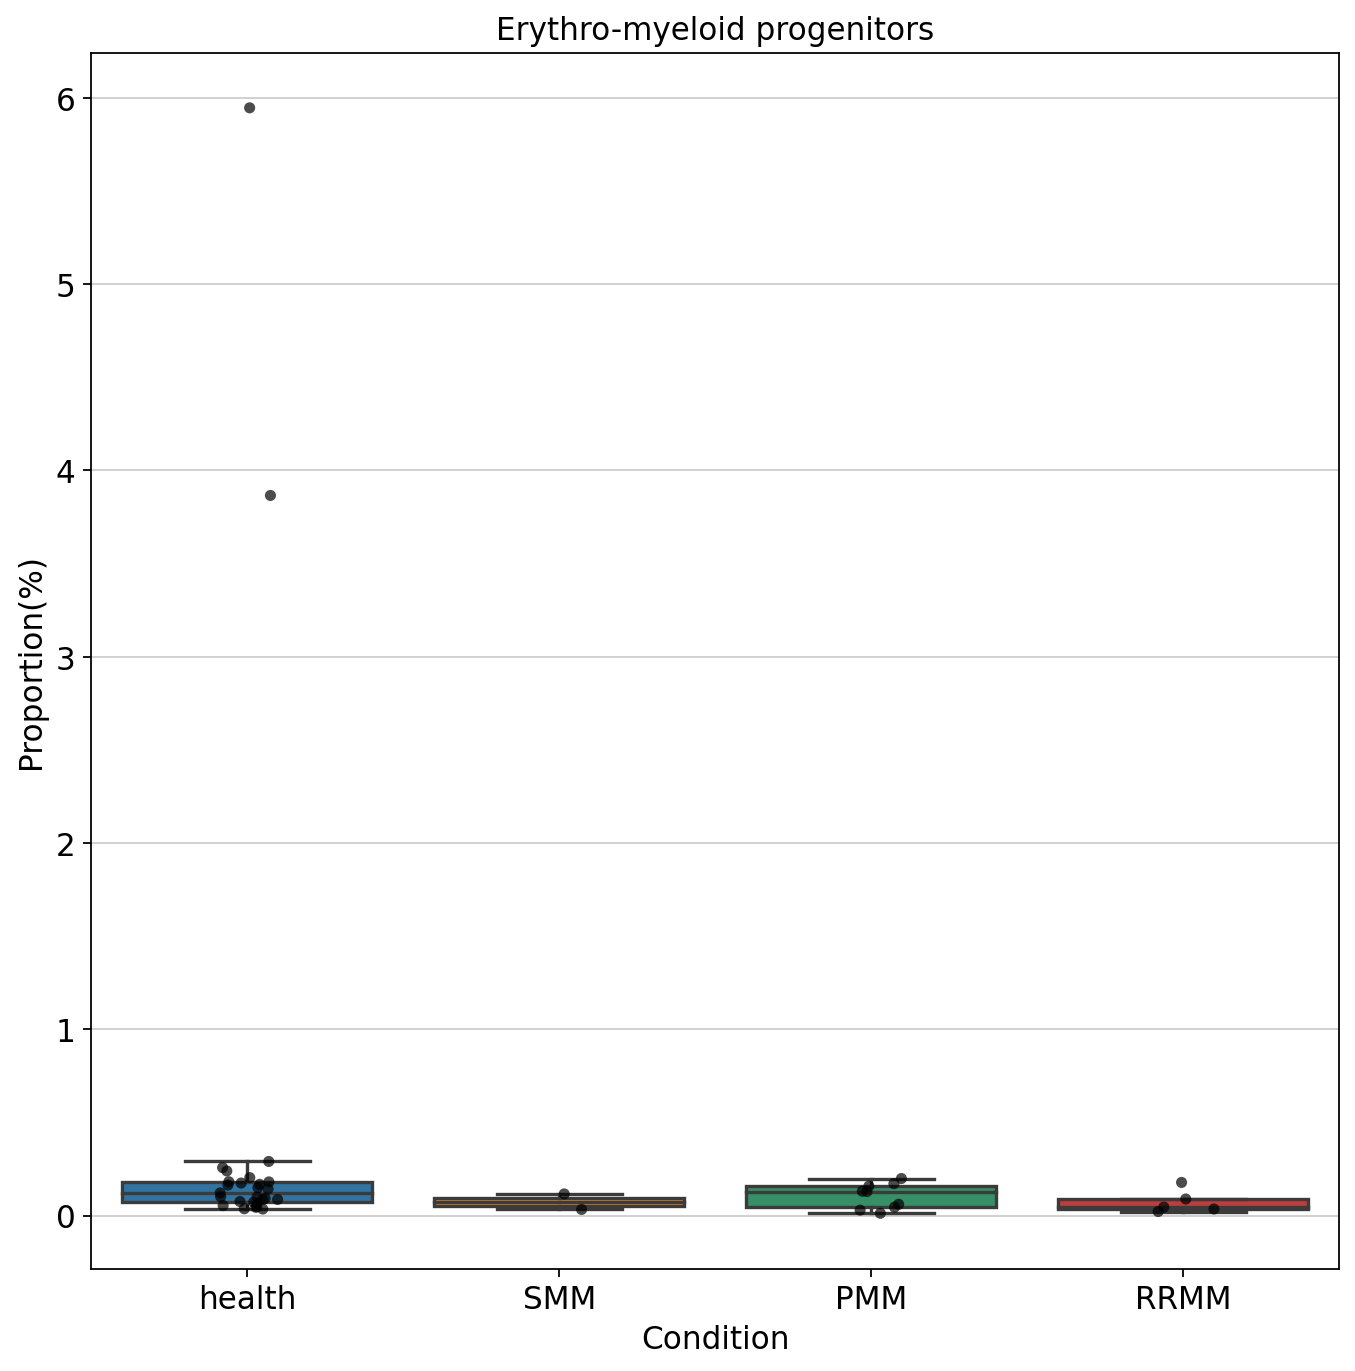

Text(0.5, 1.0, 'GammaDelta T cells')

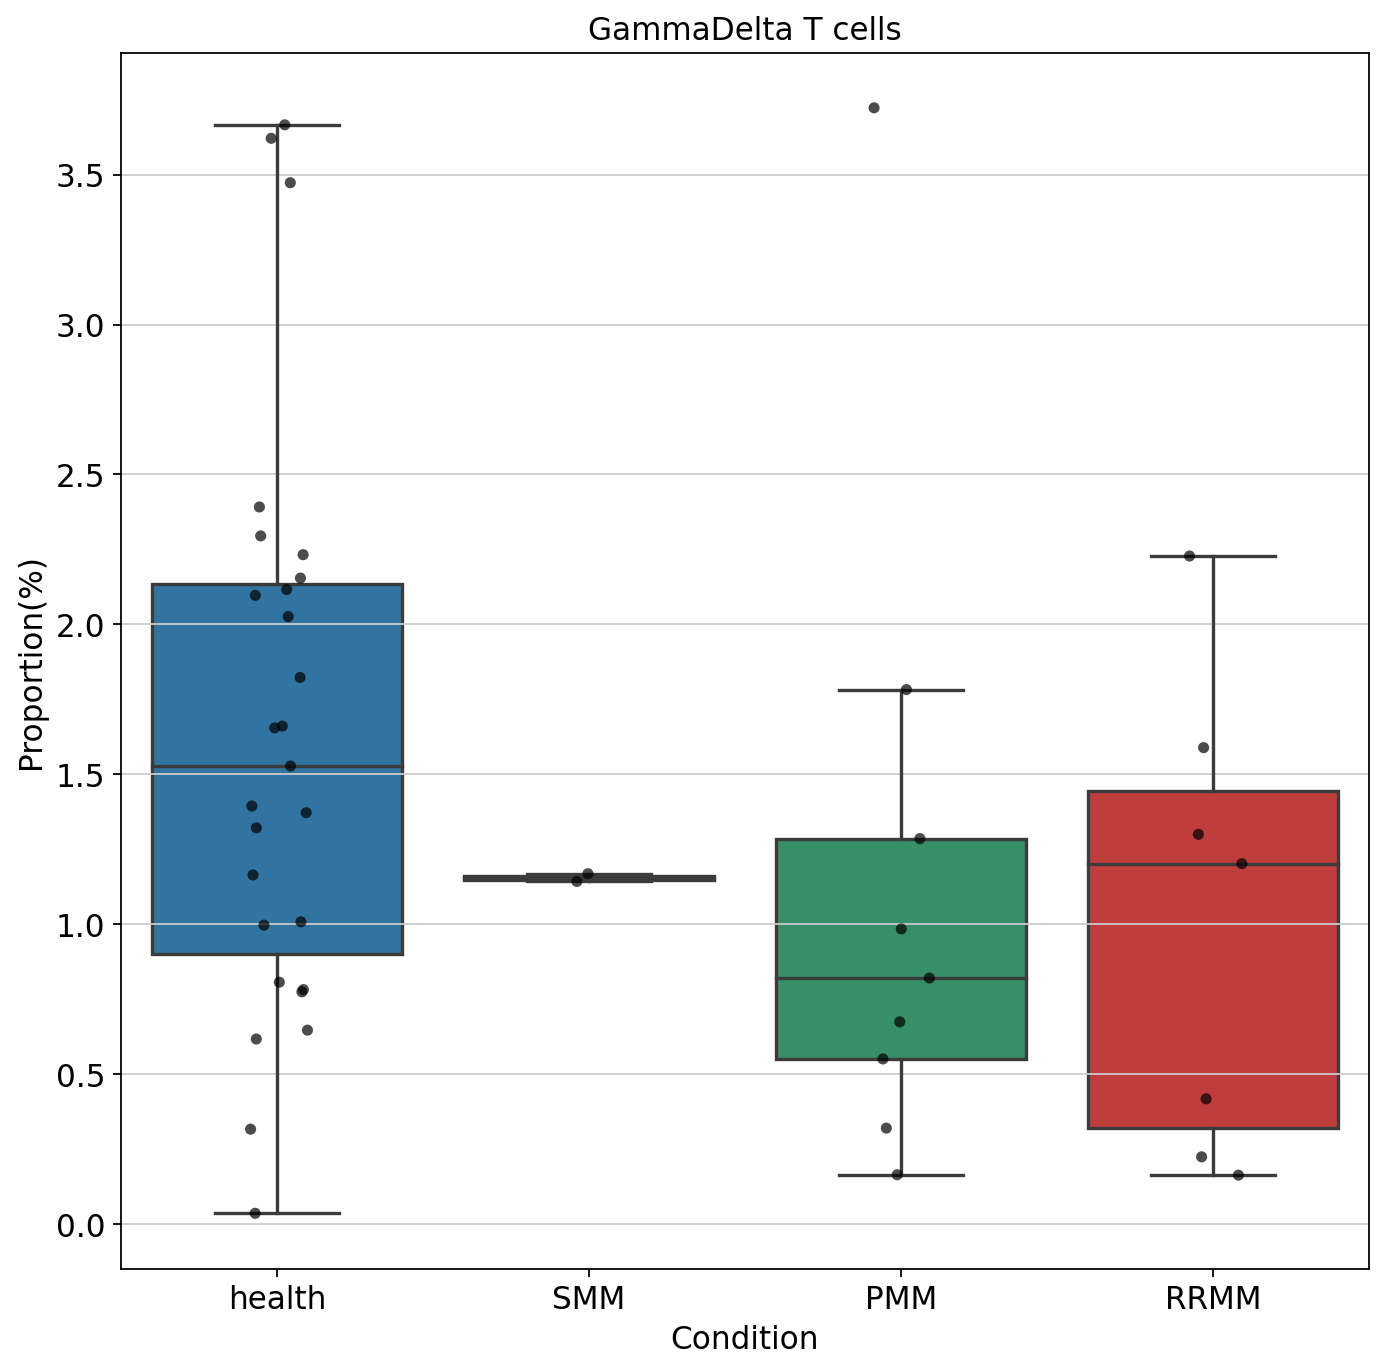







p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

PMM vs. RRMM: Custom statistical test, P_val:4.196e-02
health vs. PMM: Custom statistical test, P_val:7.618e-03
health vs. RRMM: Custom statistical test, P_val:1.041e-05


Text(0.5, 1.0, 'HSCs & MPPs')

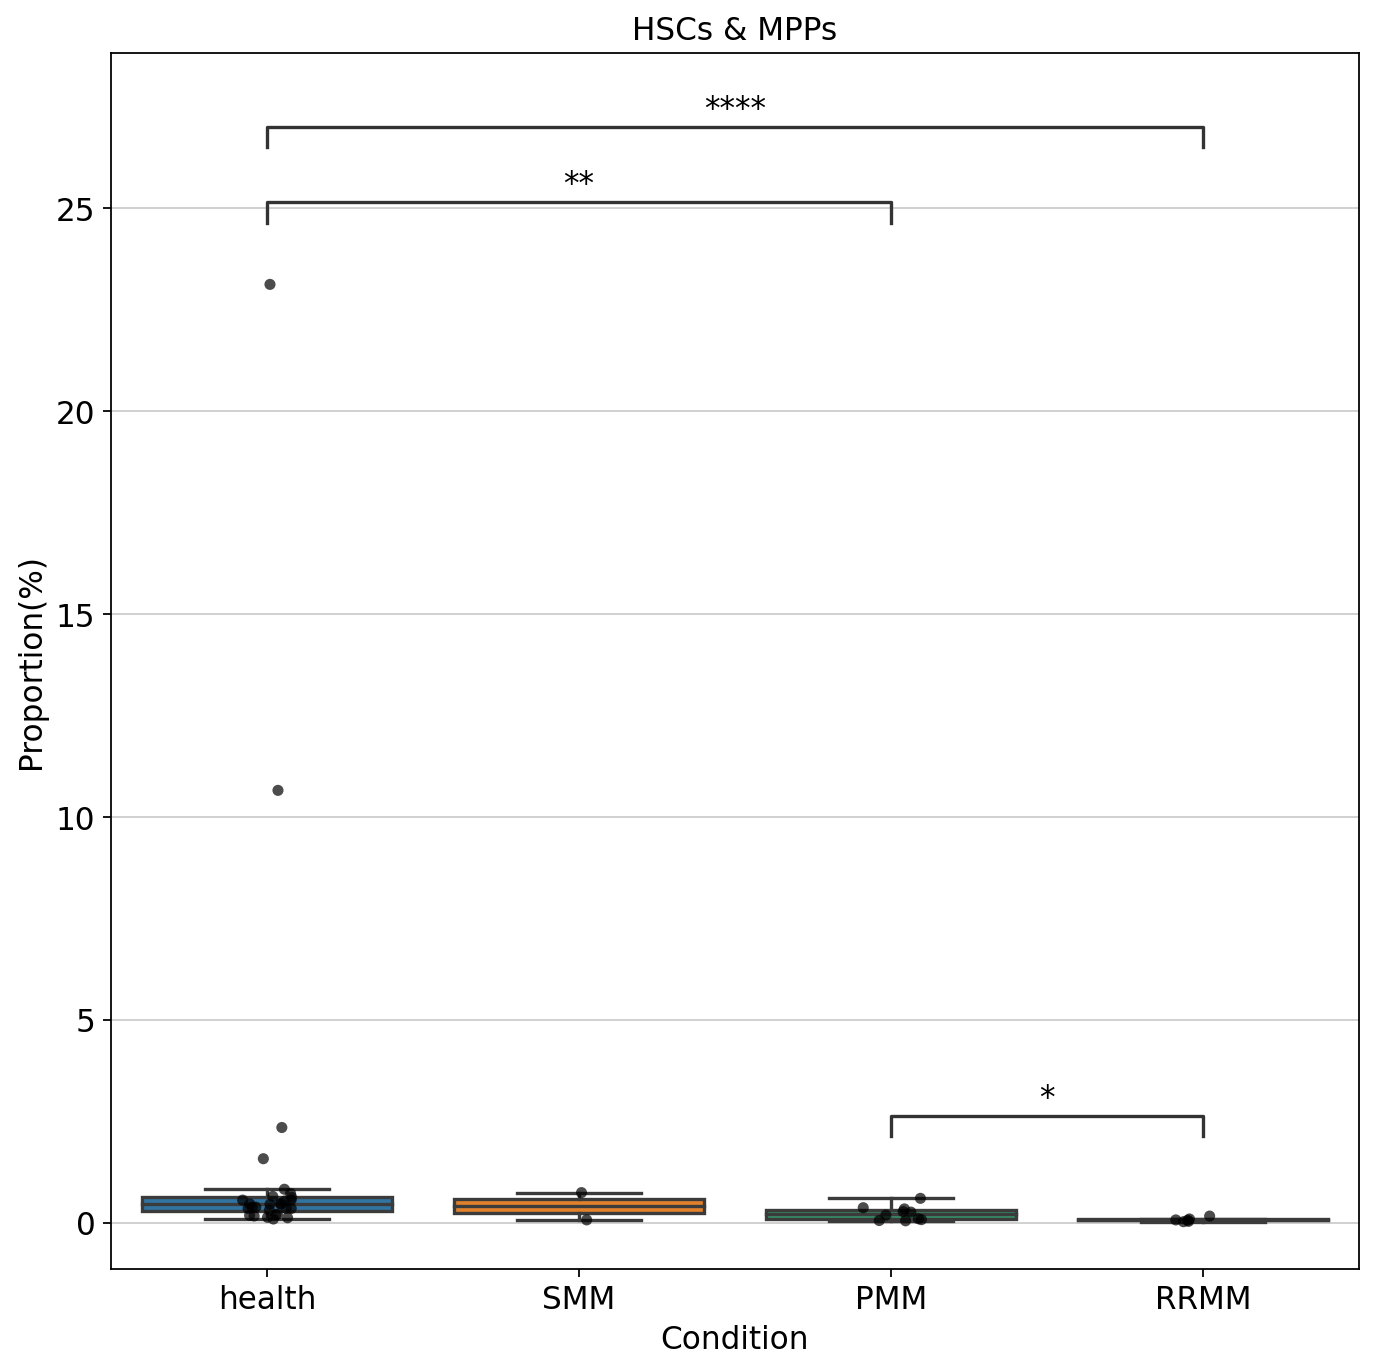







p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

health vs. PMM: Custom statistical test, P_val:1.816e-03
health vs. RRMM: Custom statistical test, P_val:3.448e-03


Text(0.5, 1.0, 'Immature B cells')

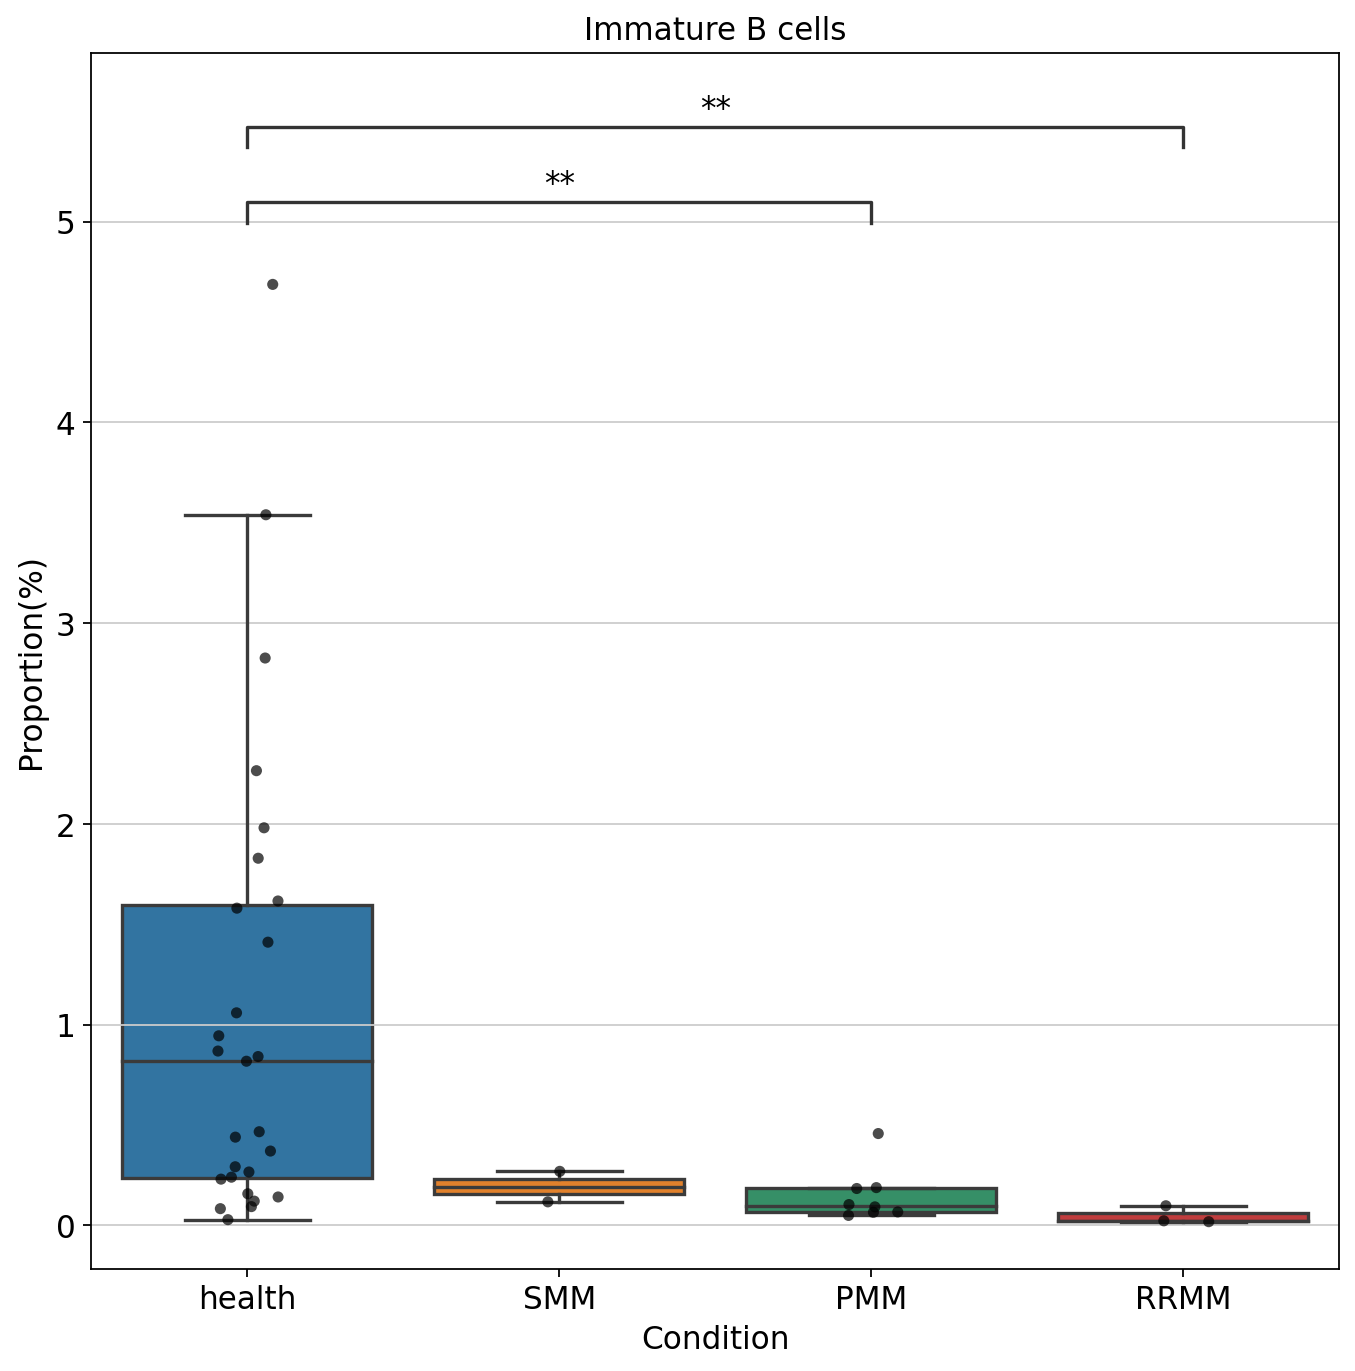







p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

health vs. RRMM: Custom statistical test, P_val:4.857e-02


Text(0.5, 1.0, 'Late erythroid progenitor')

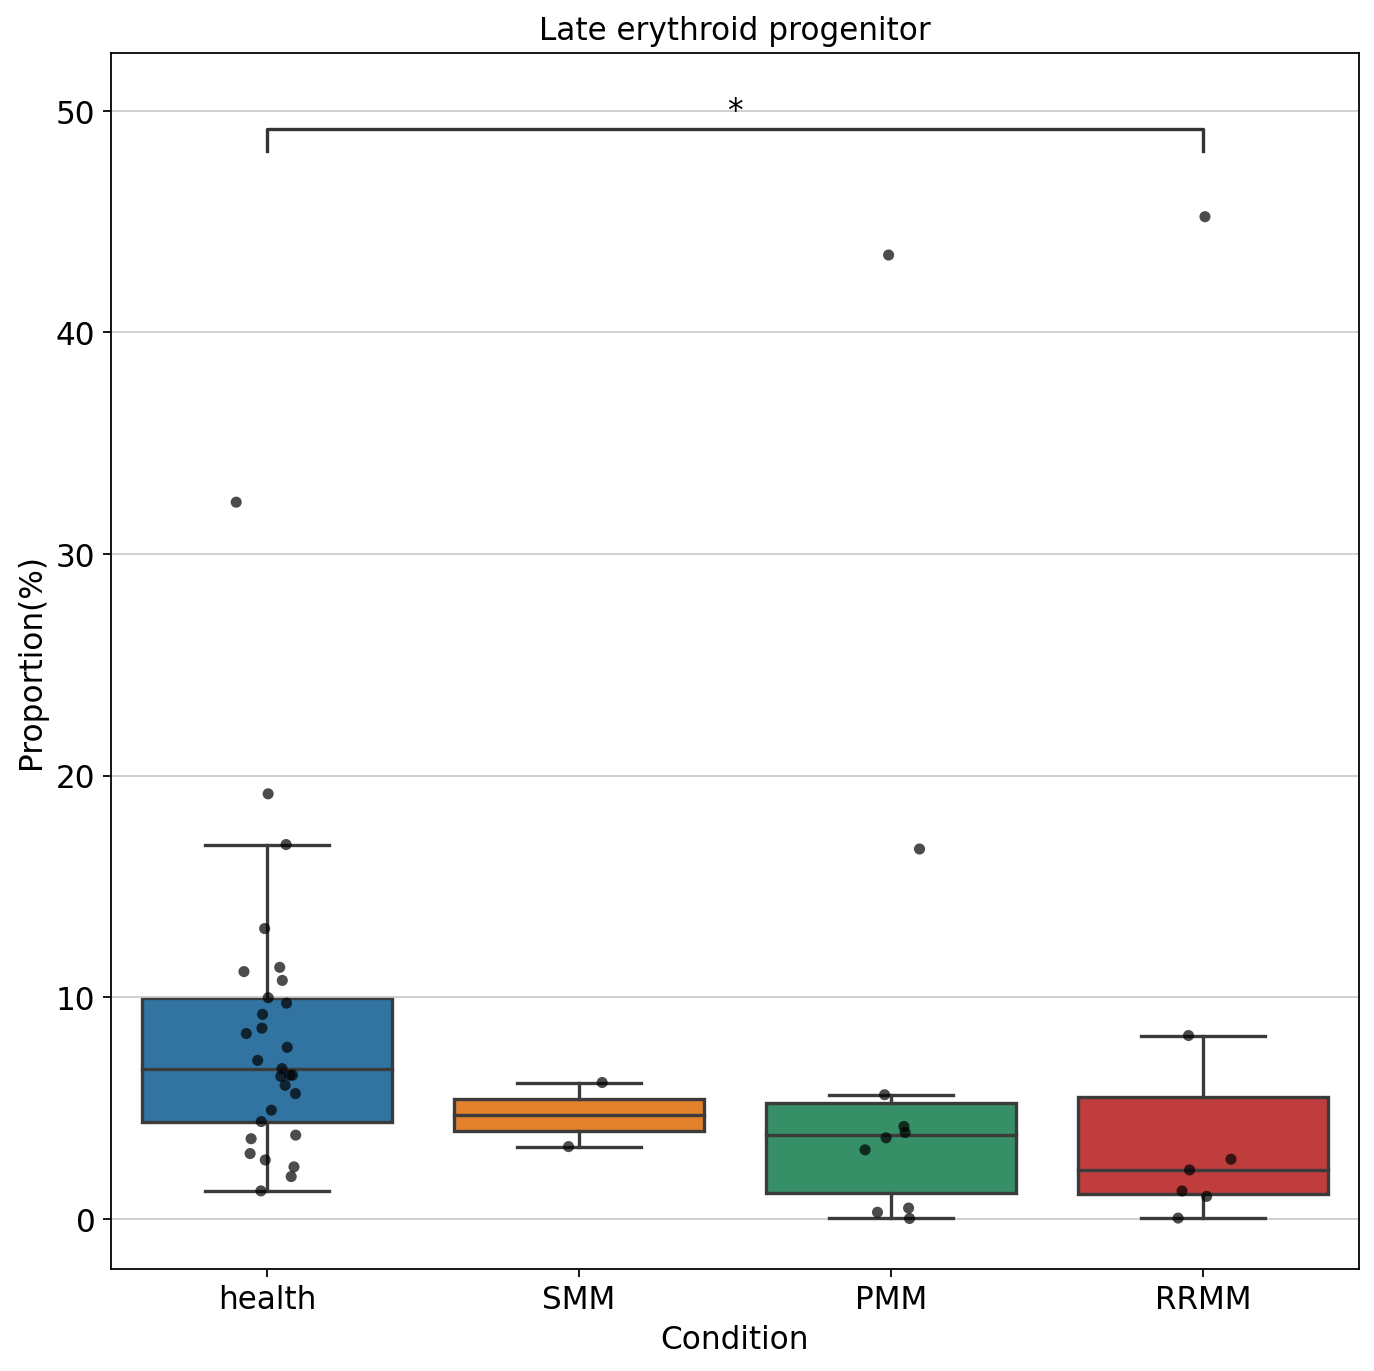







p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

health vs. PMM: Custom statistical test, P_val:5.475e-04
health vs. RRMM: Custom statistical test, P_val:2.513e-04


Text(0.5, 1.0, 'Late promyelocytes')

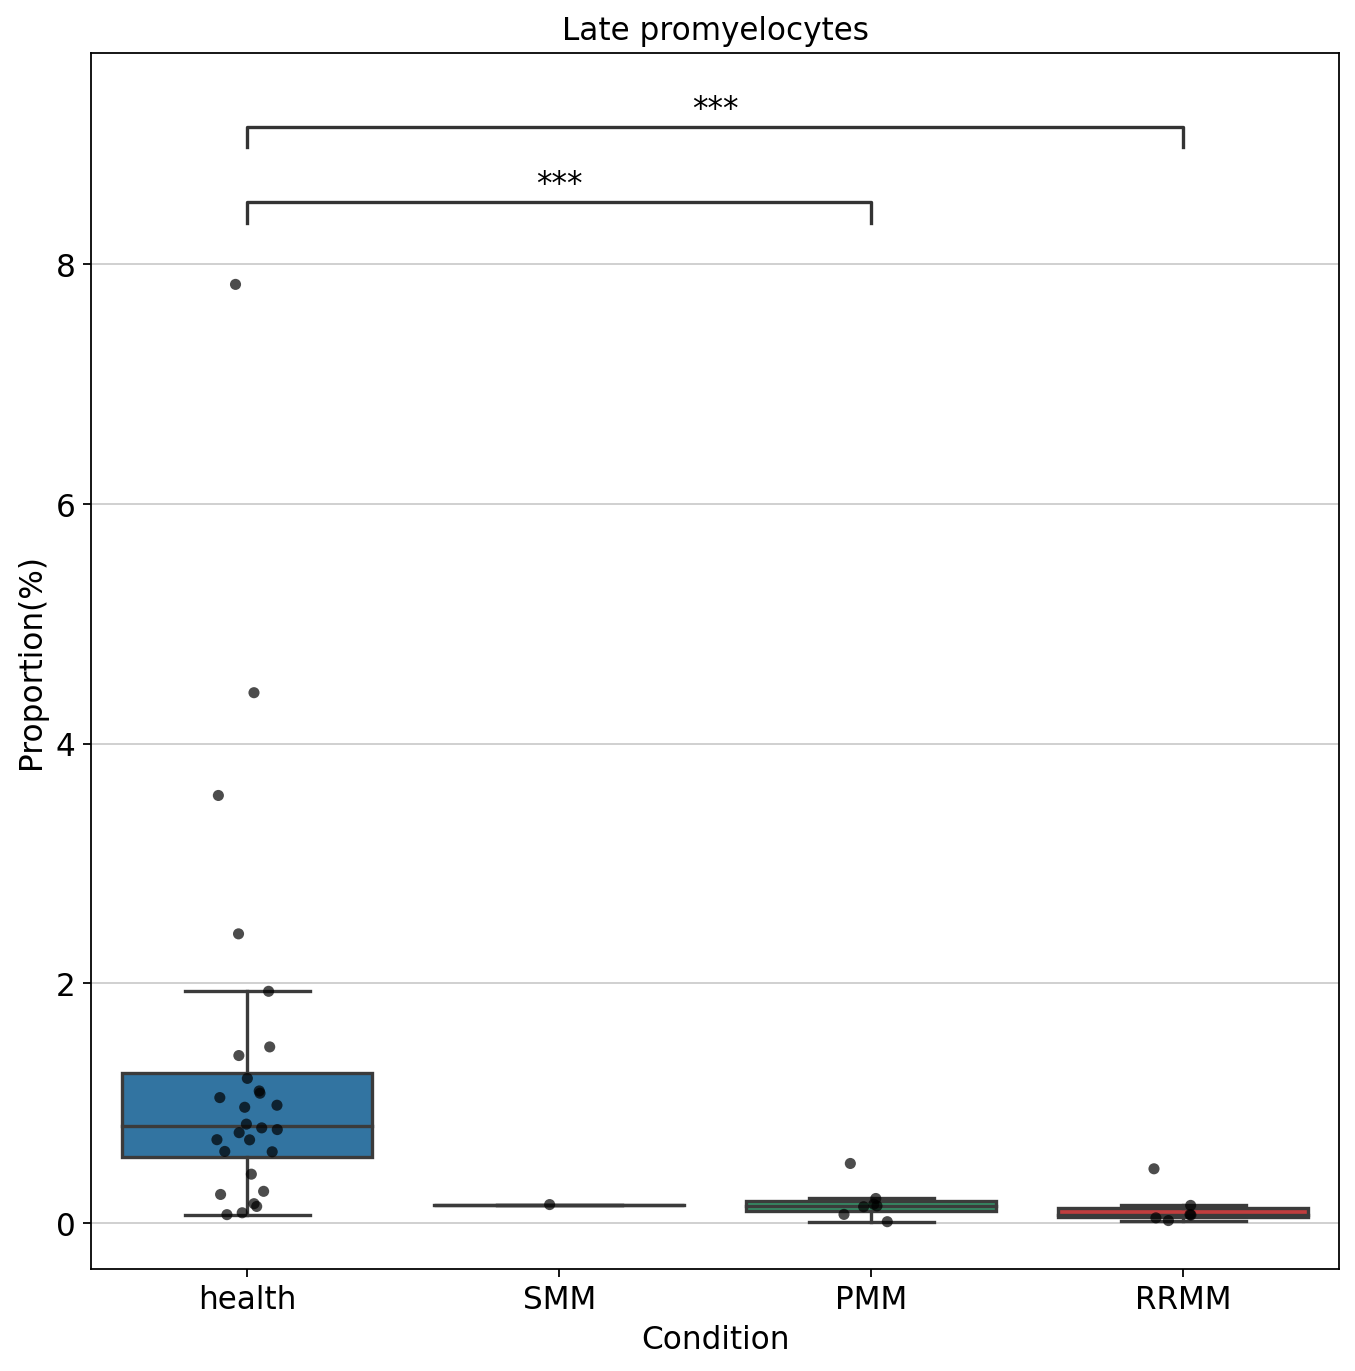







p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

health vs. PMM: Custom statistical test, P_val:3.953e-02
health vs. RRMM: Custom statistical test, P_val:4.364e-02


Text(0.5, 1.0, 'Lymphomyeloid prog')

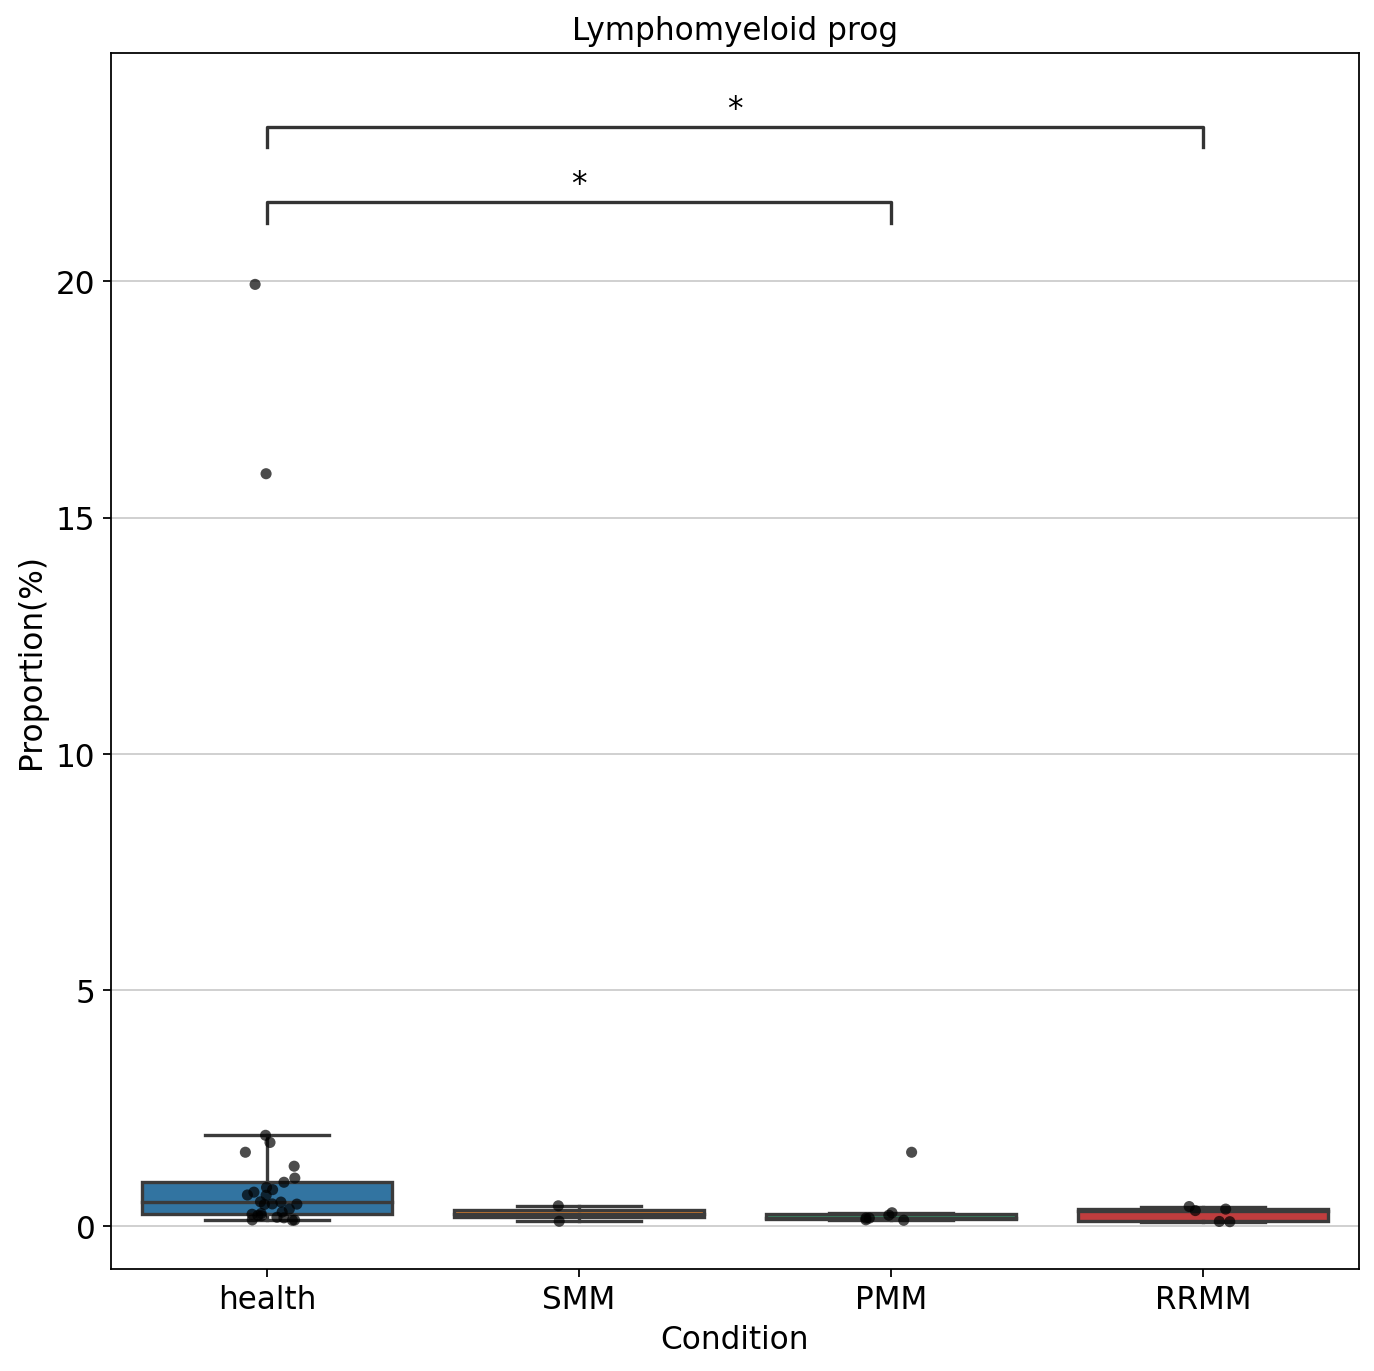







p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

health vs. PMM: Custom statistical test, P_val:3.245e-02


Text(0.5, 1.0, 'Mature naive B cells')

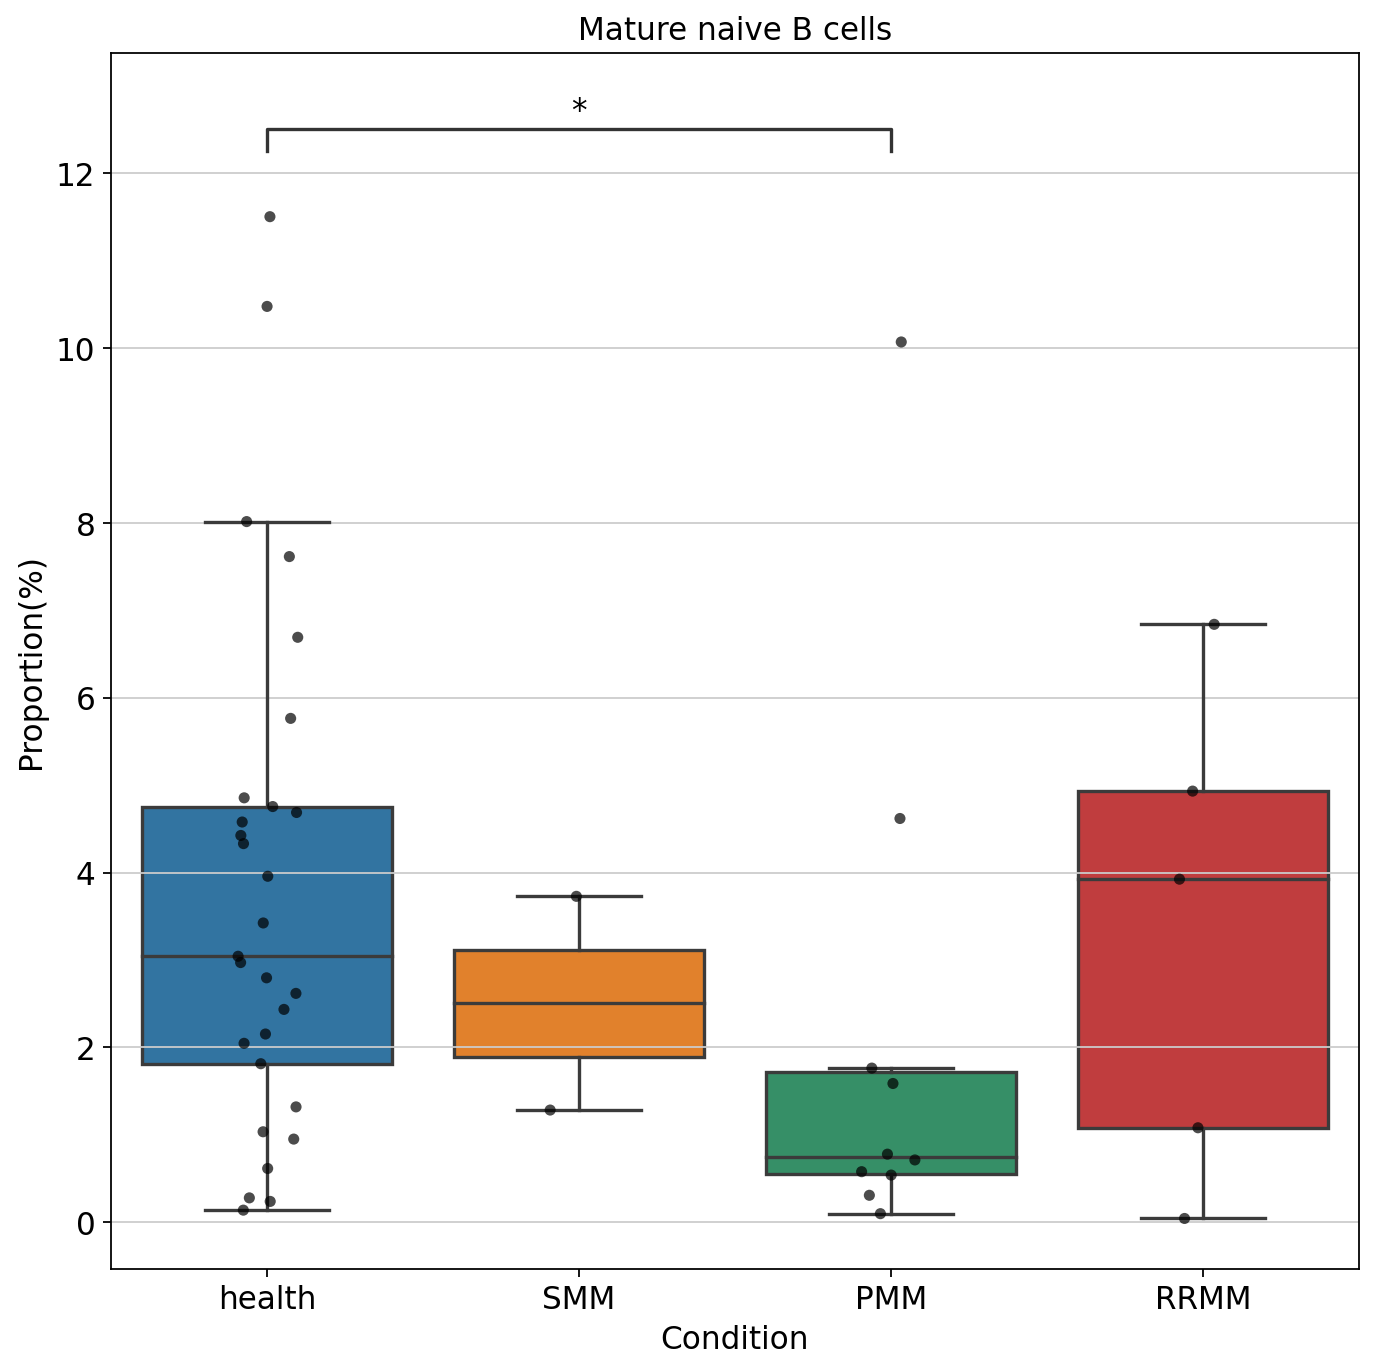

Text(0.5, 1.0, 'Megakaryocyte progenitors')

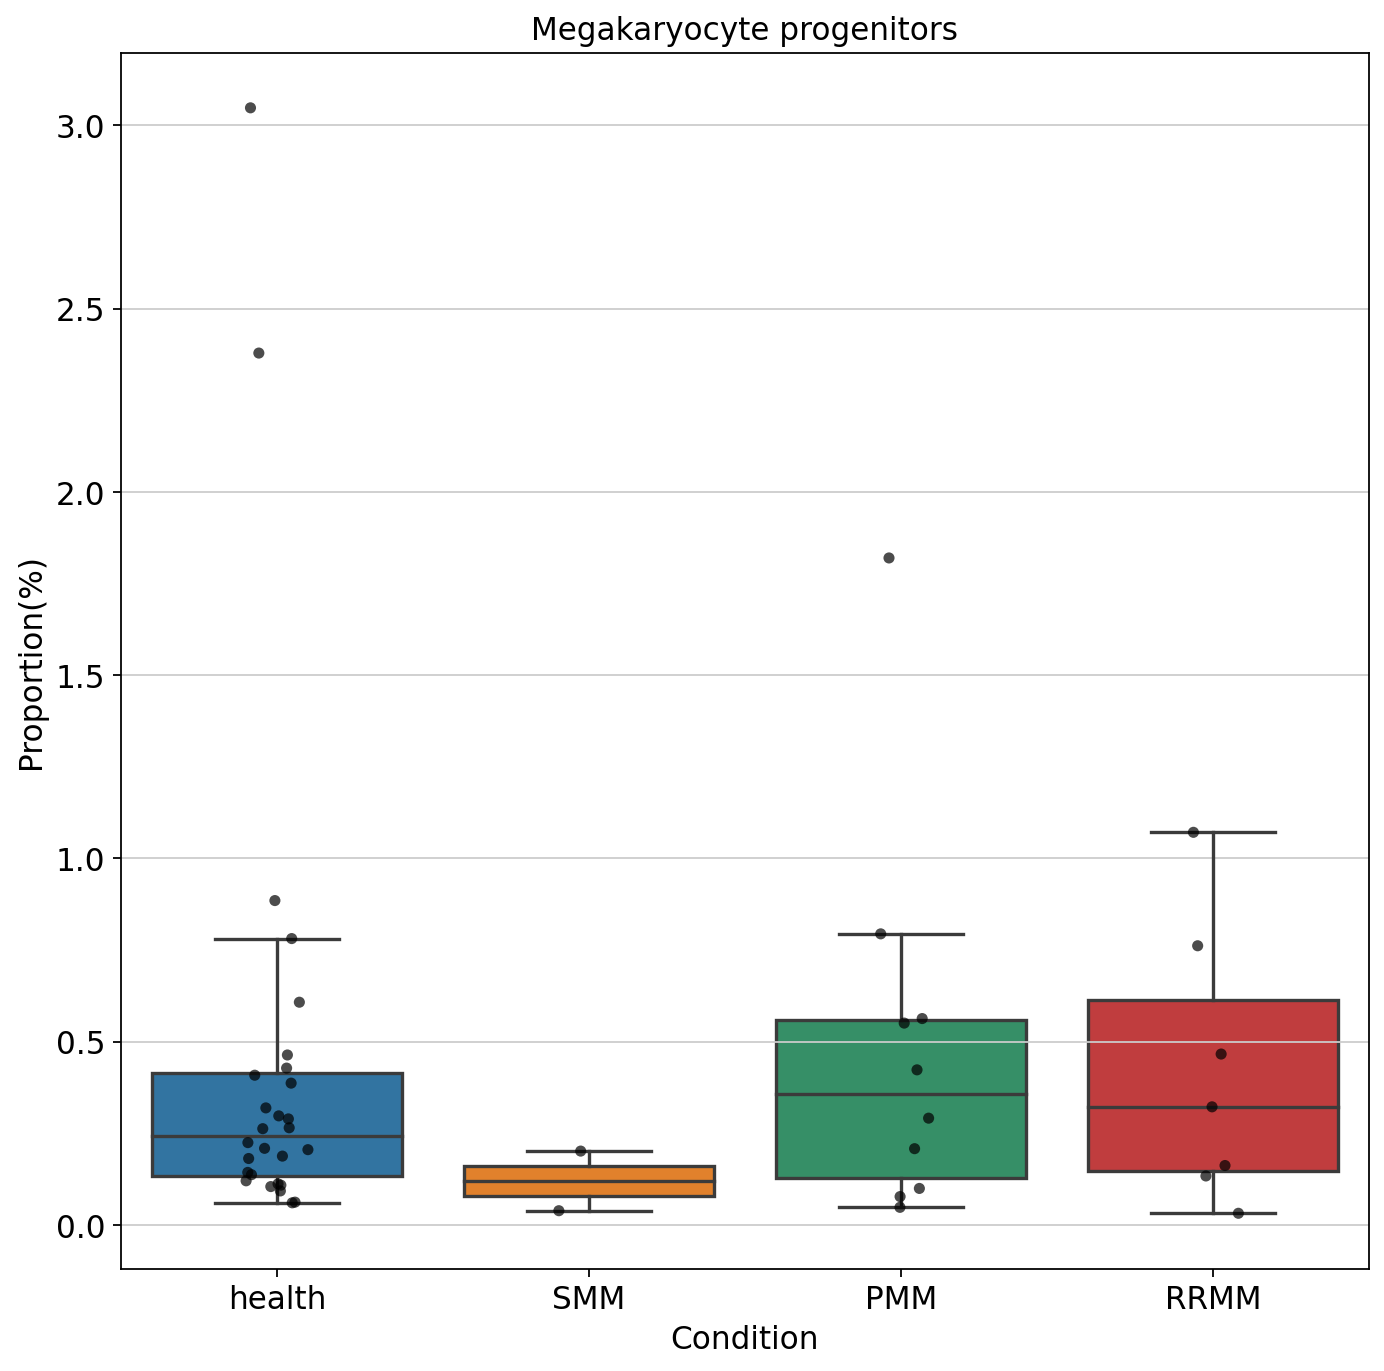

Text(0.5, 1.0, 'Myelocytes')

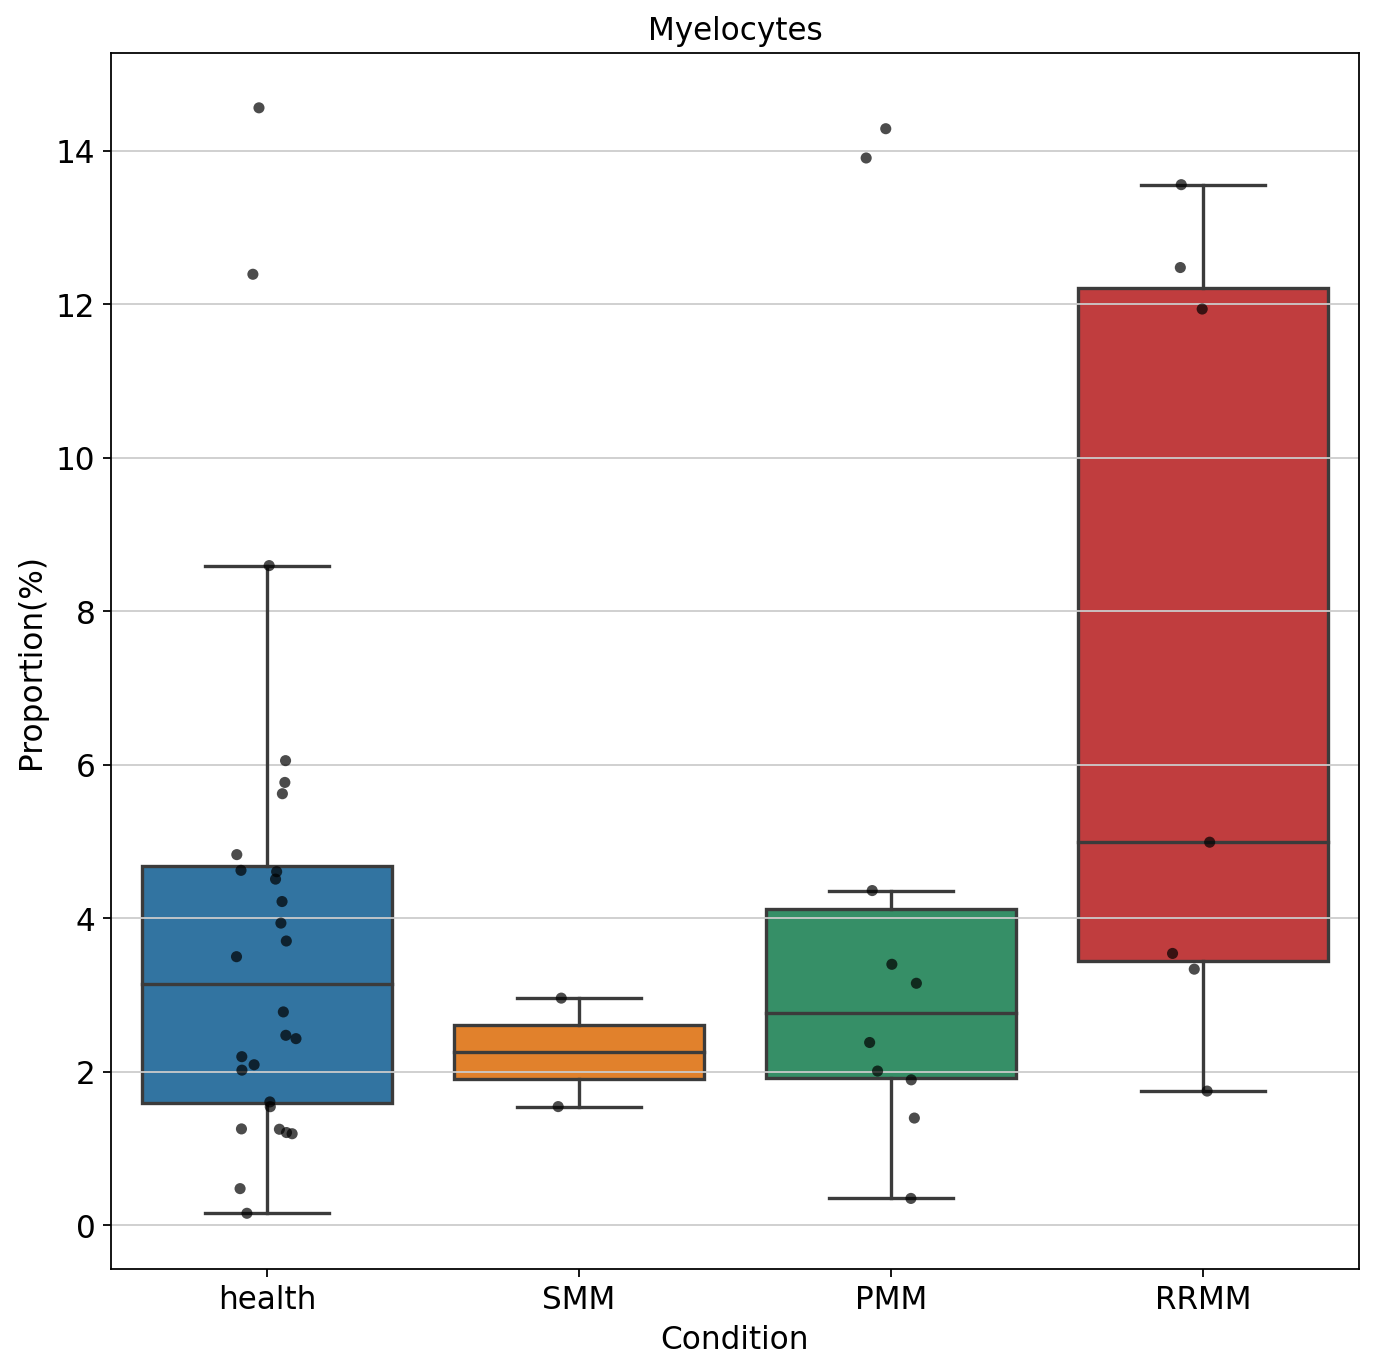







p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

health vs. PMM: Custom statistical test, P_val:4.196e-02


Text(0.5, 1.0, 'NK T cells')

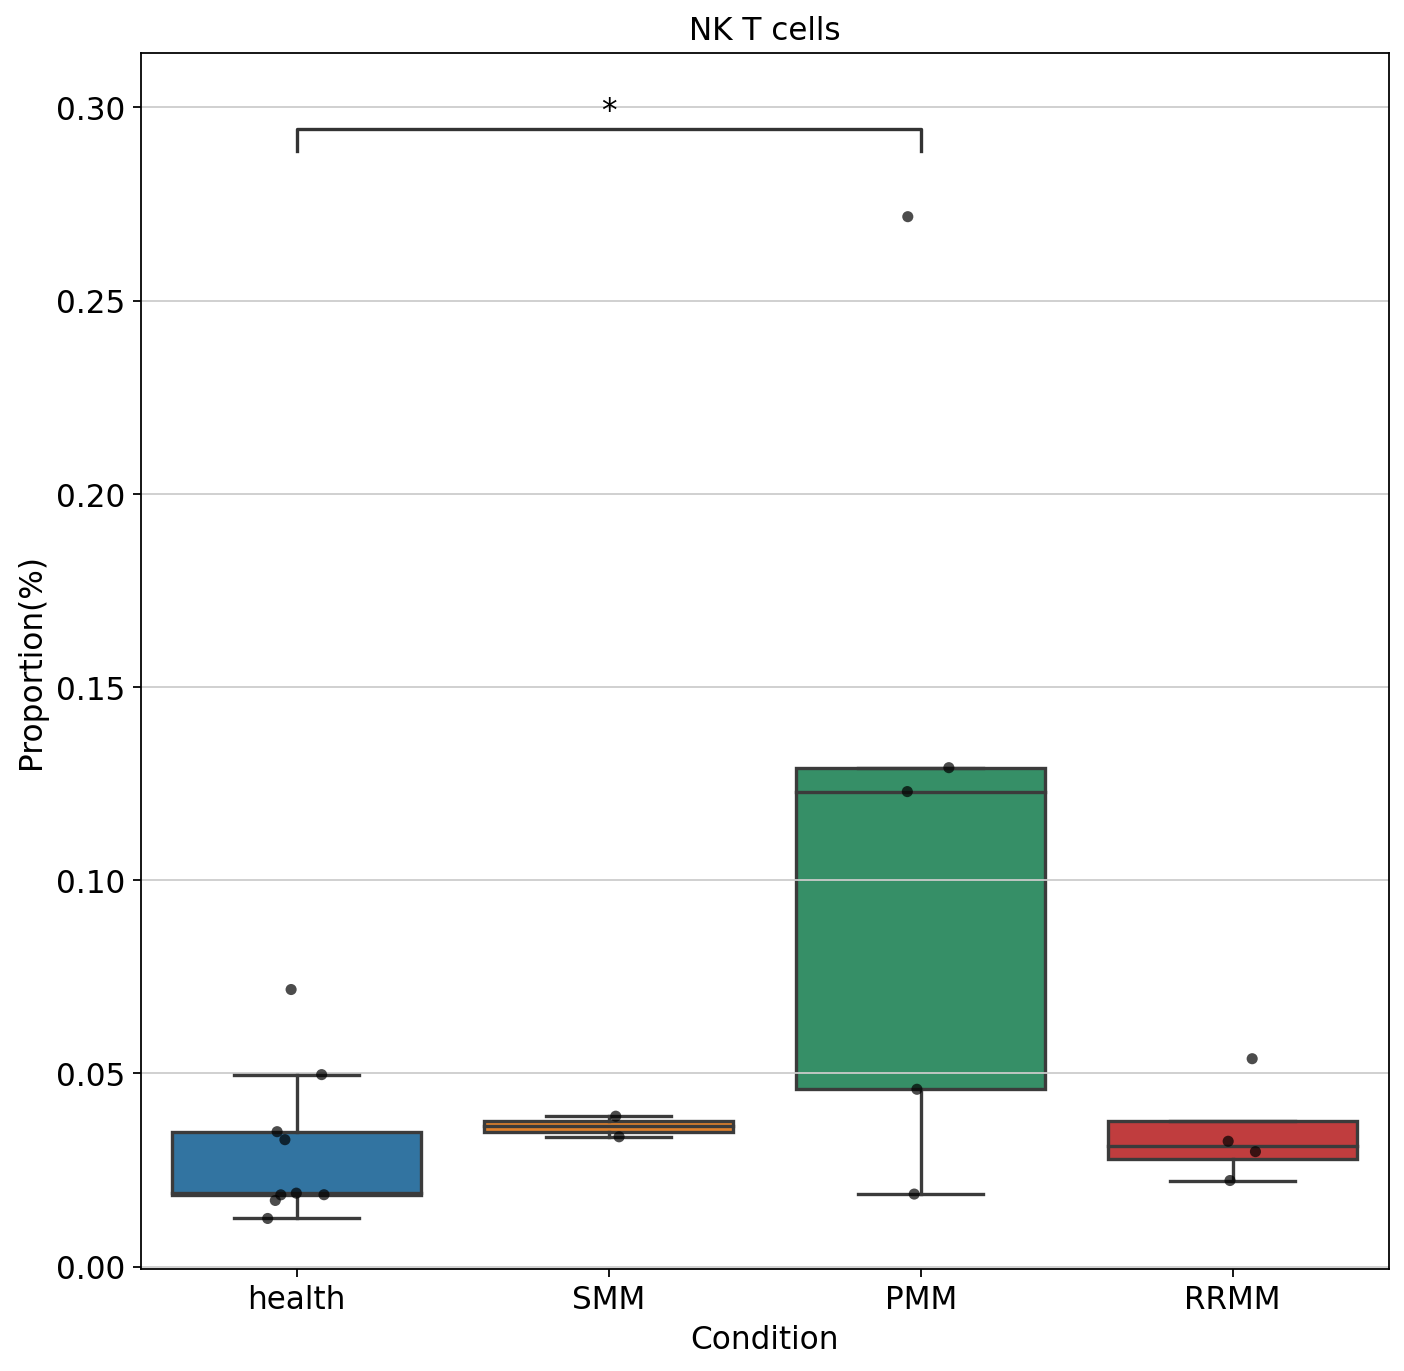

Text(0.5, 1.0, 'NK cell progenitors')

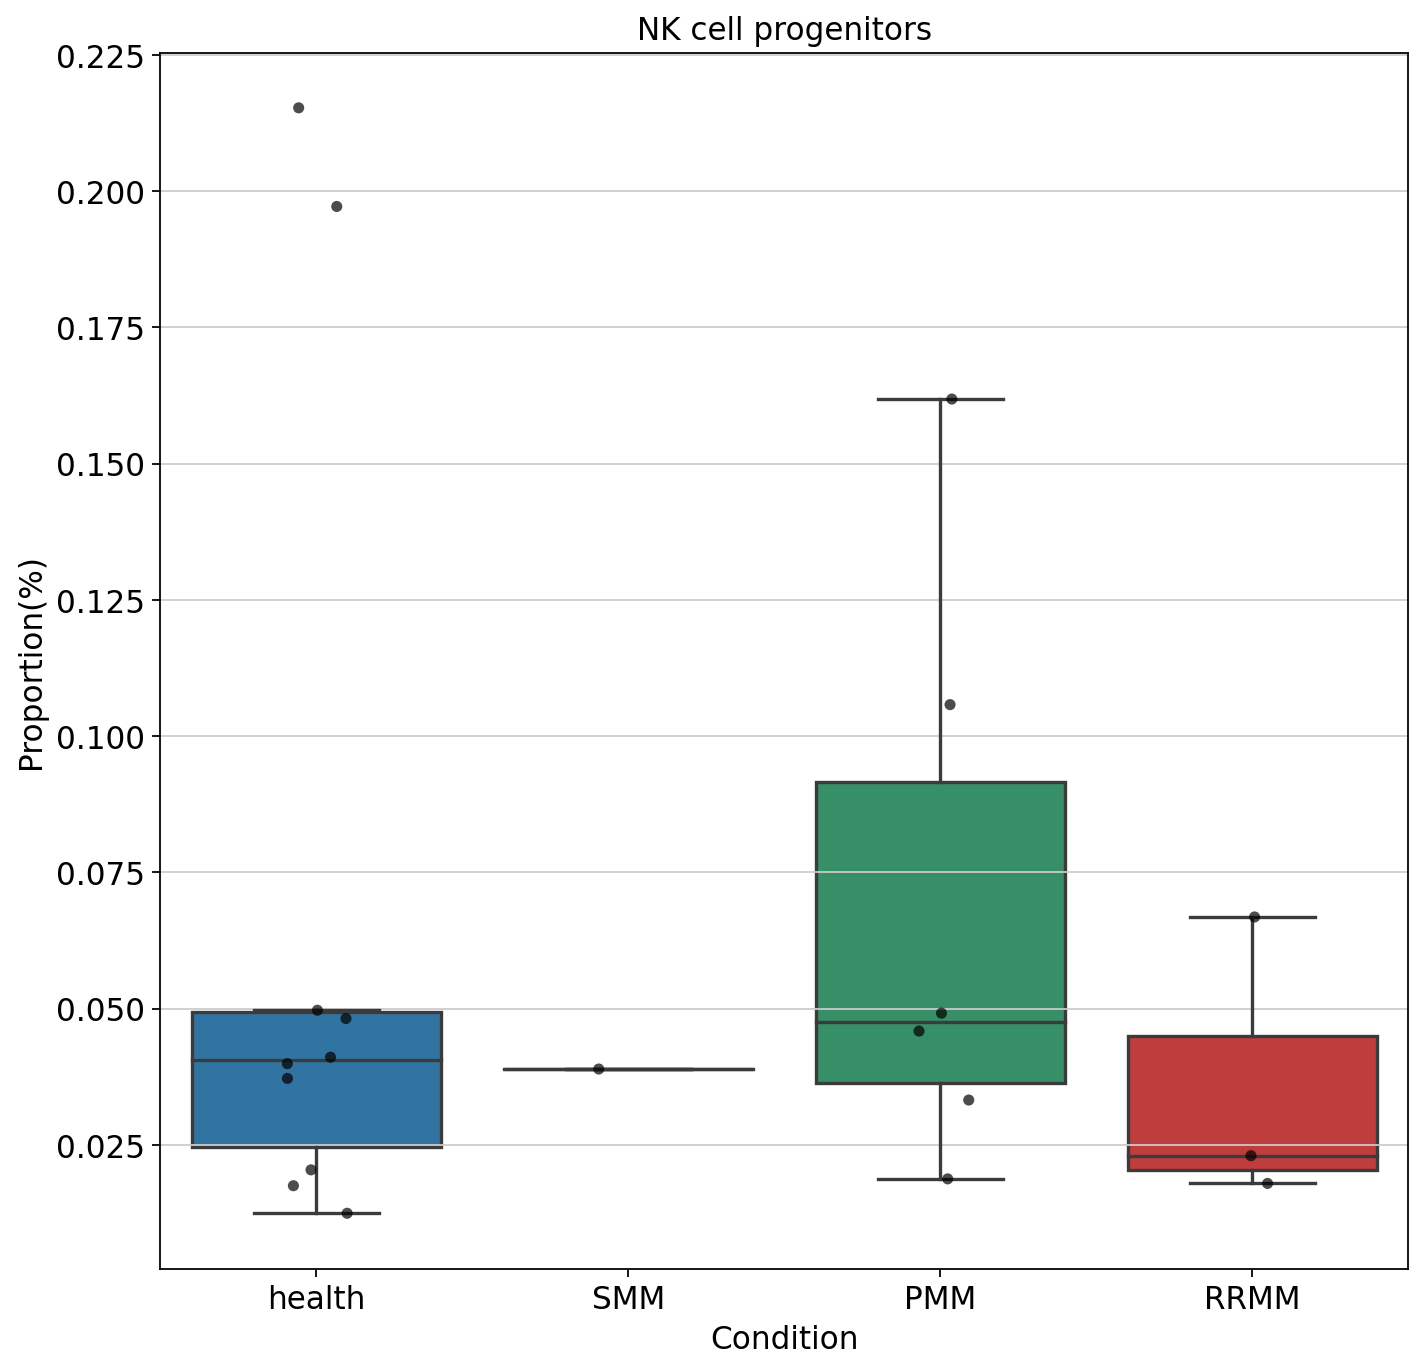







p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

health vs. RRMM: Custom statistical test, P_val:4.744e-03


Text(0.5, 1.0, 'Non-classical monocytes')

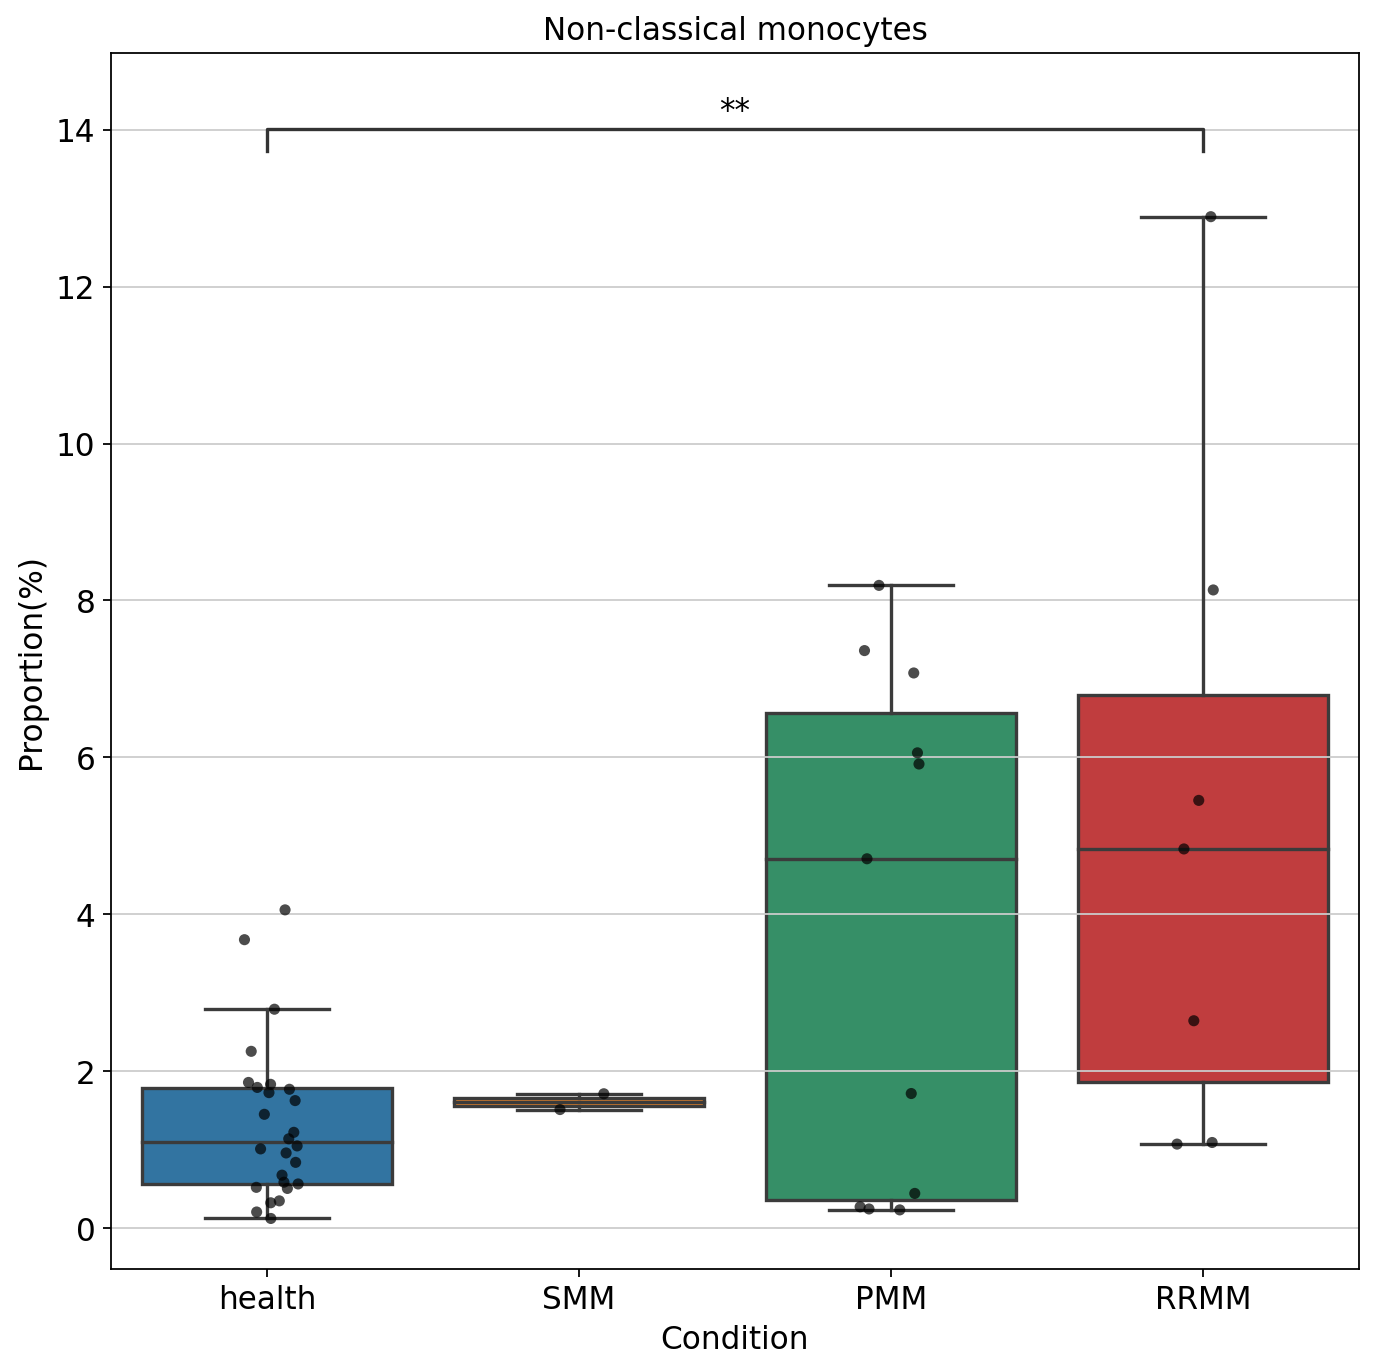

Text(0.5, 1.0, 'Nonswitched memory B cells')

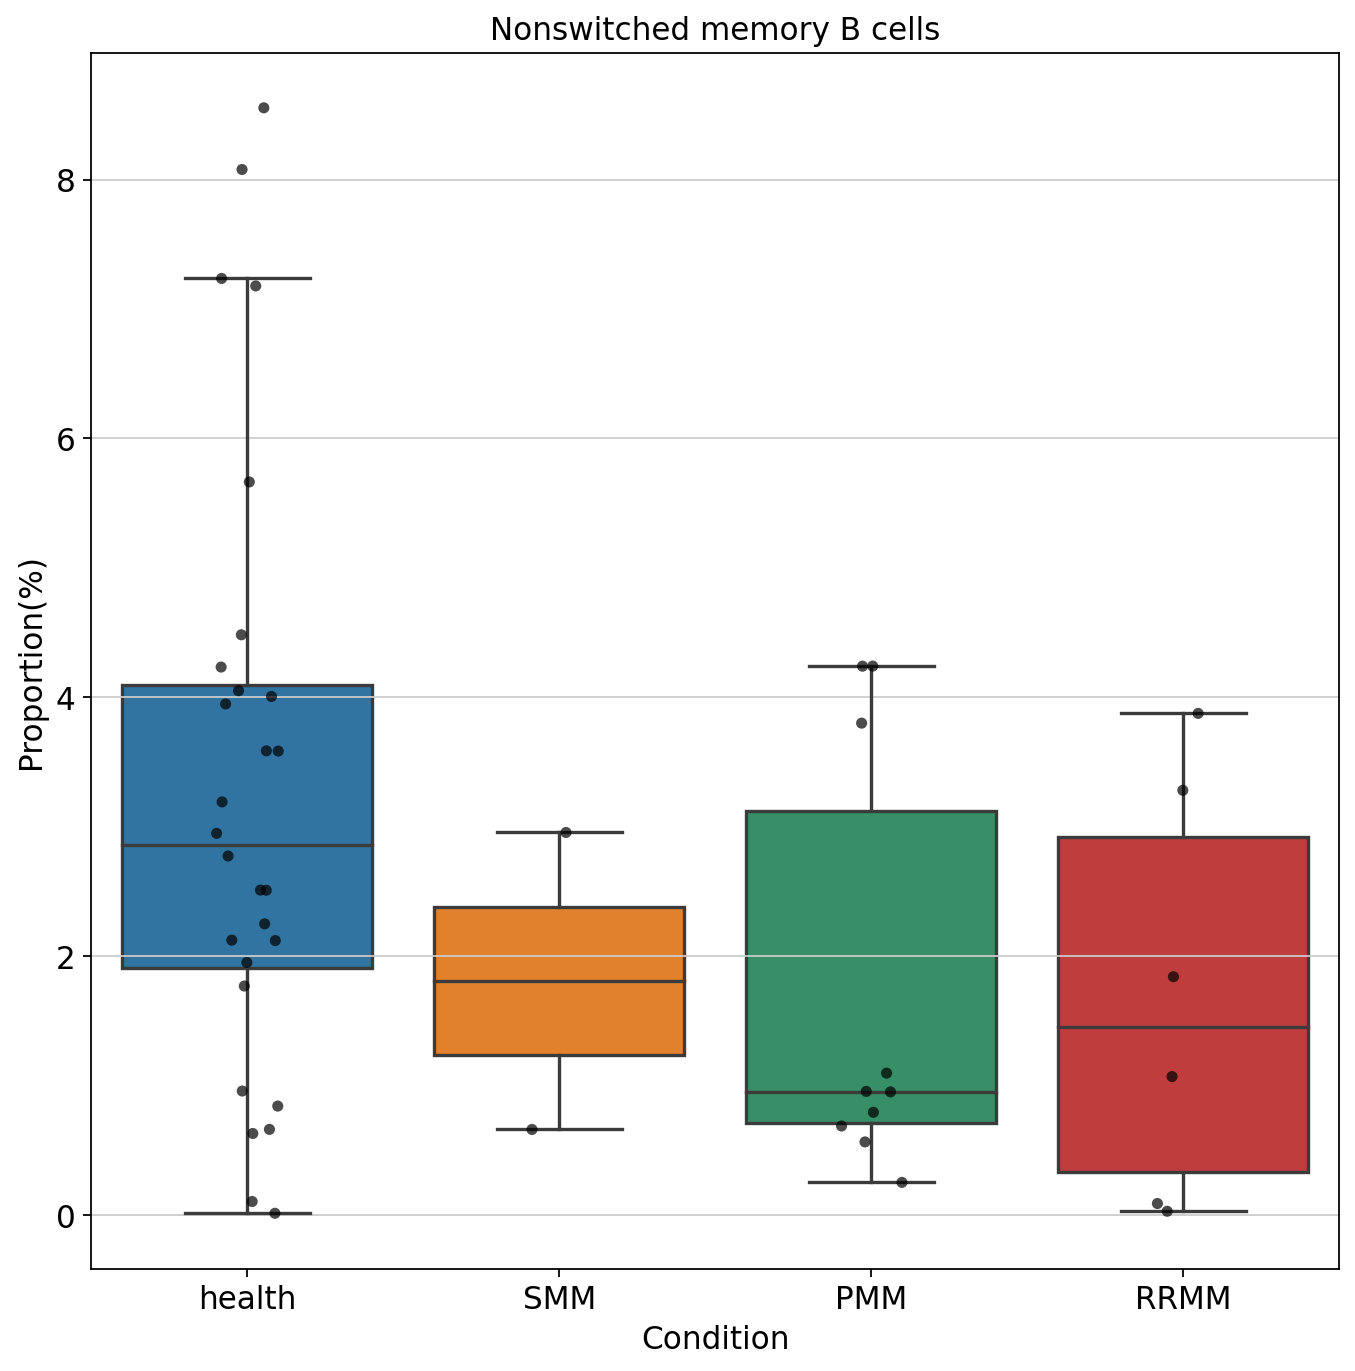







p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

health vs. SMM: Custom statistical test, P_val:5.291e-03
health vs. PMM: Custom statistical test, P_val:2.114e-04
health vs. RRMM: Custom statistical test, P_val:4.744e-03


Text(0.5, 1.0, 'Plasma cells')

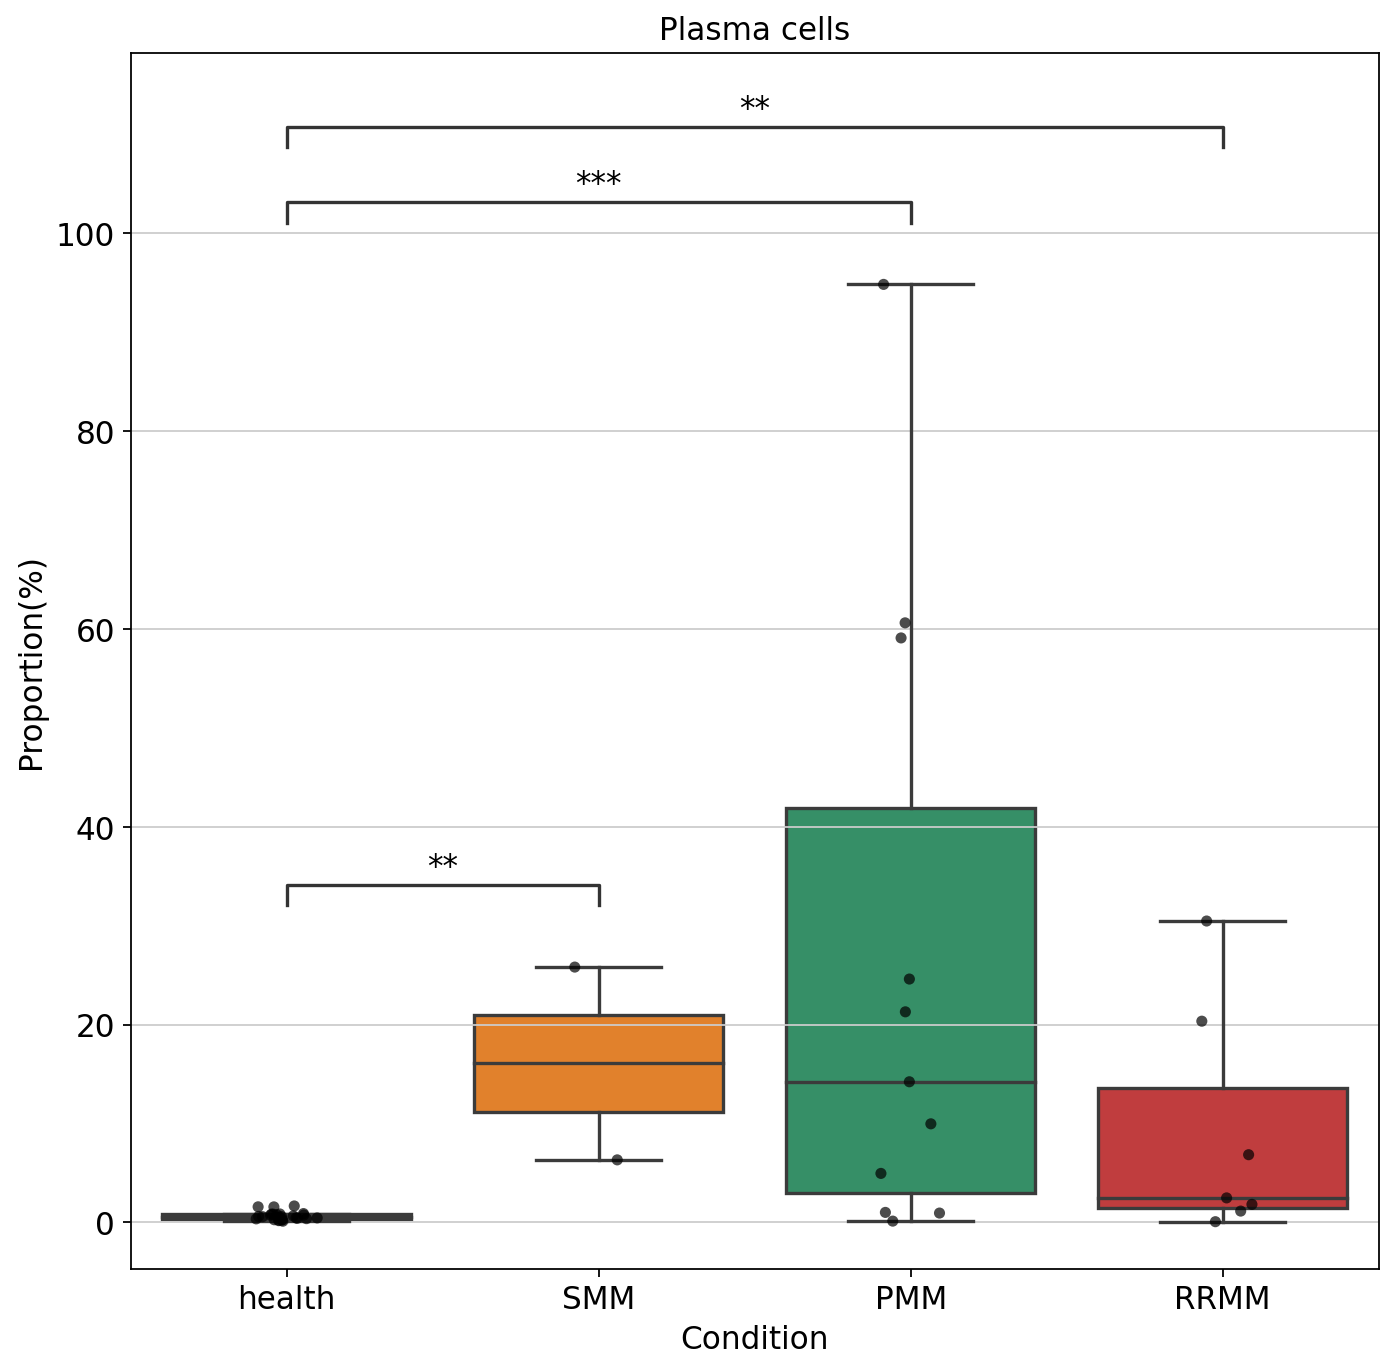

Text(0.5, 1.0, 'Plasmacytoid dendritic cell progenitors')

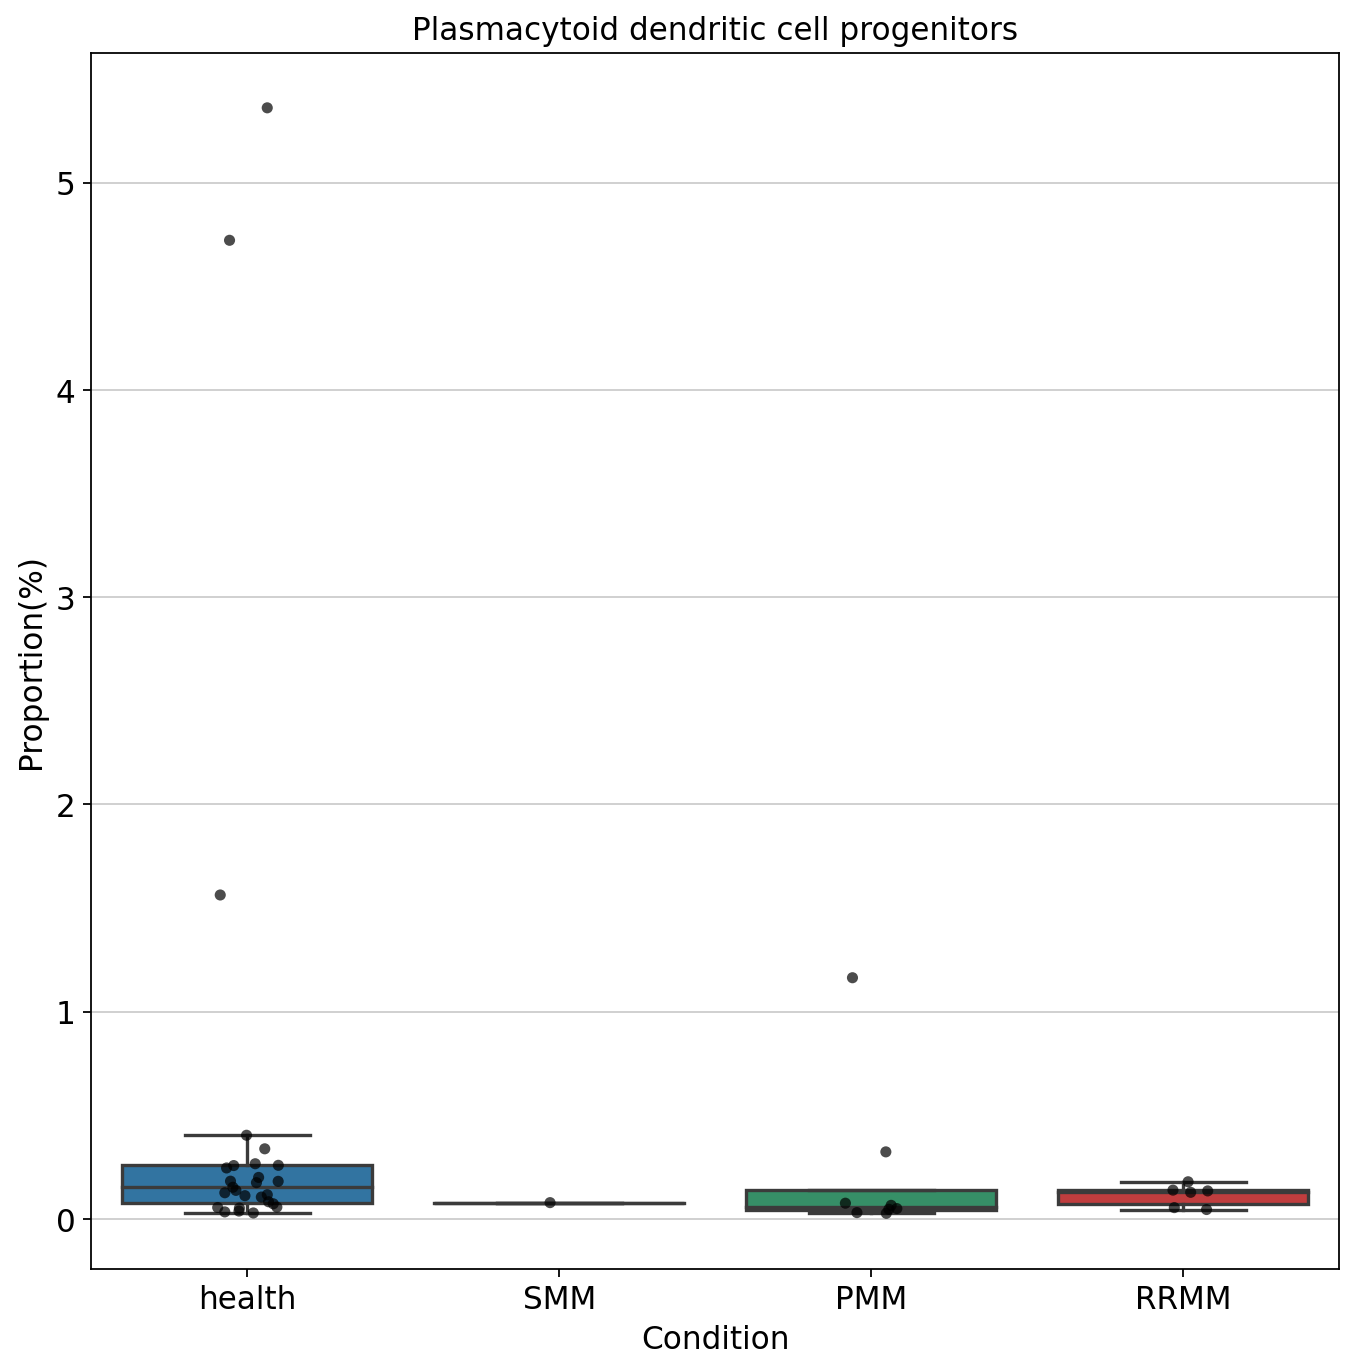

Text(0.5, 1.0, 'Plasmacytoid dendritic cells')

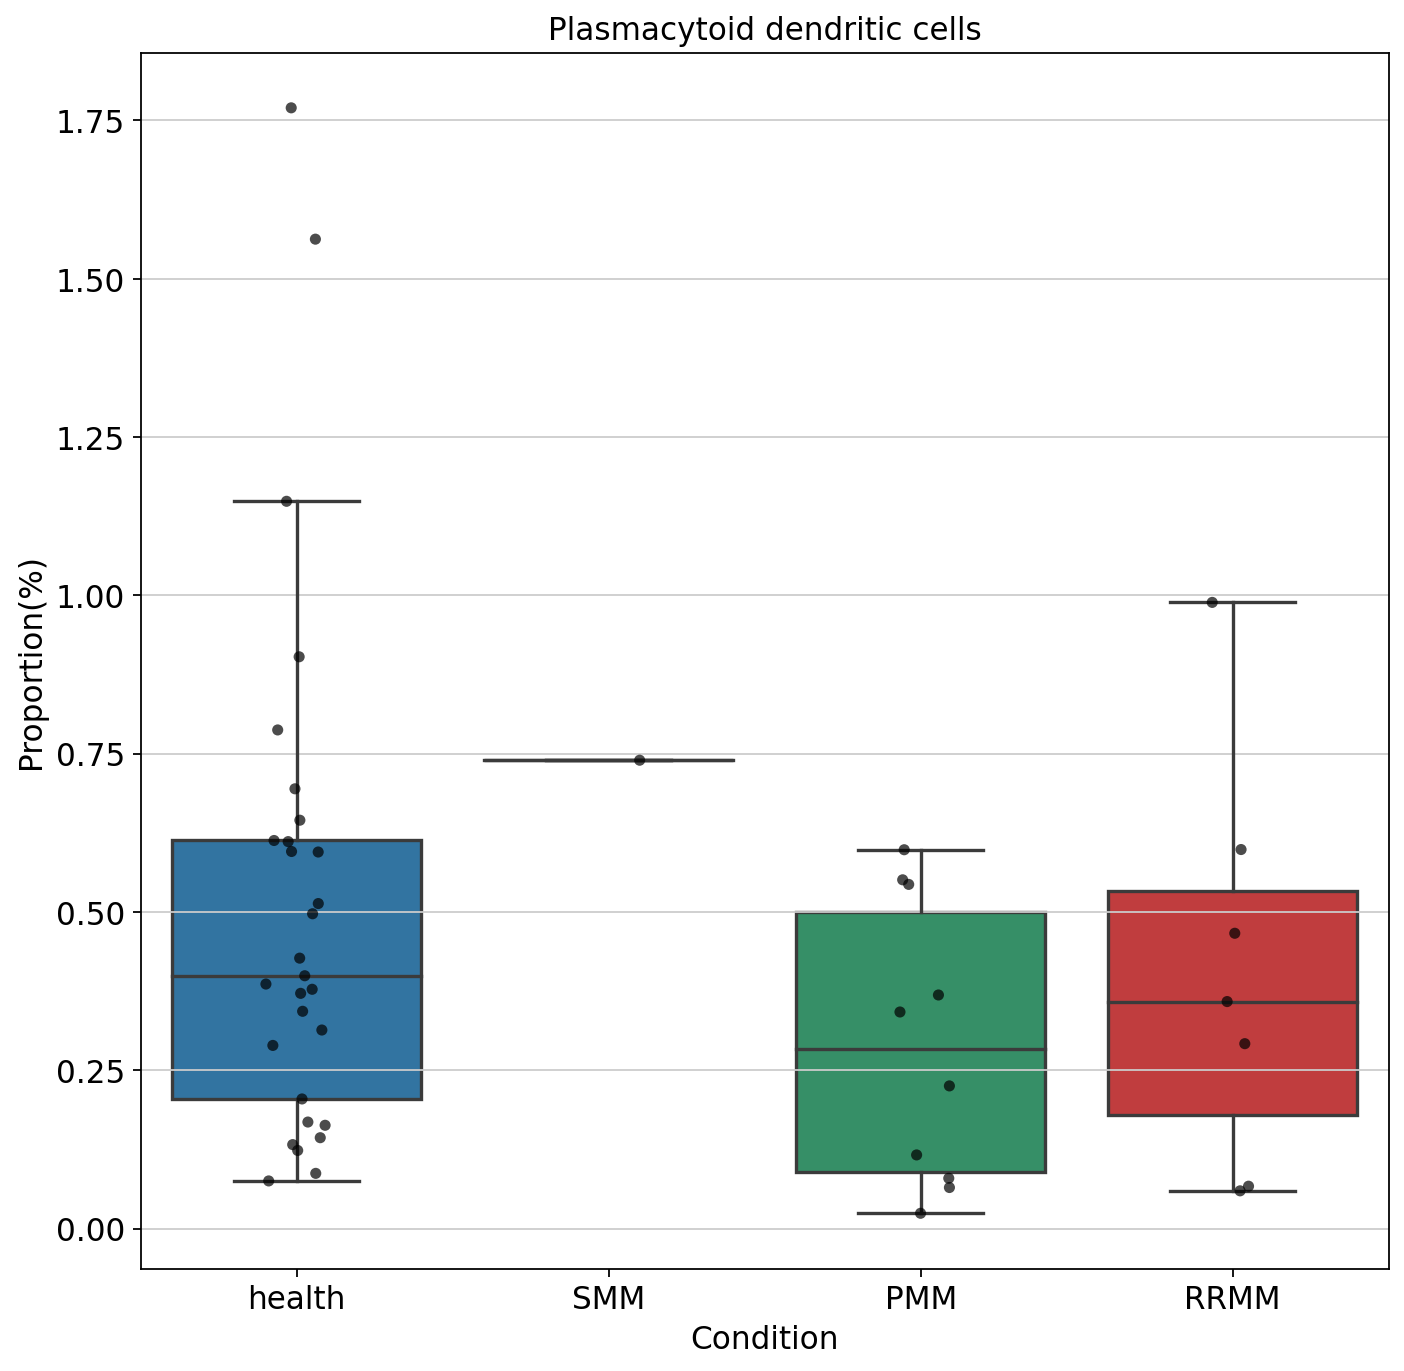







p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

health vs. RRMM: Custom statistical test, P_val:3.672e-04


Text(0.5, 1.0, 'Pre-B cells')

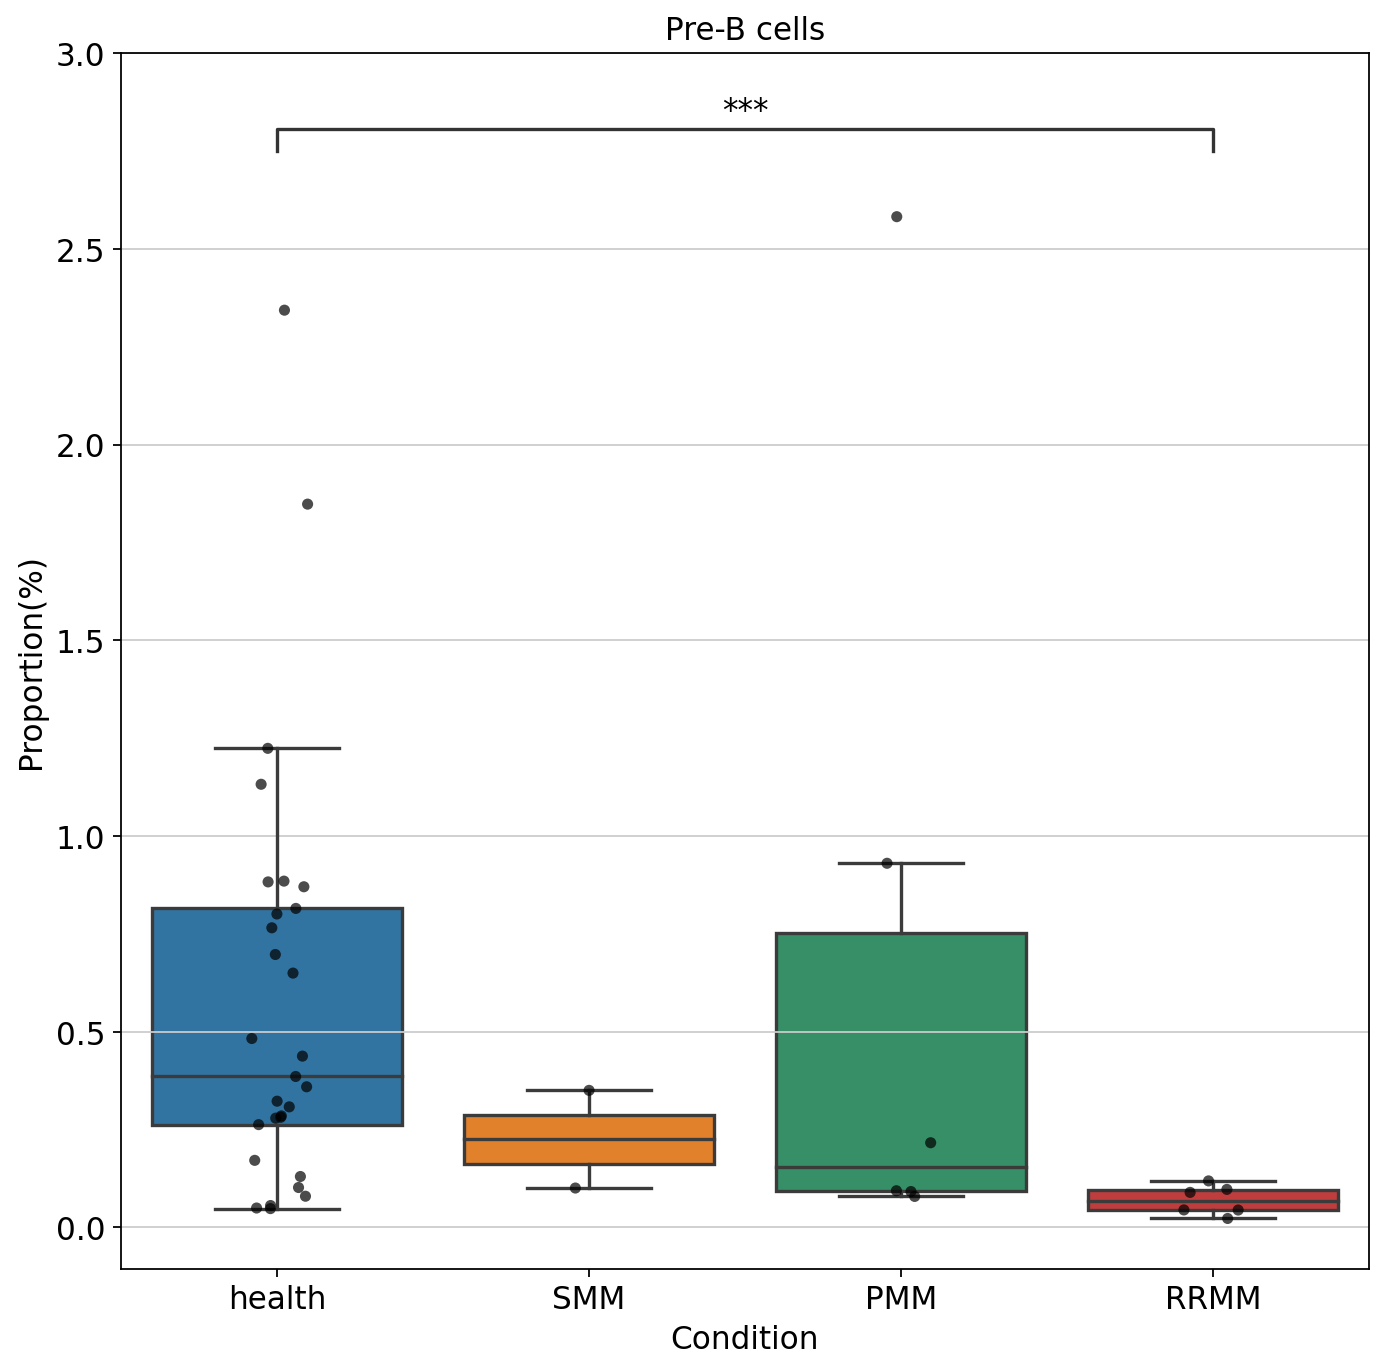

Text(0.5, 1.0, 'Pre-pro-B cells')

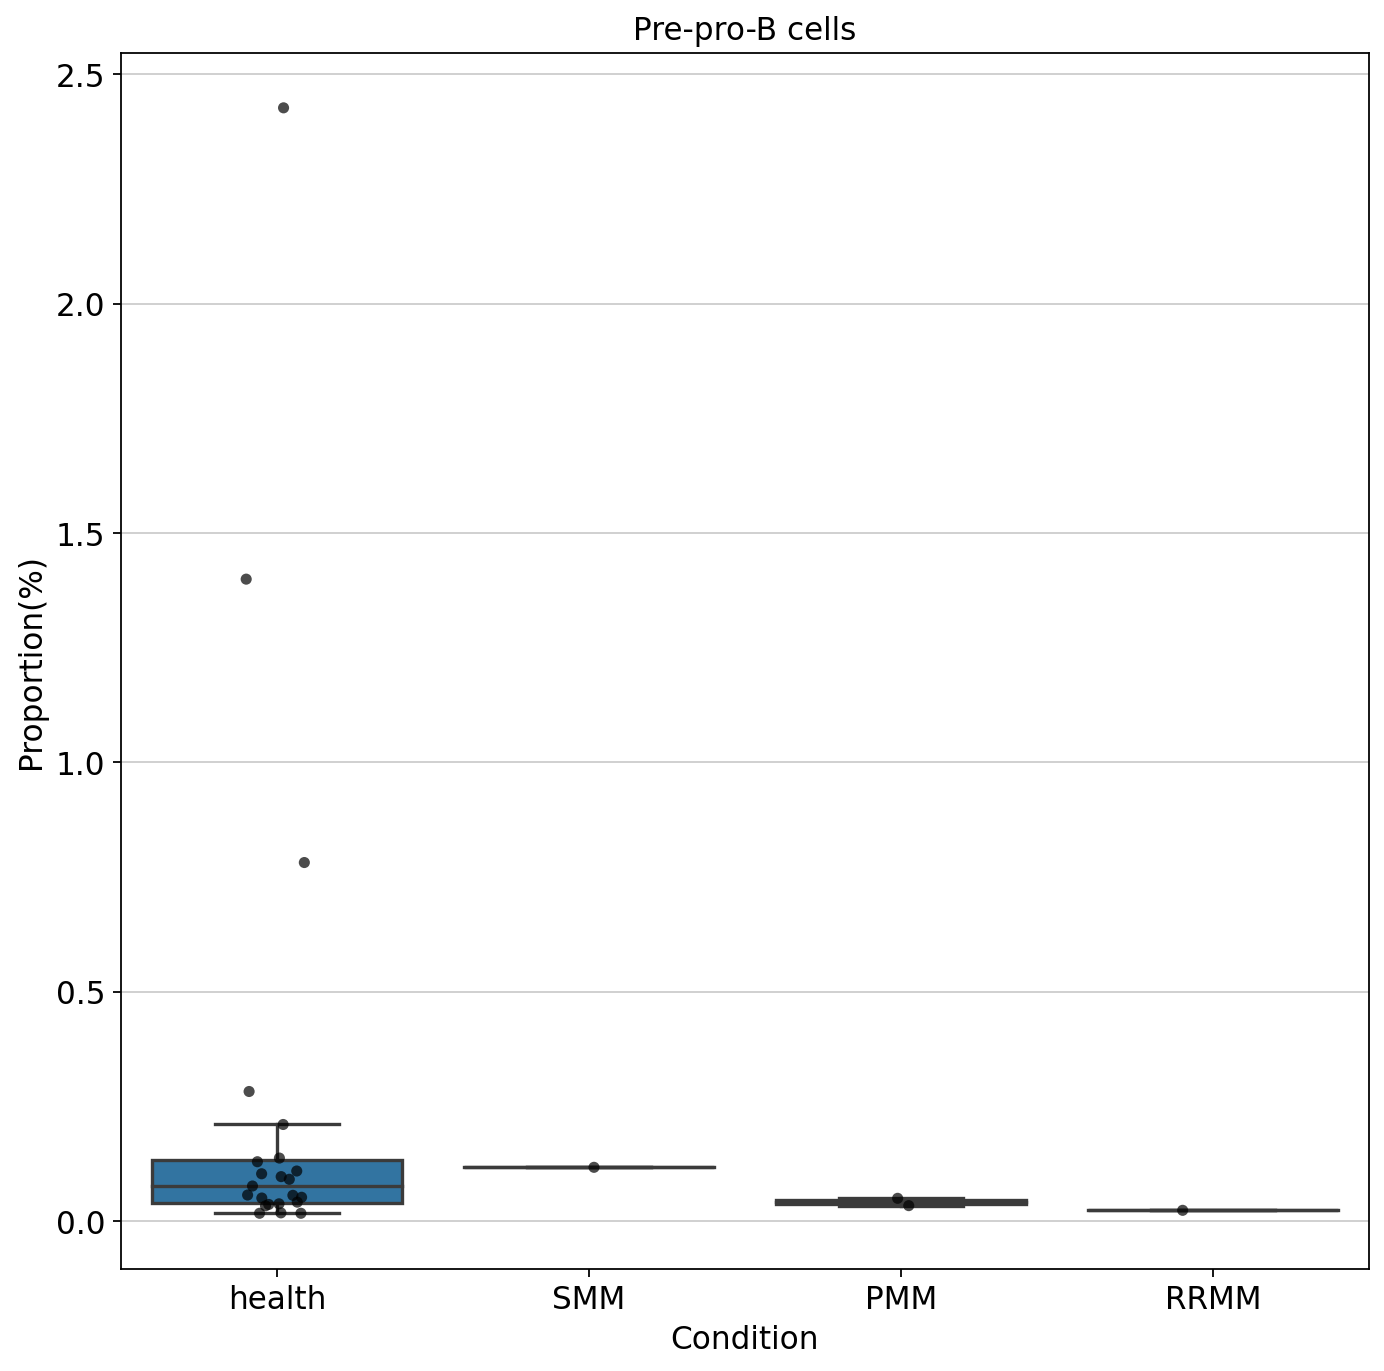







p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

health vs. PMM: Custom statistical test, P_val:1.077e-02
health vs. RRMM: Custom statistical test, P_val:1.037e-04


Text(0.5, 1.0, 'Pro-B cells')

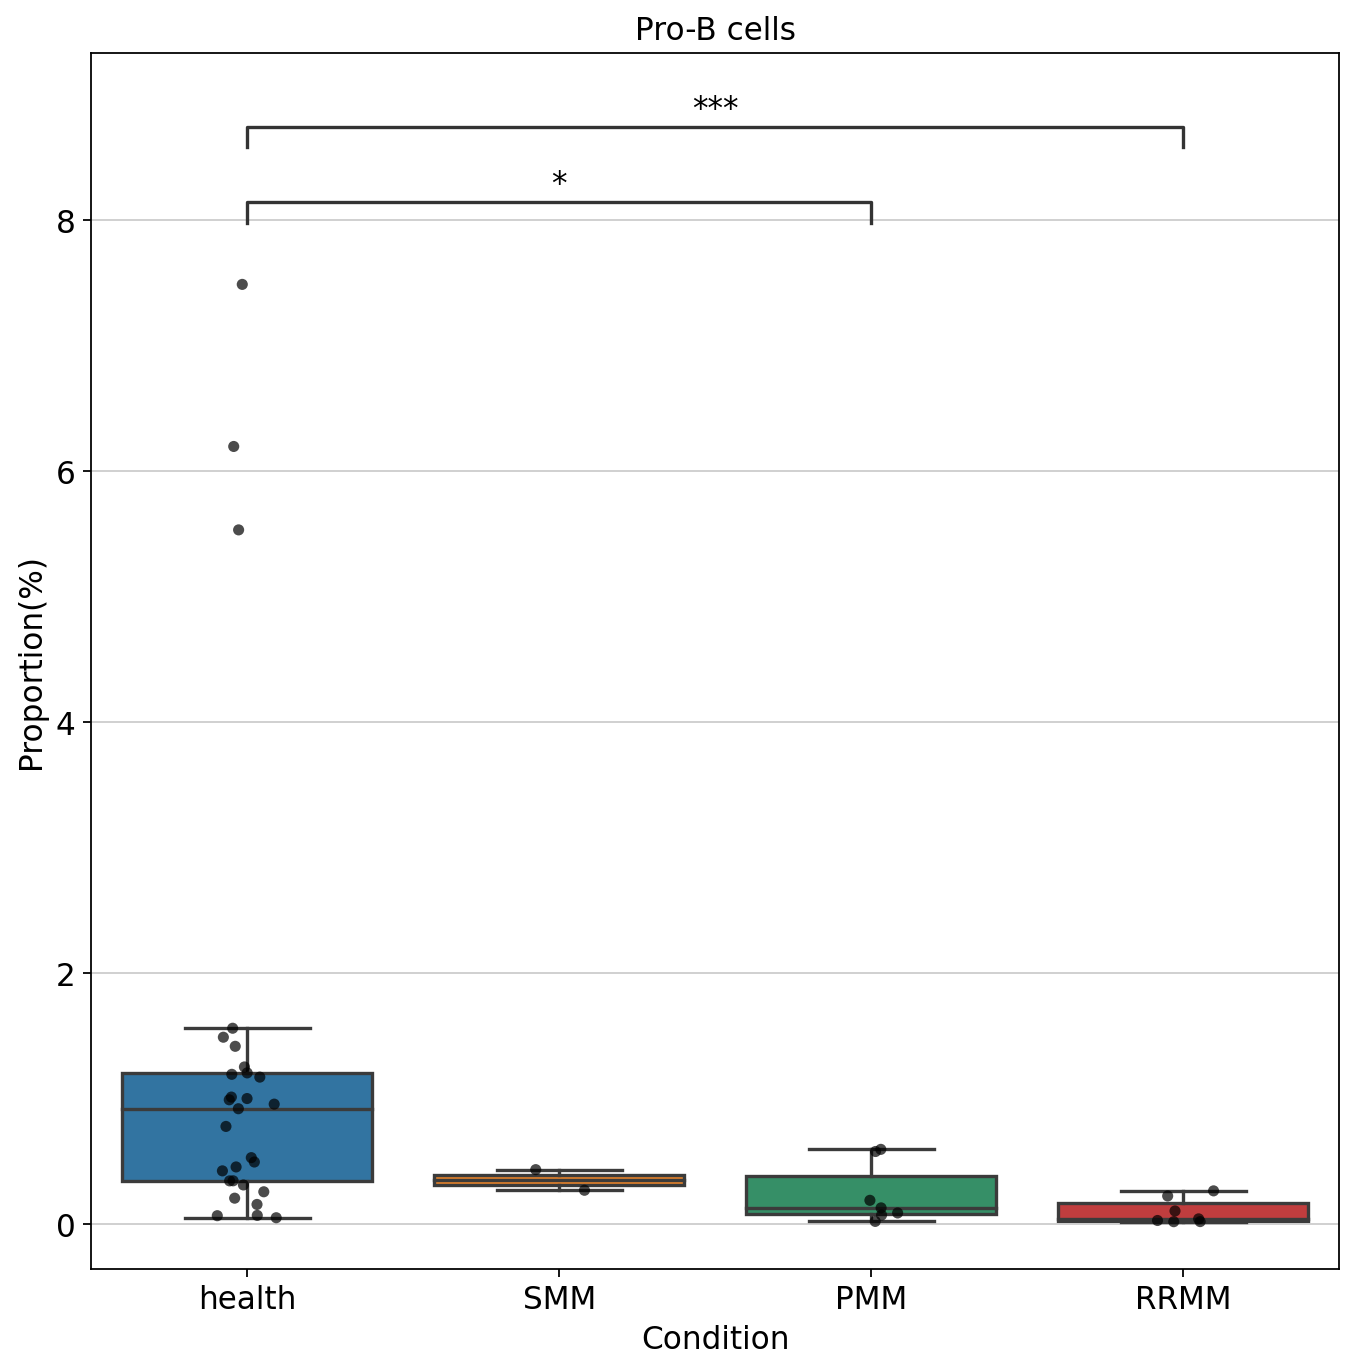







p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

health vs. RRMM: Custom statistical test, P_val:3.300e-02


Text(0.5, 1.0, 'Small pre-B cell')

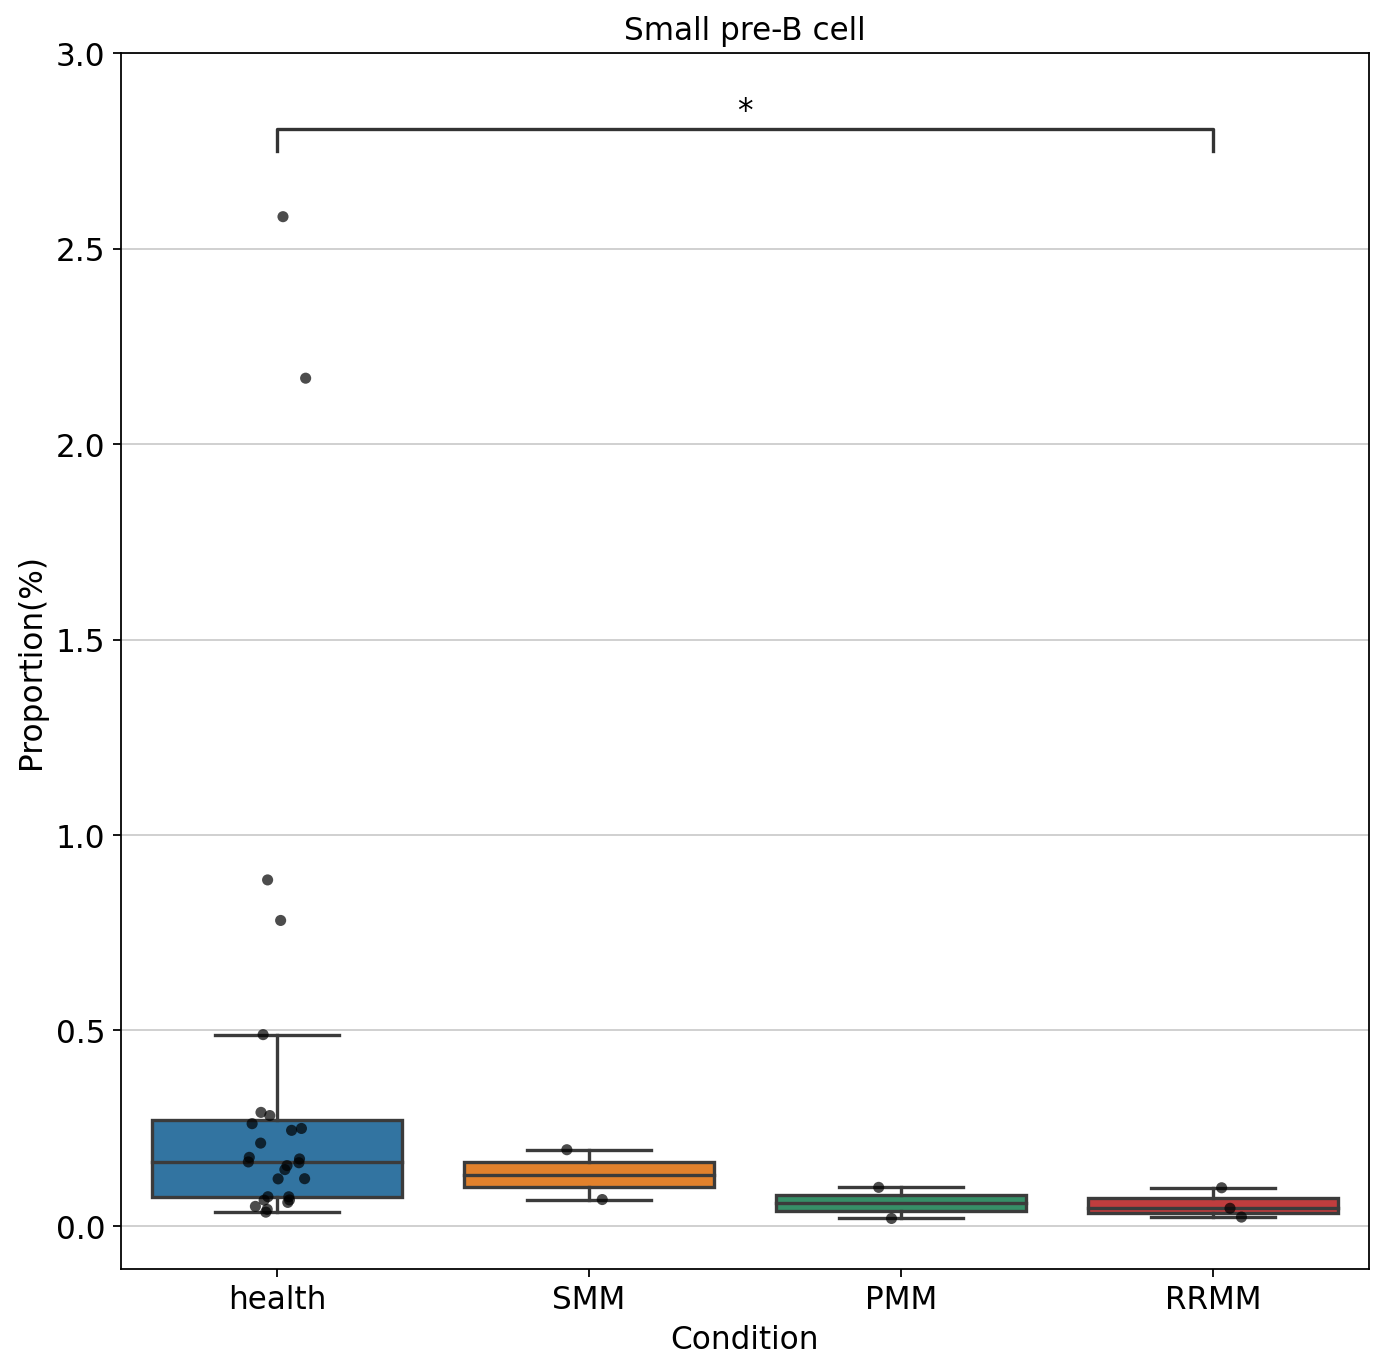

In [26]:
significant = statistics()
significant_cells = cells[cells["cell"].isin(significant)]
